In [1]:
from phew import Loss_given_delay as lgd
from phew import Cola
from phew import Premium
import pandas as pd
import numpy as np
from phew import Expenses
from phew import Interest_rates
from phew import Time_value
from phew import Annuity

In [3]:
import phew

In [4]:
help(phew)

Help on package phew:

NAME
    phew - The primary objective of this package is to simulate pricing of trip delay insurance coverage for salaried formal sector workers in Malawi who take buses when traveling long distances. The product is capable of providing benefits in a trip delay event as a way of managing unexpected expenses associated with the event. The product will be funded by tax and is being classified as a social travel insurance product. This package lays mathematical framework for calculation of losses associated with the delays and contains functions for calculation of different financial and economical variables. Social travel insurance plans have potential to incentivise workers to be productive. They can also be used as incentive for more takings of public transport which according to United Nations is one of the ways of reducing greenhouse gas emissions. Additionally, the work has potential to make social travel insurance become a well established academic discipline

In [5]:
import matplotlib.pyplot as plt

In [6]:
plt.style.use('seaborn-darkgrid')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(15, 5),
    titlesize=20,
    titleweight='bold'
)
%config InlineBackend.figure_format = 'retina'

<h2 style = 'background-color:teal;padding:10px;color:white;border-radius:10px;text-align:center;margin-left:150px;margin-right:170px;'> Trip delay losses framework </h2>

<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:600px'> Benefit adjustment </h3>

In [7]:
# importing expected cpi data , 2010 as base year
exp_cpi = pd.read_csv('cpi_forecast.csv')

In [8]:
# transforming data
exp_cpi.columns = ['Date','CPI']
exp_cpi.index = exp_cpi.Date
exp_cpi.drop('Date',axis = 'columns',inplace = True)
exp_cpi

CPI
Date                   
2018-01-01   421.491047
2019-01-01   502.273135
2020-01-01   598.537749
2021-01-01   713.252237
2022-01-01   849.952662
2023-01-01  1012.852803
2024-01-01  1206.974044
2025-01-01  1438.300153
2026-01-01  1713.961739
2027-01-01  2042.456045
2028-01-01  2433.908880
2029-01-01  2900.386743

In [9]:
# estimating cpi from one year to another
exp_cpi_year2year = (exp_cpi.CPI.diff() / 100) + 1
exp_cpi_year2year = pd.DataFrame(exp_cpi_year2year)
exp_cpi_year2year.columns = ['CPI']
exp_cpi_year2year

CPI
Date                
2018-01-01       NaN
2019-01-01  1.807821
2020-01-01  1.962646
2021-01-01  2.147145
2022-01-01  2.367004
2023-01-01  2.629001
2024-01-01  2.941212
2025-01-01  3.313261
2026-01-01  3.756616
2027-01-01  4.284943
2028-01-01  4.914528
2029-01-01  5.664779

In [10]:
# importing expected inflation data
exp_infla = pd.read_csv('inflation_forecast.csv')

In [11]:
# transforming data
exp_infla.columns = ['Date','Inflation']
exp_infla.index = exp_infla.Date
exp_infla.drop('Date',axis = 'columns',inplace = True)
exp_infla

Inflation
Date                 
2023-12-31  30.158578
2024-12-31  10.904419
2025-12-31  28.428562
2026-12-31  15.508666
2027-12-31  15.486050
2028-12-31  15.463467
2029-12-31  15.440916

In [12]:
cost_of_benefit = 3500 # according to prices in january, 2024

In [13]:
# cpi to simulate benefit growth in the next five years
cpi_vs = [i[0] for i in exp_cpi_year2year.iloc[7::].values]
cpi_vs

[3.3132610957137354,
 3.7566158575150985,
 4.284943061543654,
 4.9145283475627295,
 5.664778626839084]

In [14]:
# inflation rates to simulate benefit growth in the next five years
inflation_vs = [i[0] for i in exp_infla.iloc[1::].values]
inflation_vs

[10.90441868568471,
 28.428561964486818,
 15.508666450612472,
 15.486050147588957,
 15.463466825941628,
 15.440916437573724]

In [15]:
# benefit growth using cpi method
benefit_amounts_cpi = Cola(initial_fund = cost_of_benefit,data = cpi_vs,method = 'cpi')

In [16]:
benefit_amounts_cpi.fund_growth()

array([  11596.413835  ,   43563.27210286,  186666.14053529,
        917376.03919083, 5196732.1795825 ])

In [17]:
# benefit growth using cpi method
benefit_amounts_inflation = Cola(initial_fund = cost_of_benefit,data = [i for i in (np.array(inflation_vs) / 100)],method = 'inflation')

In [18]:
benefit_amounts_inflation.fund_growth()

array([3881.654654  , 4985.15325256, 5758.28404255, 6650.01479702,
       7678.33762908, 8863.94332618])

#### Conclusion - cpi method seems unrealistic because the predicted cpi values when used in the fund growth model result in very high benefit values which can be said to be a result of the MA(1) failing to properly forecast cpi. The inflation method seems realistic because the movement of the forecast inflation values resembles the movement of the near past inflation . Therefore, output from inflation method is to be used.

In [19]:
benefit_estimates = pd.DataFrame({'Benefit':benefit_amounts_inflation.fund_growth()},index = exp_infla.index[1::])
benefit_estimates

Benefit
Date                   
2024-12-31  3881.654654
2025-12-31  4985.153253
2026-12-31  5758.284043
2027-12-31  6650.014797
2028-12-31  7678.337629
2029-12-31  8863.943326

<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:300px'> Loss basis </h3>

In [20]:
# assuming factors such as weather have no effect on delays, model to be used is a one-season model
number_of_days = [365] # number of days in a year
ratio_of_workers_to_population = 0.1 # formal sector makes 13 percent of the working population, which is 0.1 of the total population
carrying_capacity = 50 

#### Assumption : expected_daily_delays increases by 1 every year. Delays increament being result of growth of transportation business.

<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:300px'> 2025 loss </h3>

In [21]:
benefit_2025 = benefit_estimates.loc[benefit_estimates.index == '2025-12-31'].values[0][0]
expected_daily_delays_in_a_season1 = [7]

In [22]:
loss = lgd(number_of_days = number_of_days,ratio_of_workers_to_population = ratio_of_workers_to_population,carrying_capacity = carrying_capacity,benefit = benefit_2025,expected_daily_delays_in_a_season = expected_daily_delays_in_a_season1)

In [23]:
daily_loss_obj = loss.daily_loss_compute(1000)

In [24]:
daily_loss_obj.keys()

dict_keys(['expected_daily_loss', 'daily_losses_output', 'daily_claims_output', 'daily_delays_values'])

In [25]:
expected_daily_loss = daily_loss_obj['expected_daily_loss']['season 0']
expected_daily_loss

168074.44191000806

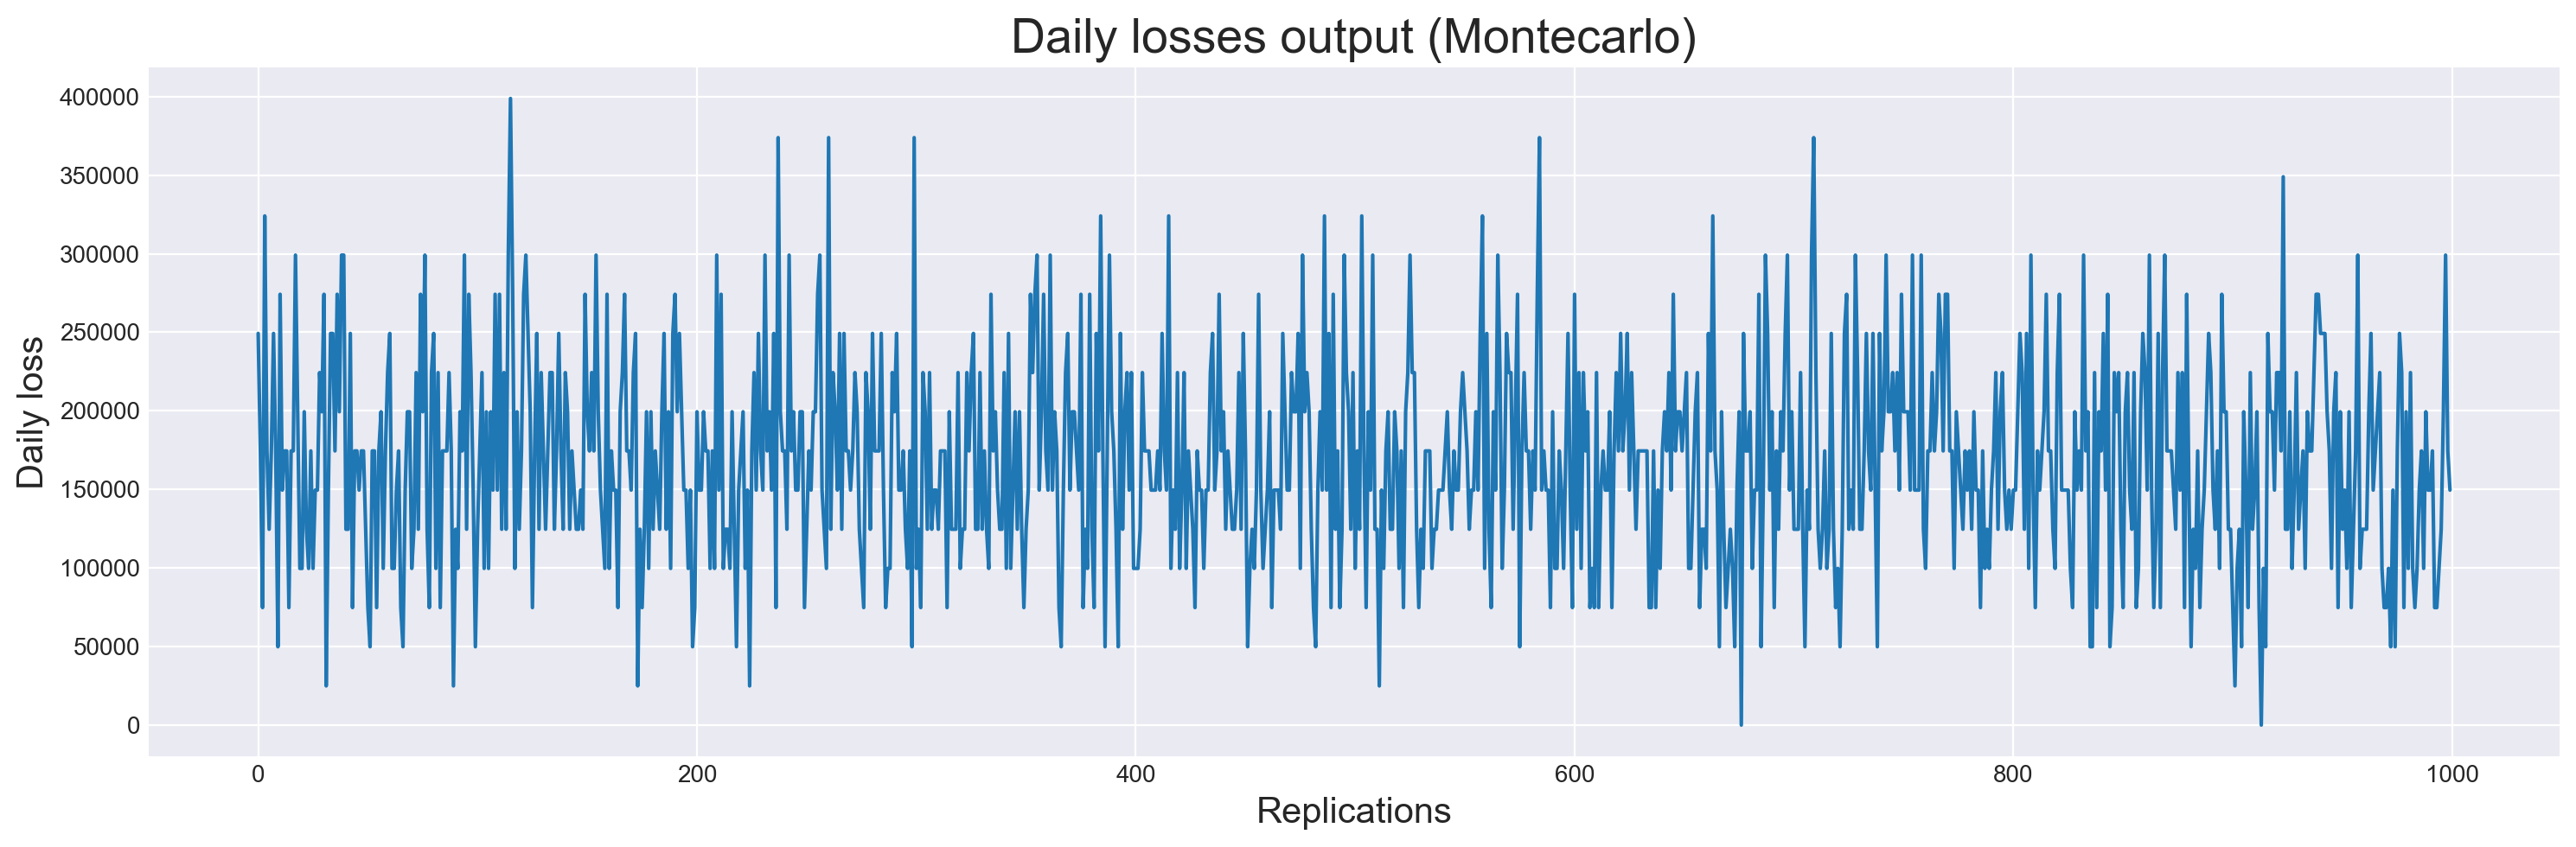

In [26]:
# plotting daily loss output from Montecarlo
daily_losses_output = daily_loss_obj['daily_losses_output']['season 0']
plt.plot(pd.Series(daily_losses_output))
plt.title('Daily losses output (Montecarlo)',size = 20)
plt.xlabel('Replications',size = 15)
plt.ylabel('Daily loss',size= 15)
plt.show()

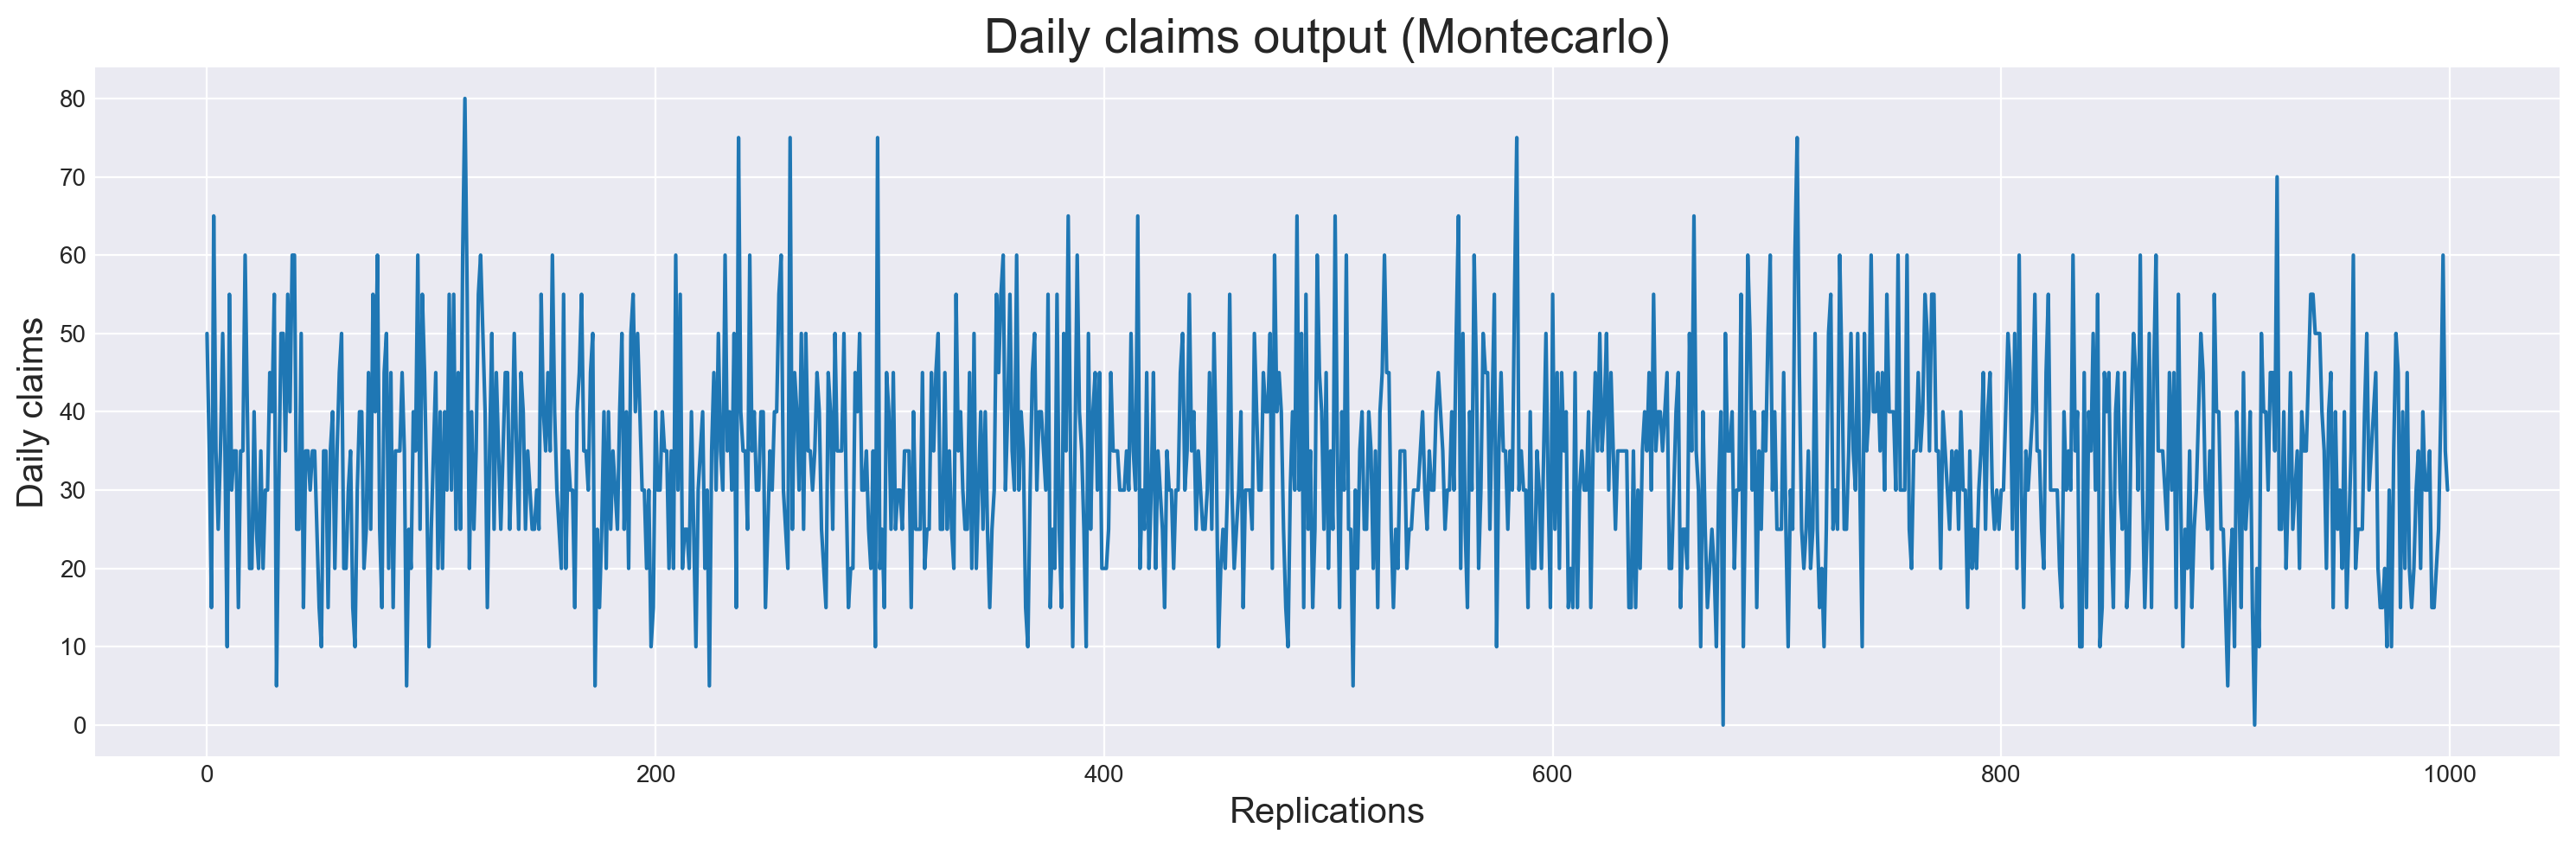

In [27]:
# plotting daily claims output from Montecarlo
daily_claims_output = daily_loss_obj['daily_claims_output']['season 0']
plt.plot(pd.Series(daily_claims_output))
plt.title('Daily claims output (Montecarlo)',size = 20)
plt.xlabel('Replications',size = 15)
plt.ylabel('Daily claims',size= 15)
plt.show()

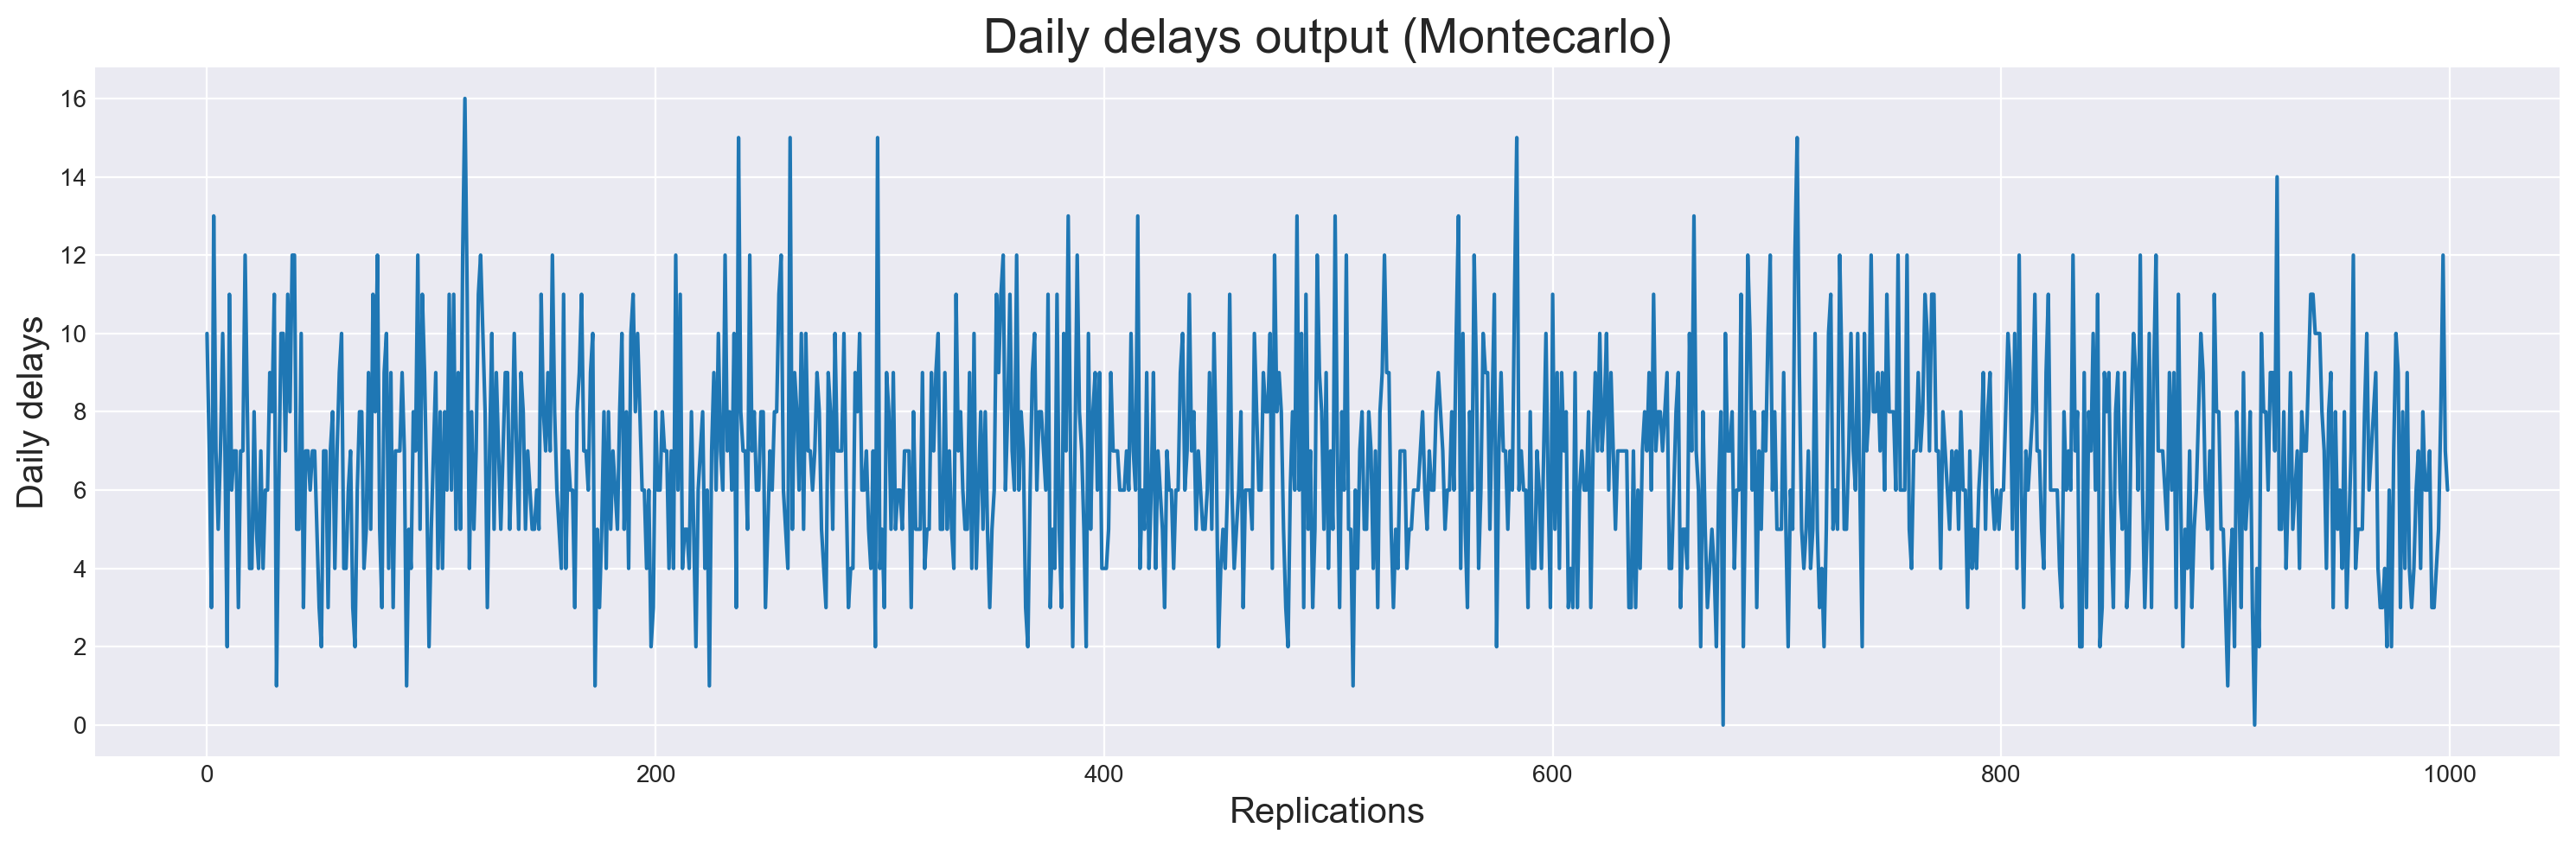

In [28]:
# plotting daily delays output from Montecarlo
daily_delays_output = daily_loss_obj['daily_delays_values']['season 0']
plt.plot(pd.Series(daily_delays_output))
plt.title('Daily delays output (Montecarlo)',size = 20)
plt.xlabel('Replications',size = 15)
plt.ylabel('Daily delays',size= 15)
plt.show()

In [29]:
seasonal_loss = loss.seasonal_loss_compute([expected_daily_loss]) # or loss.seasonal_loss_compute(loss.expected_daily_loss_in_season)
seasonal_loss = seasonal_loss['season 0']
seasonal_loss

61347171.297152944

In [30]:
loss.expected_seasonal_loss

array([61347171.29715294])

In [31]:
year_2025_loss = loss.yearly_loss_compute([seasonal_loss]) # or loss.yearly_loss_compute(loss.expected_seasonal_loss)
year_2025_loss = year_2025_loss['yearly loss']
year_2025_loss

61347171.297152944

In [32]:
# 2025 daily claims 
daily_claims = loss.expected_claims(time_frame = 'day')
daily_claims

{'season 0': 33.715}

In [33]:
# 2025 seasonal claims
seasonal_claims = loss.expected_claims(time_frame = 'season')
seasonal_claims

{'season 0': 12305.975}

In [34]:
# 2025 yearly loss
year_2025_claims = loss.expected_claims(time_frame = 'year')
year_2025_claims = round(year_2025_claims['year'])
year_2025_claims

12306

In [35]:
# dataframe capturing loss amount amount and expected number of claims in 2025
df_2025_lc = pd.DataFrame({'Year':[2025],'Loss':[year_2025_loss],'Claims' : [year_2025_claims]})
df_2025_lc

Year          Loss  Claims
0  2025  6.134717e+07   12306

<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:300px'> 2026 loss </h3>

In [36]:
benefit_2026 = benefit_estimates.loc[benefit_estimates.index == '2026-12-31'].values[0][0]
expected_daily_delays_in_a_season2 = [8]

In [37]:
loss2 = lgd(number_of_days = number_of_days,ratio_of_workers_to_population = ratio_of_workers_to_population,carrying_capacity = carrying_capacity,benefit = benefit_2026,expected_daily_delays_in_a_season = expected_daily_delays_in_a_season2)

In [38]:
daily_loss_obj2 = loss2.daily_loss_compute(1000)

In [39]:
expected_daily_loss2 = daily_loss_obj2['expected_daily_loss']['season 0']
expected_daily_loss2

229064.53921262294

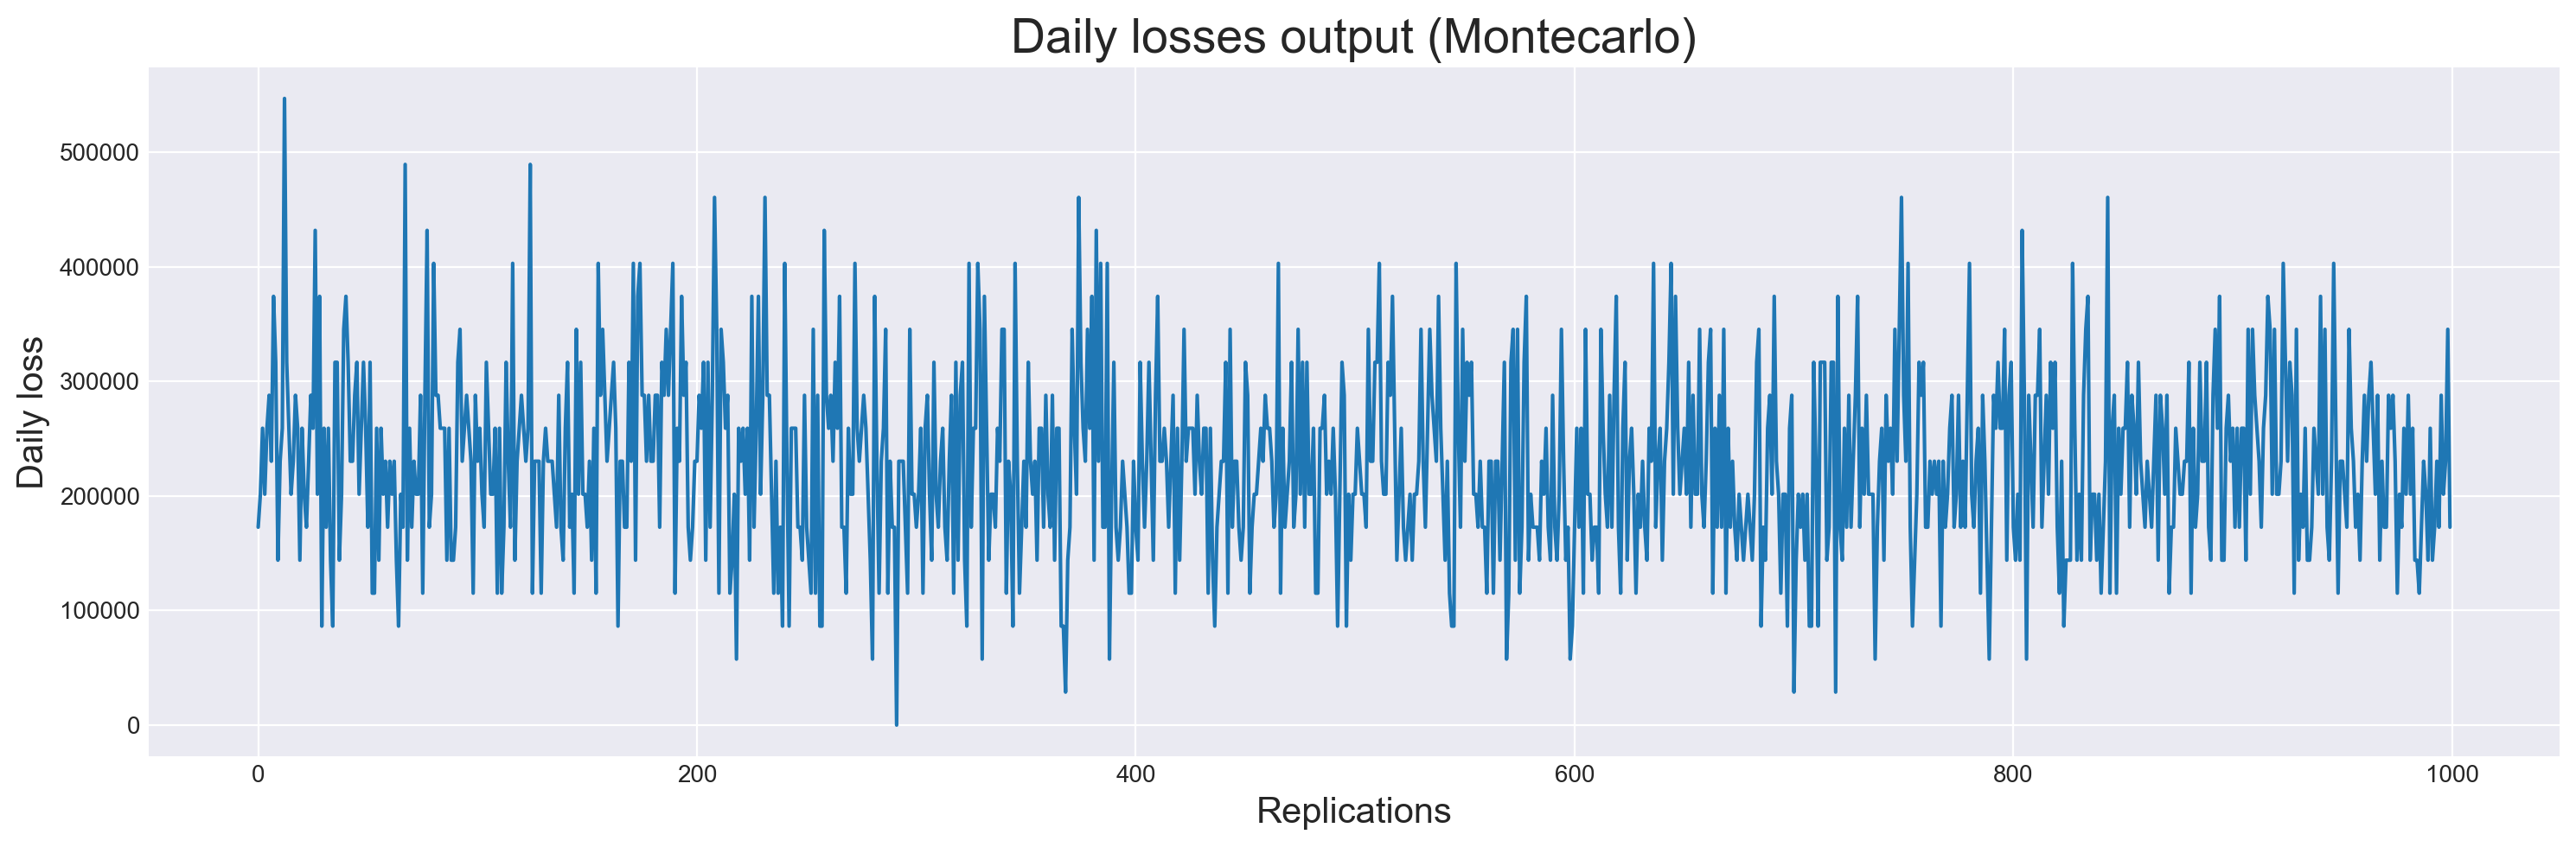

In [40]:
# plotting daily loss output from Montecarlo
daily_losses_output2 = daily_loss_obj2['daily_losses_output']['season 0']
plt.plot(pd.Series(daily_losses_output2))
plt.title('Daily losses output (Montecarlo)',size = 20)
plt.xlabel('Replications',size = 15)
plt.ylabel('Daily loss',size= 15)
plt.show()

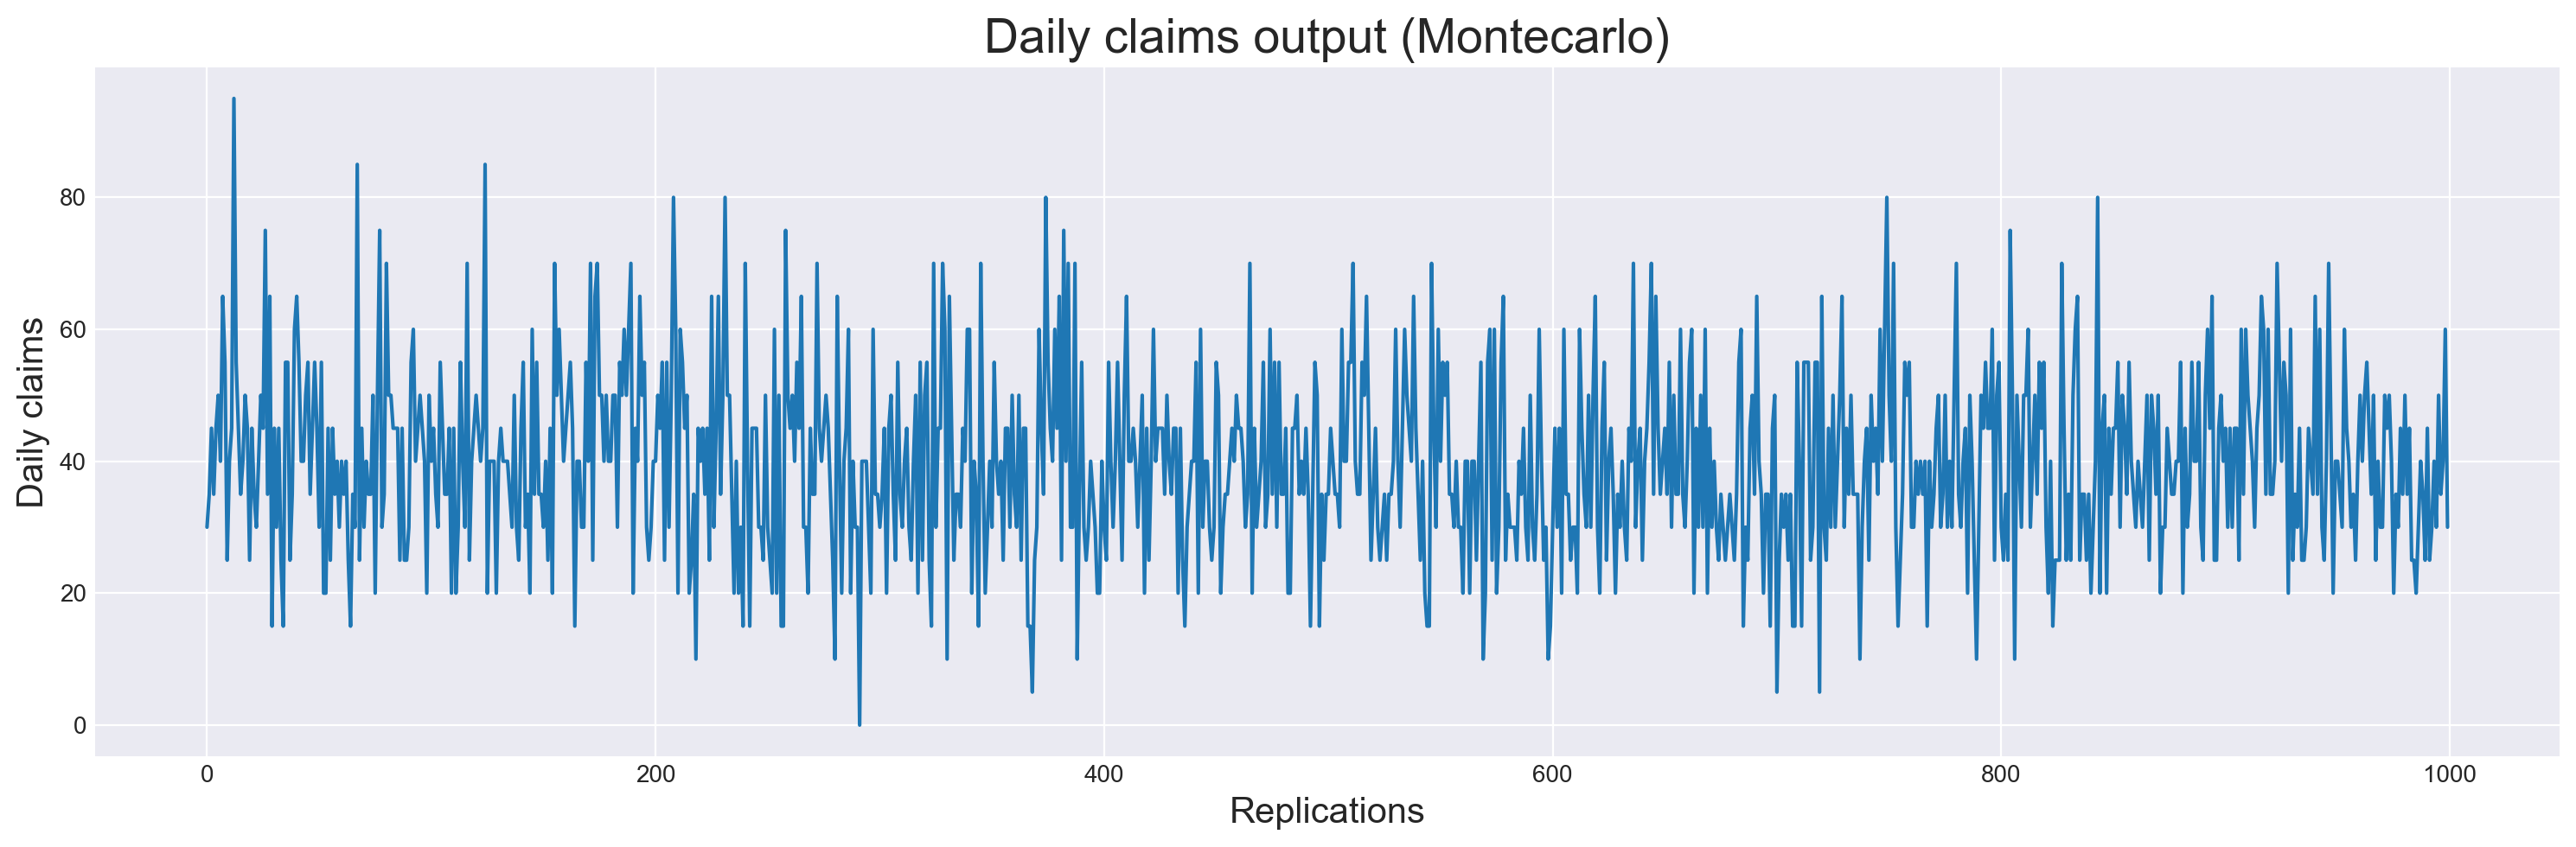

In [41]:
# plotting daily claims output from Montecarlo
daily_claims_output2 = daily_loss_obj2['daily_claims_output']['season 0']
plt.plot(pd.Series(daily_claims_output2))
plt.title('Daily claims output (Montecarlo)',size = 20)
plt.xlabel('Replications',size = 15)
plt.ylabel('Daily claims',size= 15)
plt.show()

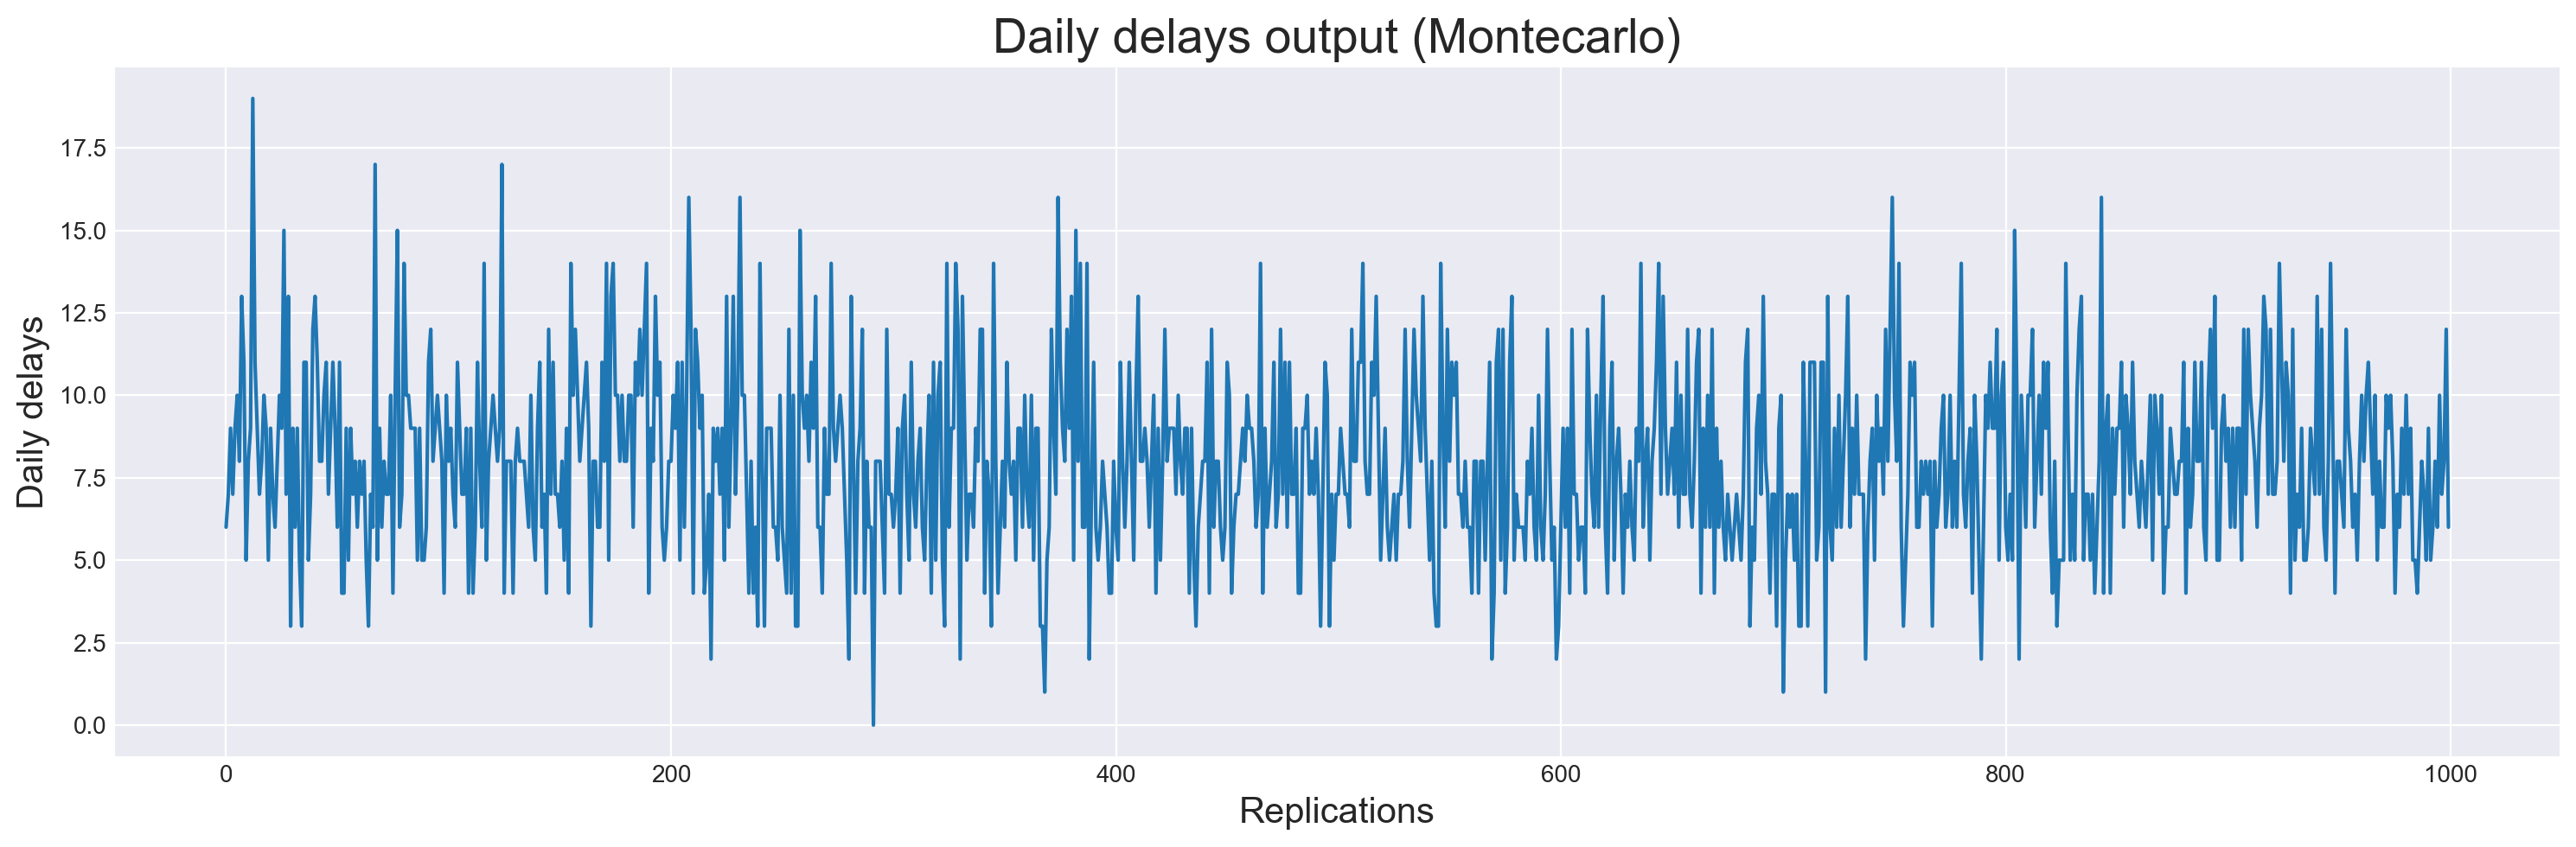

In [42]:
# plotting daily delays output from Montecarlo
daily_delays_output2 = daily_loss_obj2['daily_delays_values']['season 0']
plt.plot(pd.Series(daily_delays_output2))
plt.title('Daily delays output (Montecarlo)',size = 20)
plt.xlabel('Replications',size = 15)
plt.ylabel('Daily delays',size= 15)
plt.show()

In [43]:
seasonal_loss2 = loss2.seasonal_loss_compute([expected_daily_loss2]) # or loss2.seasonal_loss_compute(loss2.expected_daily_loss_in_season)
seasonal_loss2 = seasonal_loss2['season 0']
seasonal_loss2

83608556.81260738

In [44]:
year_2026_loss = loss2.yearly_loss_compute([seasonal_loss2]) # or loss2.yearly_loss_compute(loss2.expected_seasonal_loss)
year_2026_loss = year_2026_loss['yearly loss']
year_2026_loss

83608556.81260738

In [45]:
# 2026 daily claims 
daily_claims2 = loss2.expected_claims(time_frame = 'day')
daily_claims2

{'season 0': 39.78}

In [46]:
# 2026 seasonal claims 
seasonal_claims2 = loss2.expected_claims(time_frame = 'season')
seasonal_claims2

{'season 0': 14519.7}

In [47]:
#  2026 yearly claims 
year_2026_claims = loss2.expected_claims(time_frame = 'year')
year_2026_claims = round(year_2026_claims['year'])
year_2026_claims

14520

In [48]:
# dataframe capturing loss amount amount and expected number of claims in 2026
df_2026_lc = pd.DataFrame({'Year':[2026],'Loss':[year_2026_loss],'Claims' : [year_2026_claims]})
df_2026_lc

Year          Loss  Claims
0  2026  8.360856e+07   14520

<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:300px'> 2027 loss </h3>

In [49]:
benefit_2027 = benefit_estimates.loc[benefit_estimates.index == '2027-12-31'].values[0][0]
expected_daily_delays_in_a_season3 = [9]

In [50]:
loss3 = lgd(number_of_days = number_of_days,ratio_of_workers_to_population = ratio_of_workers_to_population,carrying_capacity = carrying_capacity,benefit = benefit_2027,expected_daily_delays_in_a_season = expected_daily_delays_in_a_season3)

In [51]:
daily_loss_obj3 = loss3.daily_loss_compute(1000)

In [52]:
expected_daily_loss3 = daily_loss_obj3['expected_daily_loss']['season 0']
expected_daily_loss3

304005.42644574353

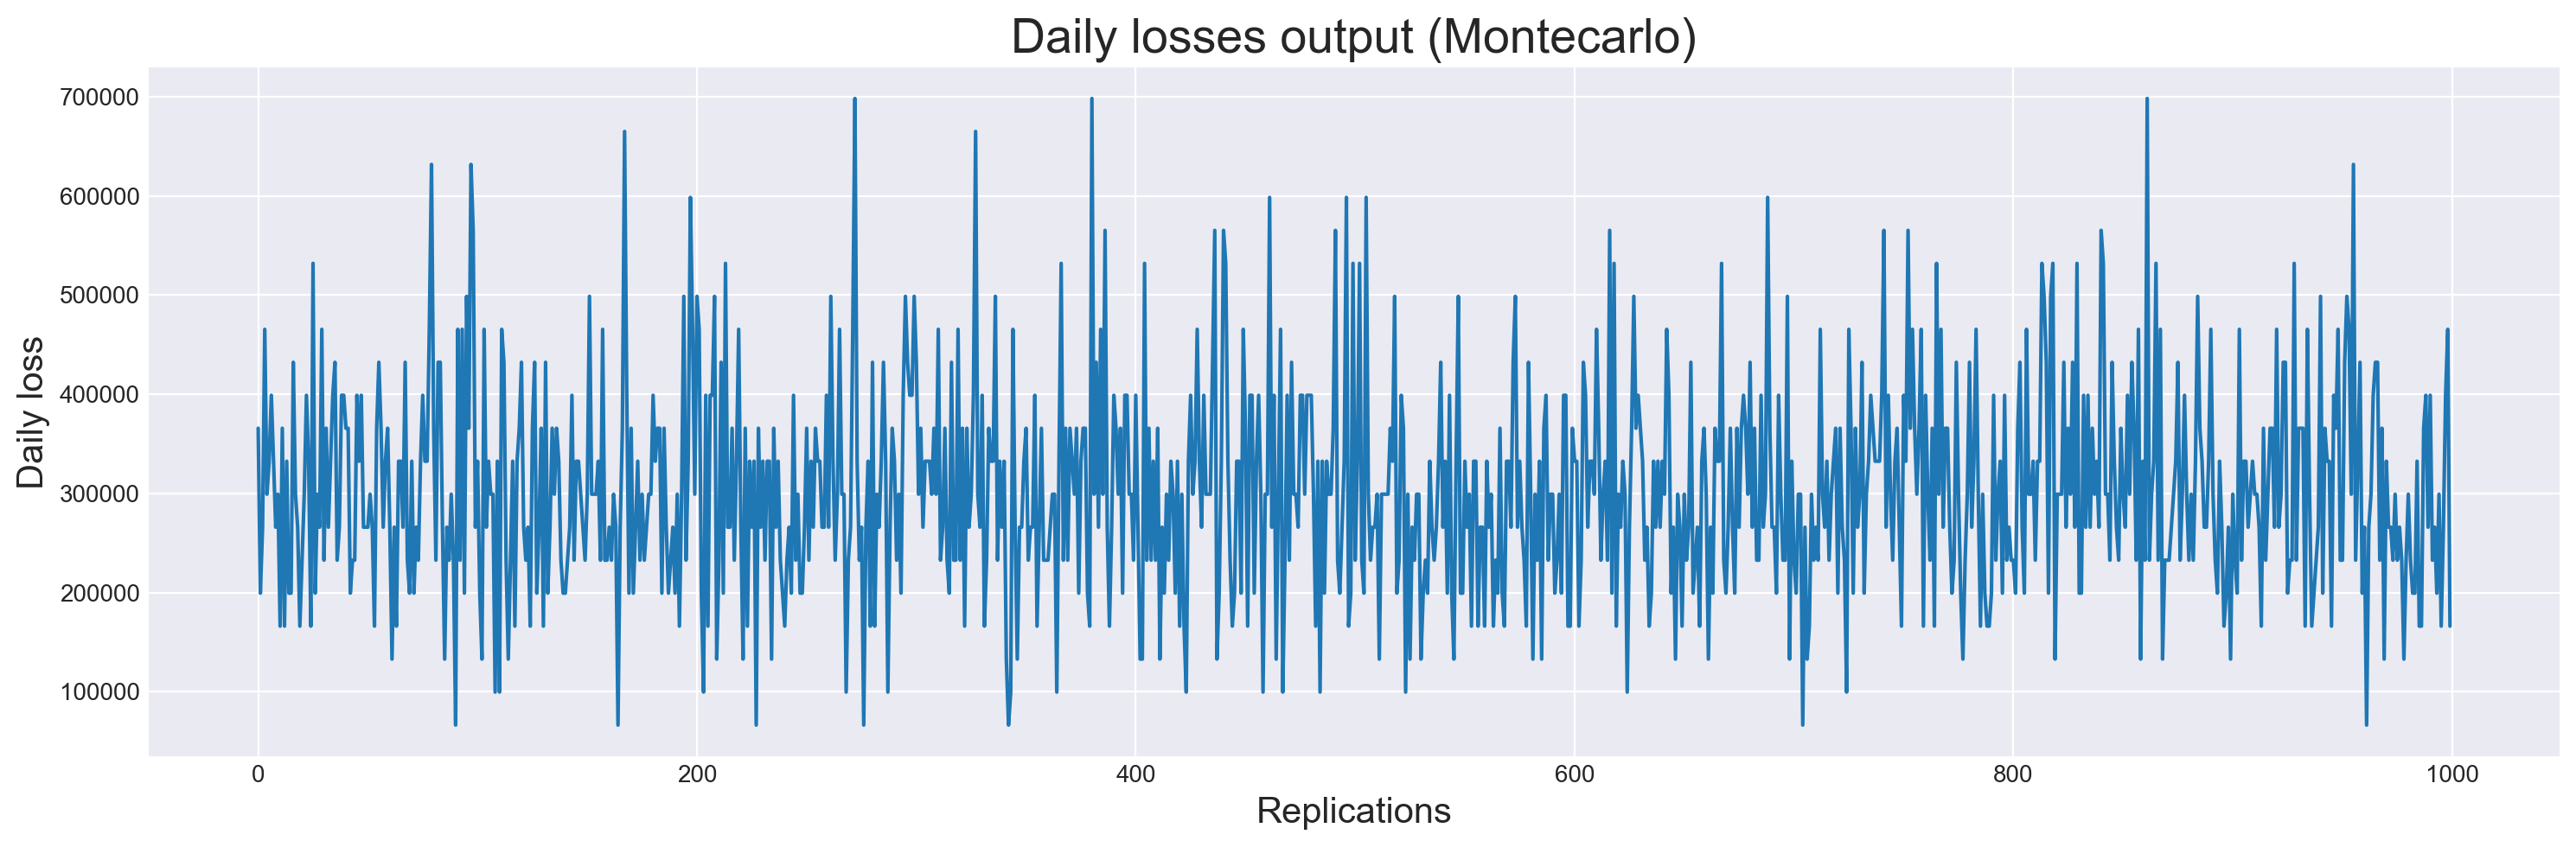

In [53]:
# plotting daily loss output from Montecarlo
daily_losses_output3 = daily_loss_obj3['daily_losses_output']['season 0']
plt.plot(pd.Series(daily_losses_output3))
plt.title('Daily losses output (Montecarlo)',size = 20)
plt.xlabel('Replications',size = 15)
plt.ylabel('Daily loss',size= 15)
plt.show()

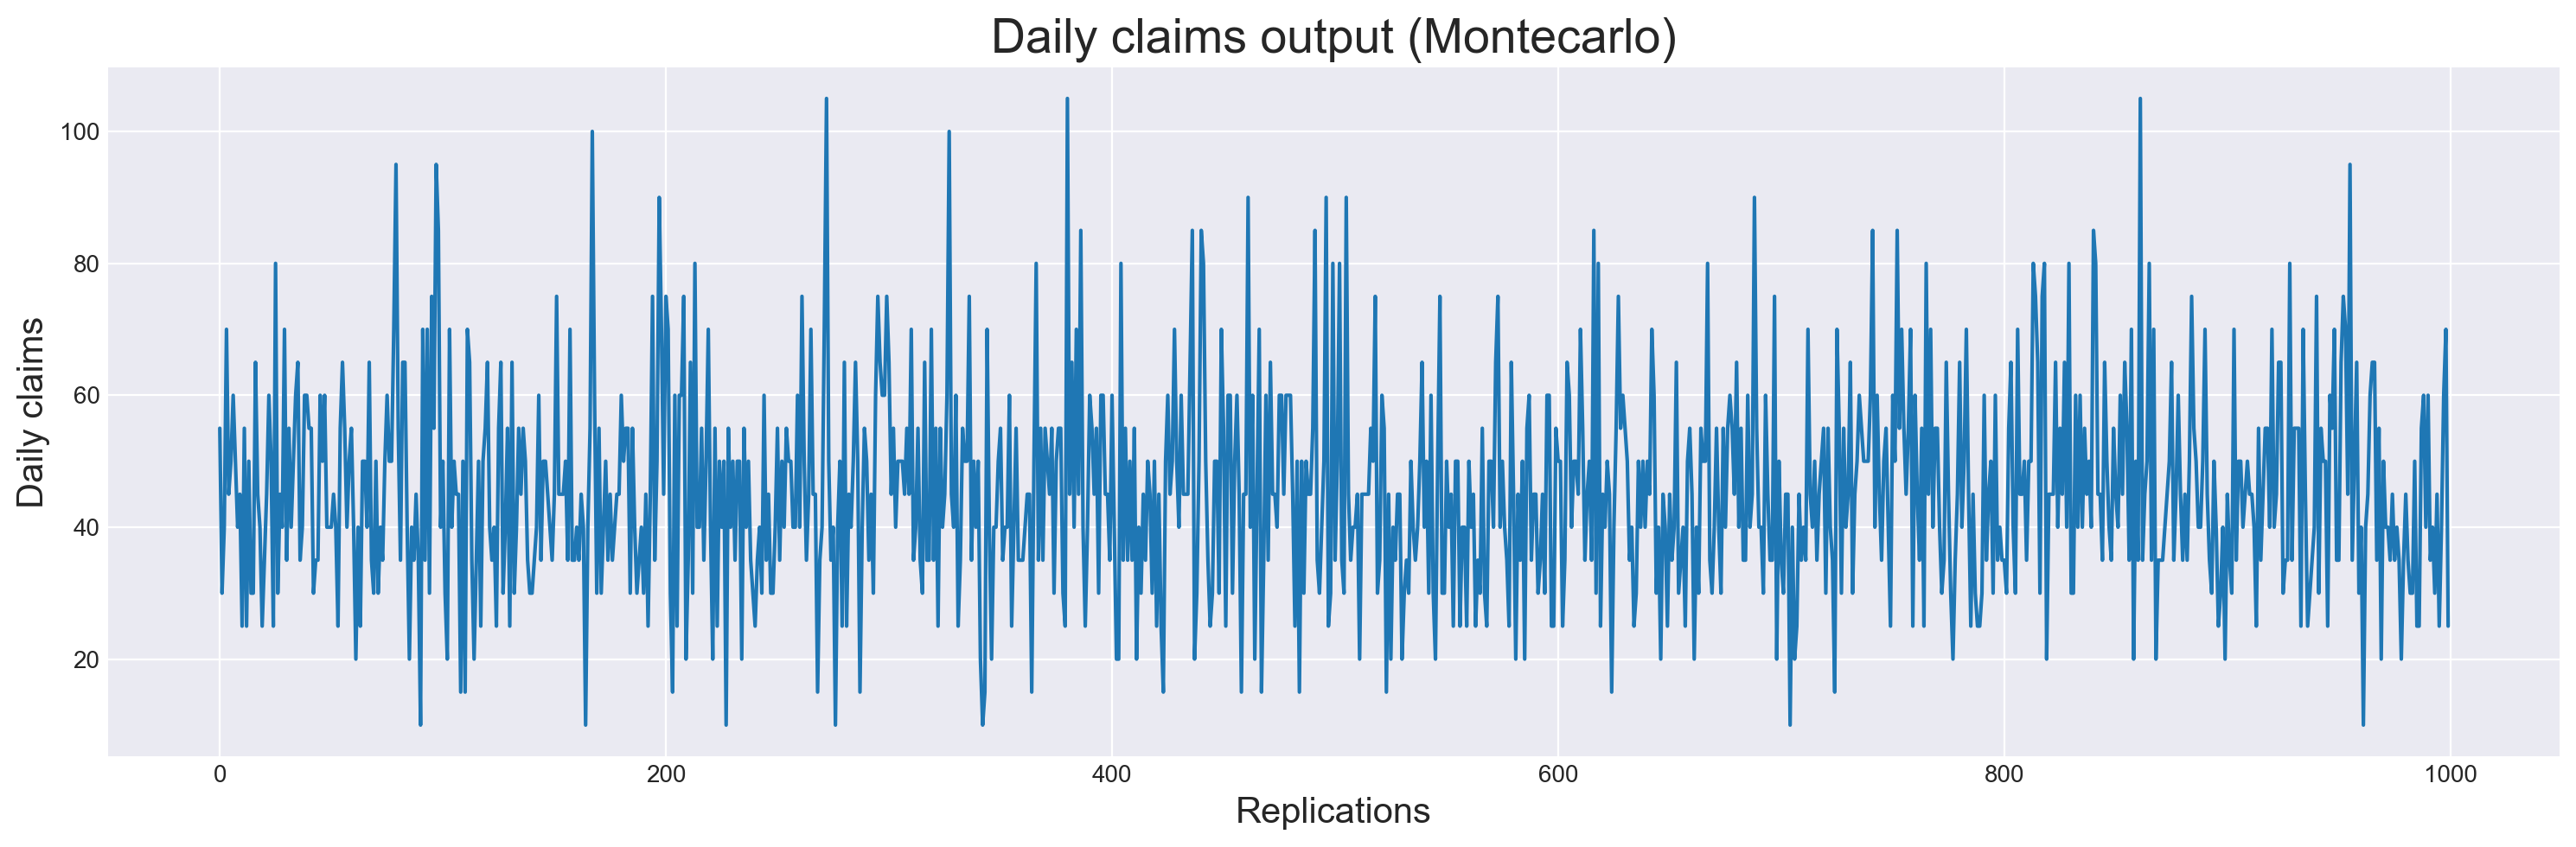

In [54]:
# plotting daily claims output from Montecarlo
daily_claims_output3 = daily_loss_obj3['daily_claims_output']['season 0']
plt.plot(pd.Series(daily_claims_output3))
plt.title('Daily claims output (Montecarlo)',size = 20)
plt.xlabel('Replications',size = 15)
plt.ylabel('Daily claims',size= 15)
plt.show()

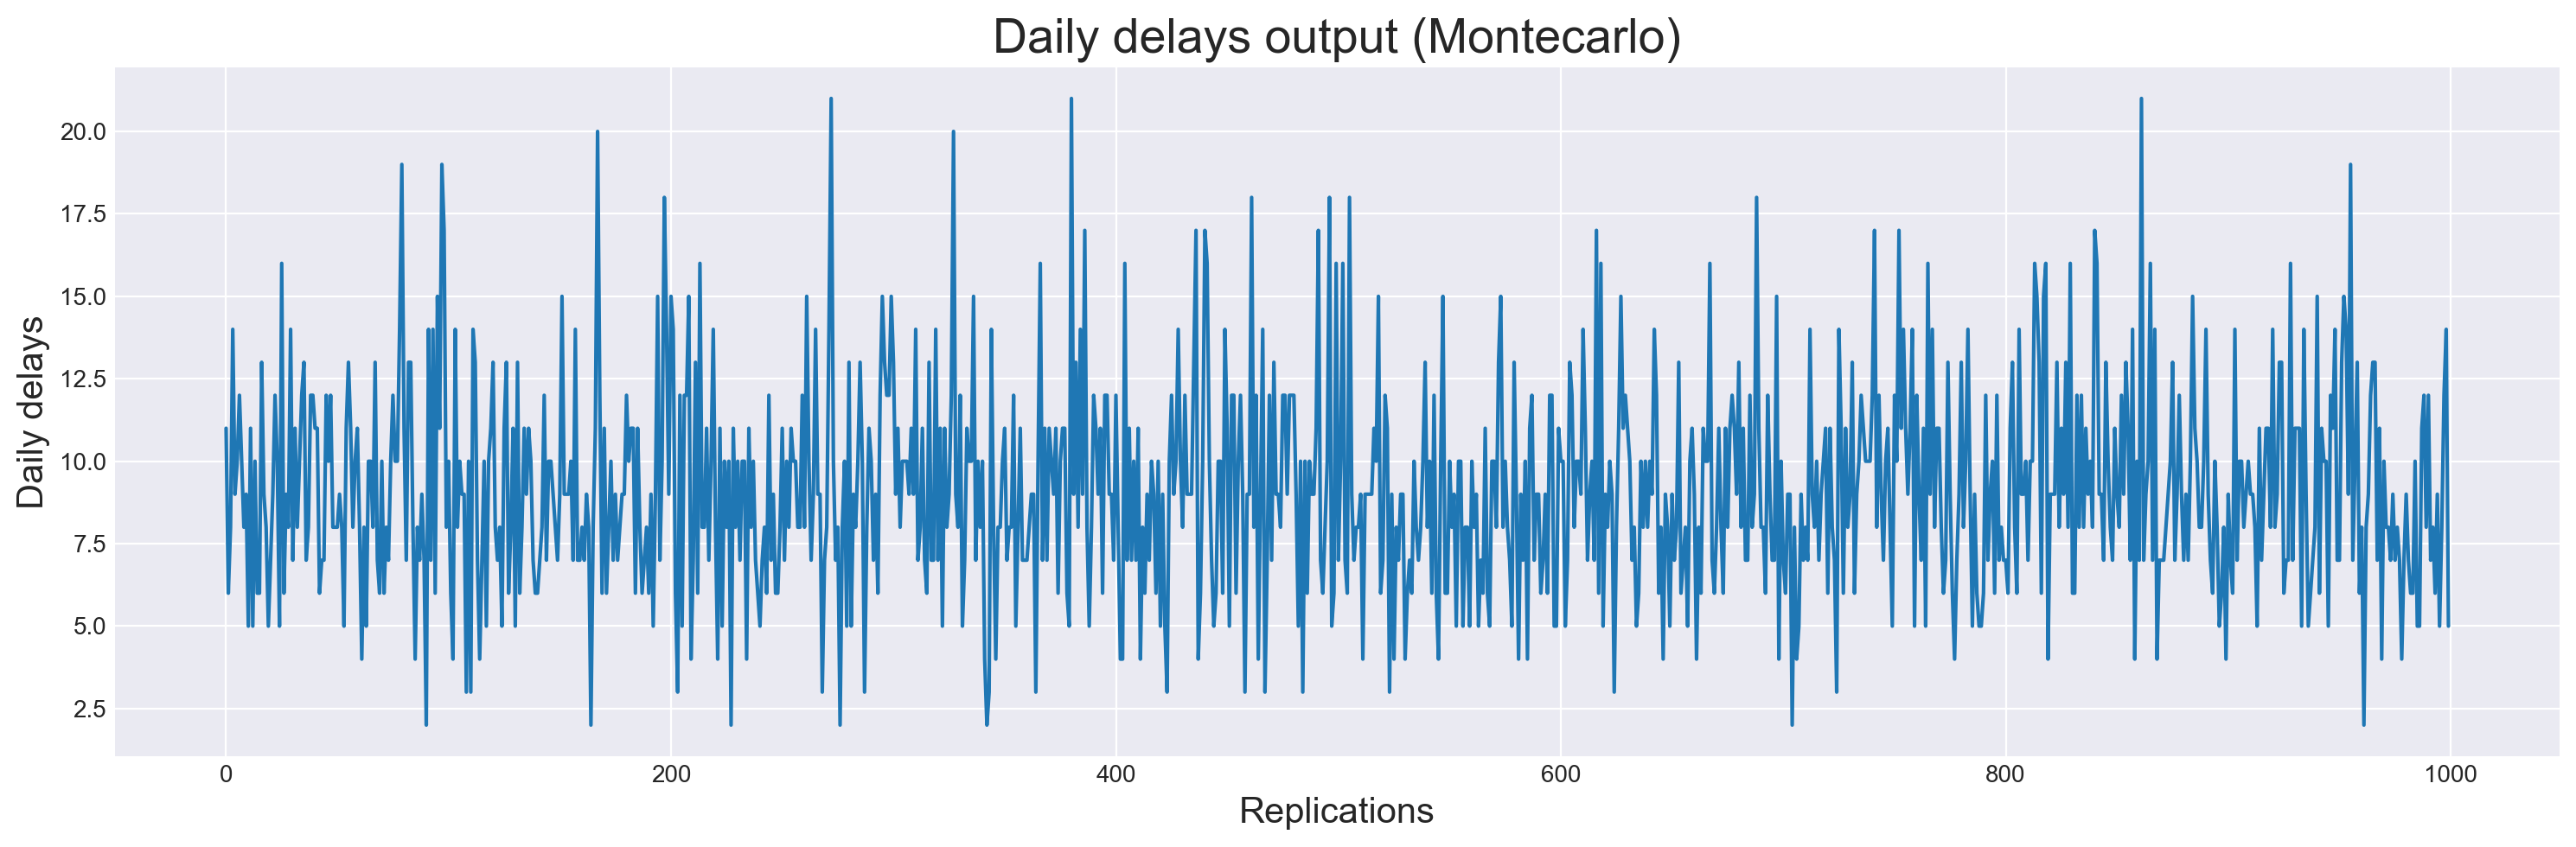

In [55]:
# plotting daily delays output from Montecarlo
daily_delays_output3 = daily_loss_obj3['daily_delays_values']['season 0']
plt.plot(pd.Series(daily_delays_output3))
plt.title('Daily delays output (Montecarlo)',size = 20)
plt.xlabel('Replications',size = 15)
plt.ylabel('Daily delays',size= 15)
plt.show()

In [56]:
seasonal_loss3 = loss3.seasonal_loss_compute([expected_daily_loss3]) # or loss3.seasonal_loss_compute(loss3.expected_daily_loss_in_season)
seasonal_loss3 = seasonal_loss3['season 0']
seasonal_loss3

110961980.65269639

In [57]:
year_2027_loss = loss3.yearly_loss_compute([seasonal_loss3]) # or loss3.yearly_loss_compute(loss3.expected_seasonal_loss)
year_2027_loss = year_2027_loss['yearly loss']
year_2027_loss

110961980.65269639

In [58]:
#  2027 daily claims 
daily_claims3 = loss3.expected_claims(time_frame = 'day')
daily_claims3

{'season 0': 45.715}

In [59]:
#  2027 seasonal claims 
seasonal_claims3 = loss3.expected_claims(time_frame = 'season')
seasonal_claims3

{'season 0': 16685.975000000002}

In [60]:
# 2027 yearly claims
year_2027_claims = loss3.expected_claims(time_frame = 'year')
year_2027_claims = round(year_2027_claims['year'])
year_2027_claims

16686

In [61]:
# dataframe capturing loss amount amount and expected number of claims in 2027
df_2027_lc = pd.DataFrame({'Year':[2027],'Loss':[year_2027_loss],'Claims' : [year_2027_claims]})
df_2027_lc

Year          Loss  Claims
0  2027  1.109620e+08   16686

<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:300px'> 2028 loss </h3>

In [62]:
benefit_2028 = benefit_estimates.loc[benefit_estimates.index == '2028-12-31'].values[0][0]
expected_daily_delays_in_a_season4 = [10]

In [63]:
loss4 = lgd(number_of_days = number_of_days,ratio_of_workers_to_population = ratio_of_workers_to_population,carrying_capacity = carrying_capacity,benefit = benefit_2028,expected_daily_delays_in_a_season = expected_daily_delays_in_a_season4)

In [64]:
daily_loss_obj4 = loss4.daily_loss_compute(1000)

In [65]:
expected_daily_loss4 = daily_loss_obj4['expected_daily_loss']['season 0']
expected_daily_loss4

378542.0451134836

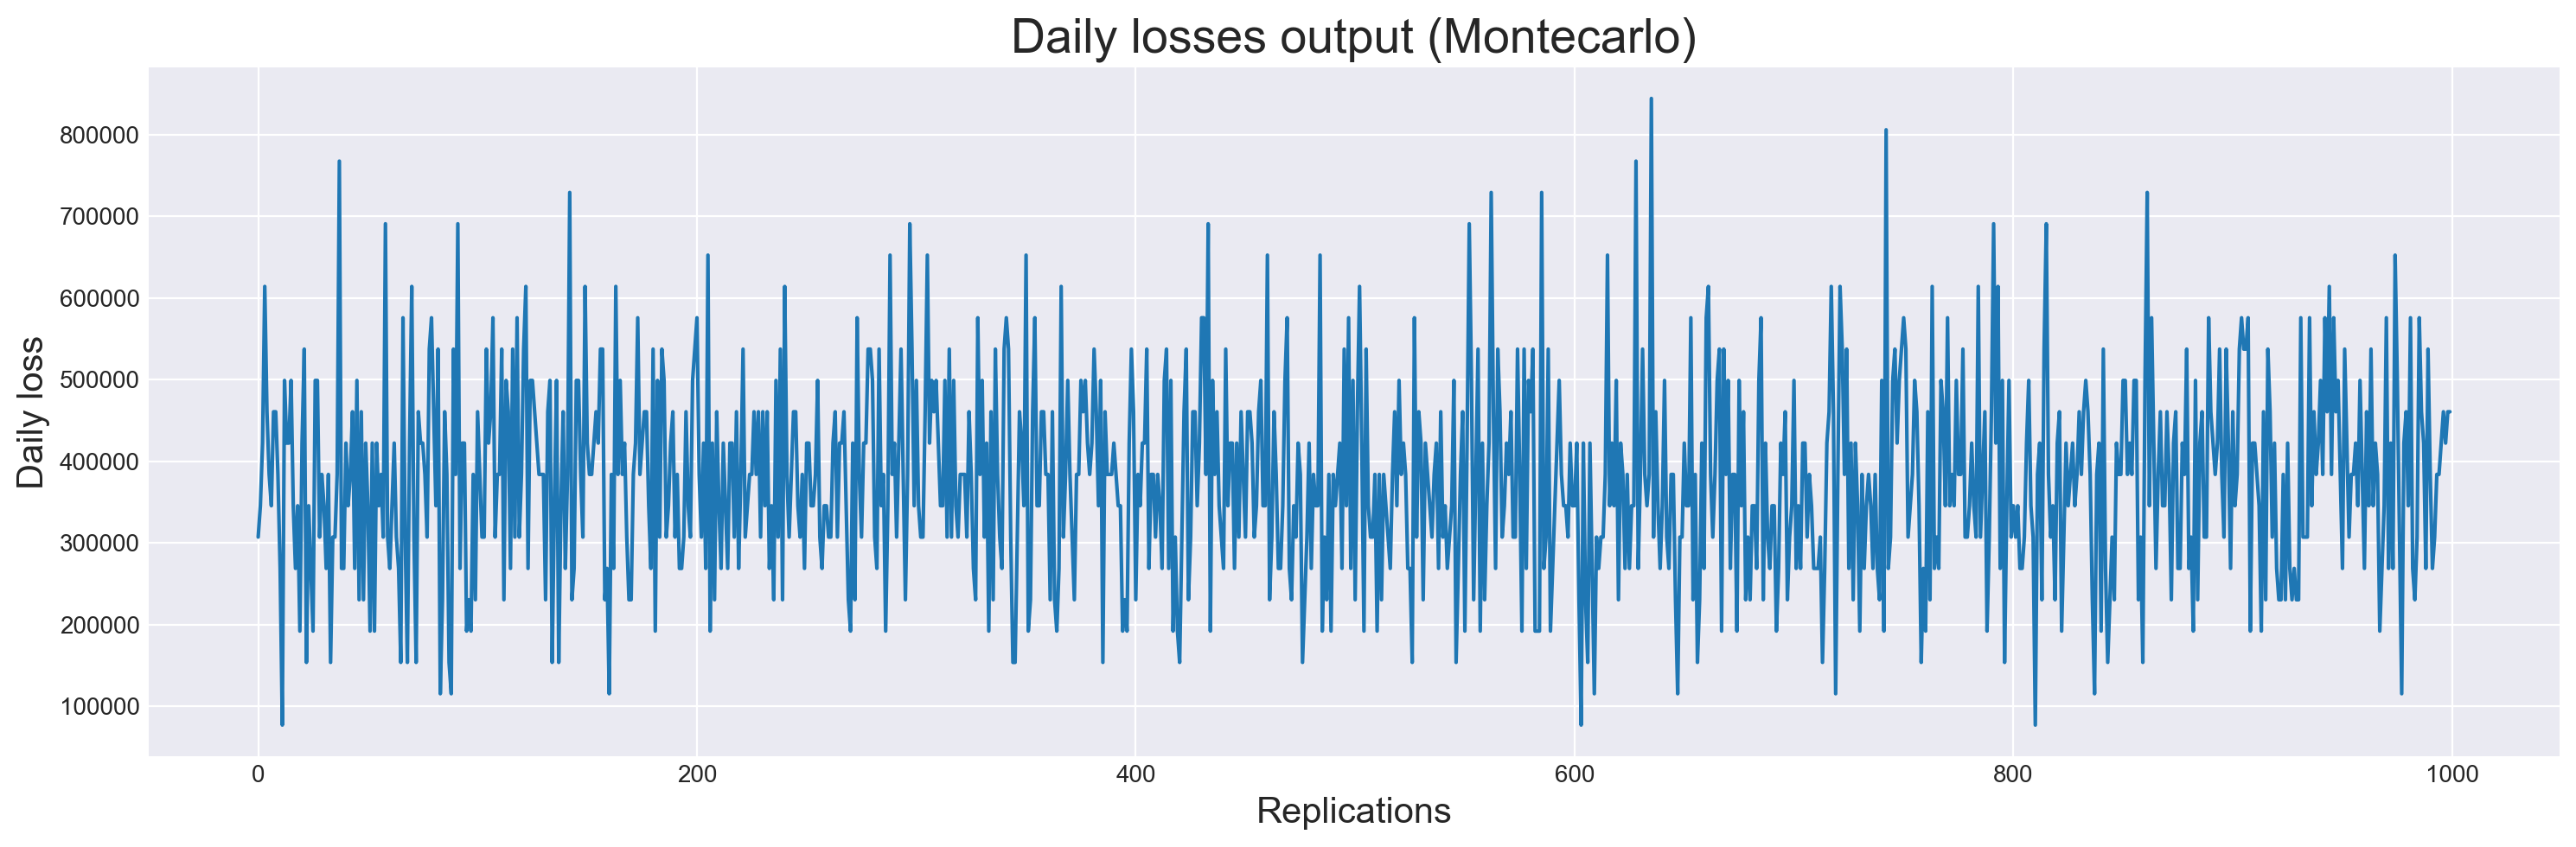

In [66]:
# plotting daily loss output from Montecarlo
daily_losses_output4 = daily_loss_obj4['daily_losses_output']['season 0']
plt.plot(pd.Series(daily_losses_output4))
plt.title('Daily losses output (Montecarlo)',size = 20)
plt.xlabel('Replications',size = 15)
plt.ylabel('Daily loss',size= 15)
plt.show()

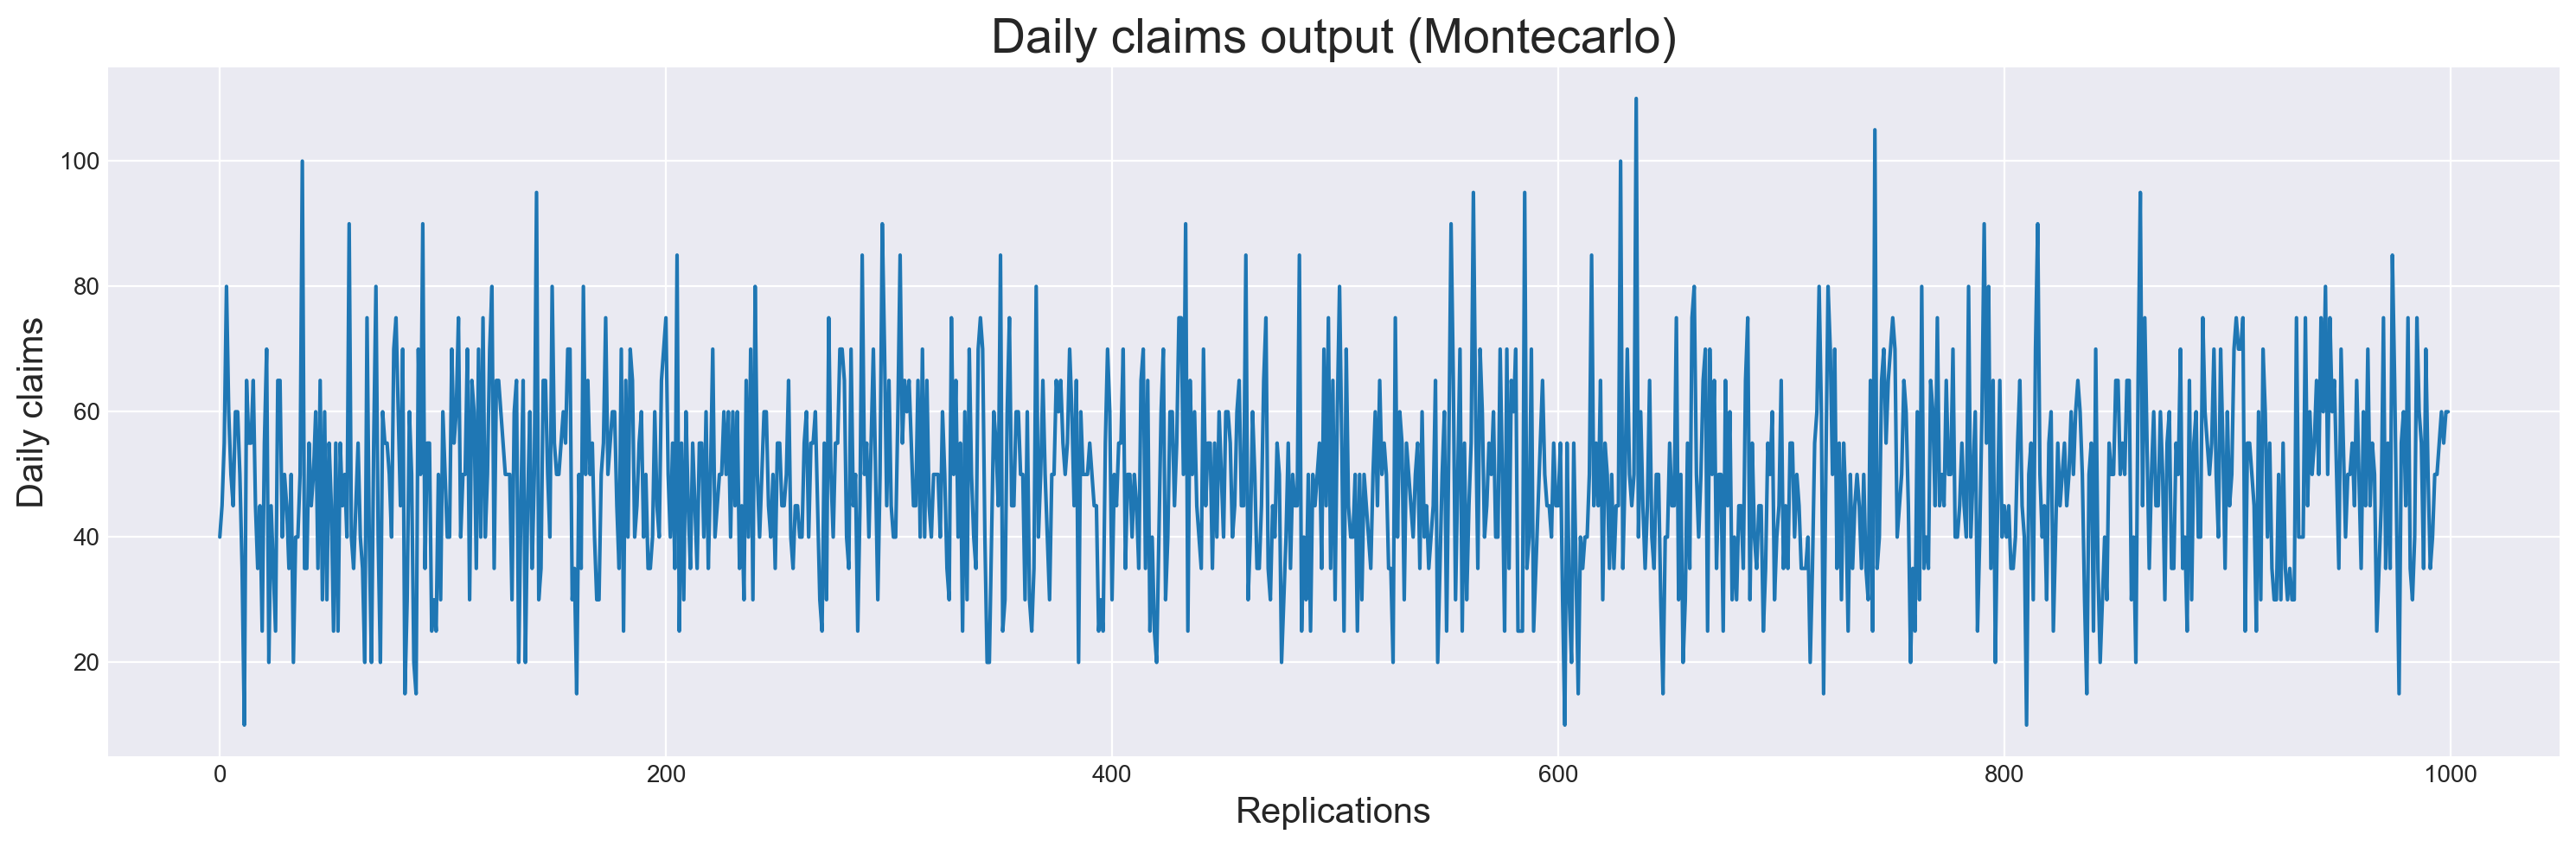

In [67]:
# plotting daily claims output from Montecarlo
daily_claims_output4 = daily_loss_obj4['daily_claims_output']['season 0']
plt.plot(pd.Series(daily_claims_output4))
plt.title('Daily claims output (Montecarlo)',size = 20)
plt.xlabel('Replications',size = 15)
plt.ylabel('Daily claims',size= 15)
plt.show()

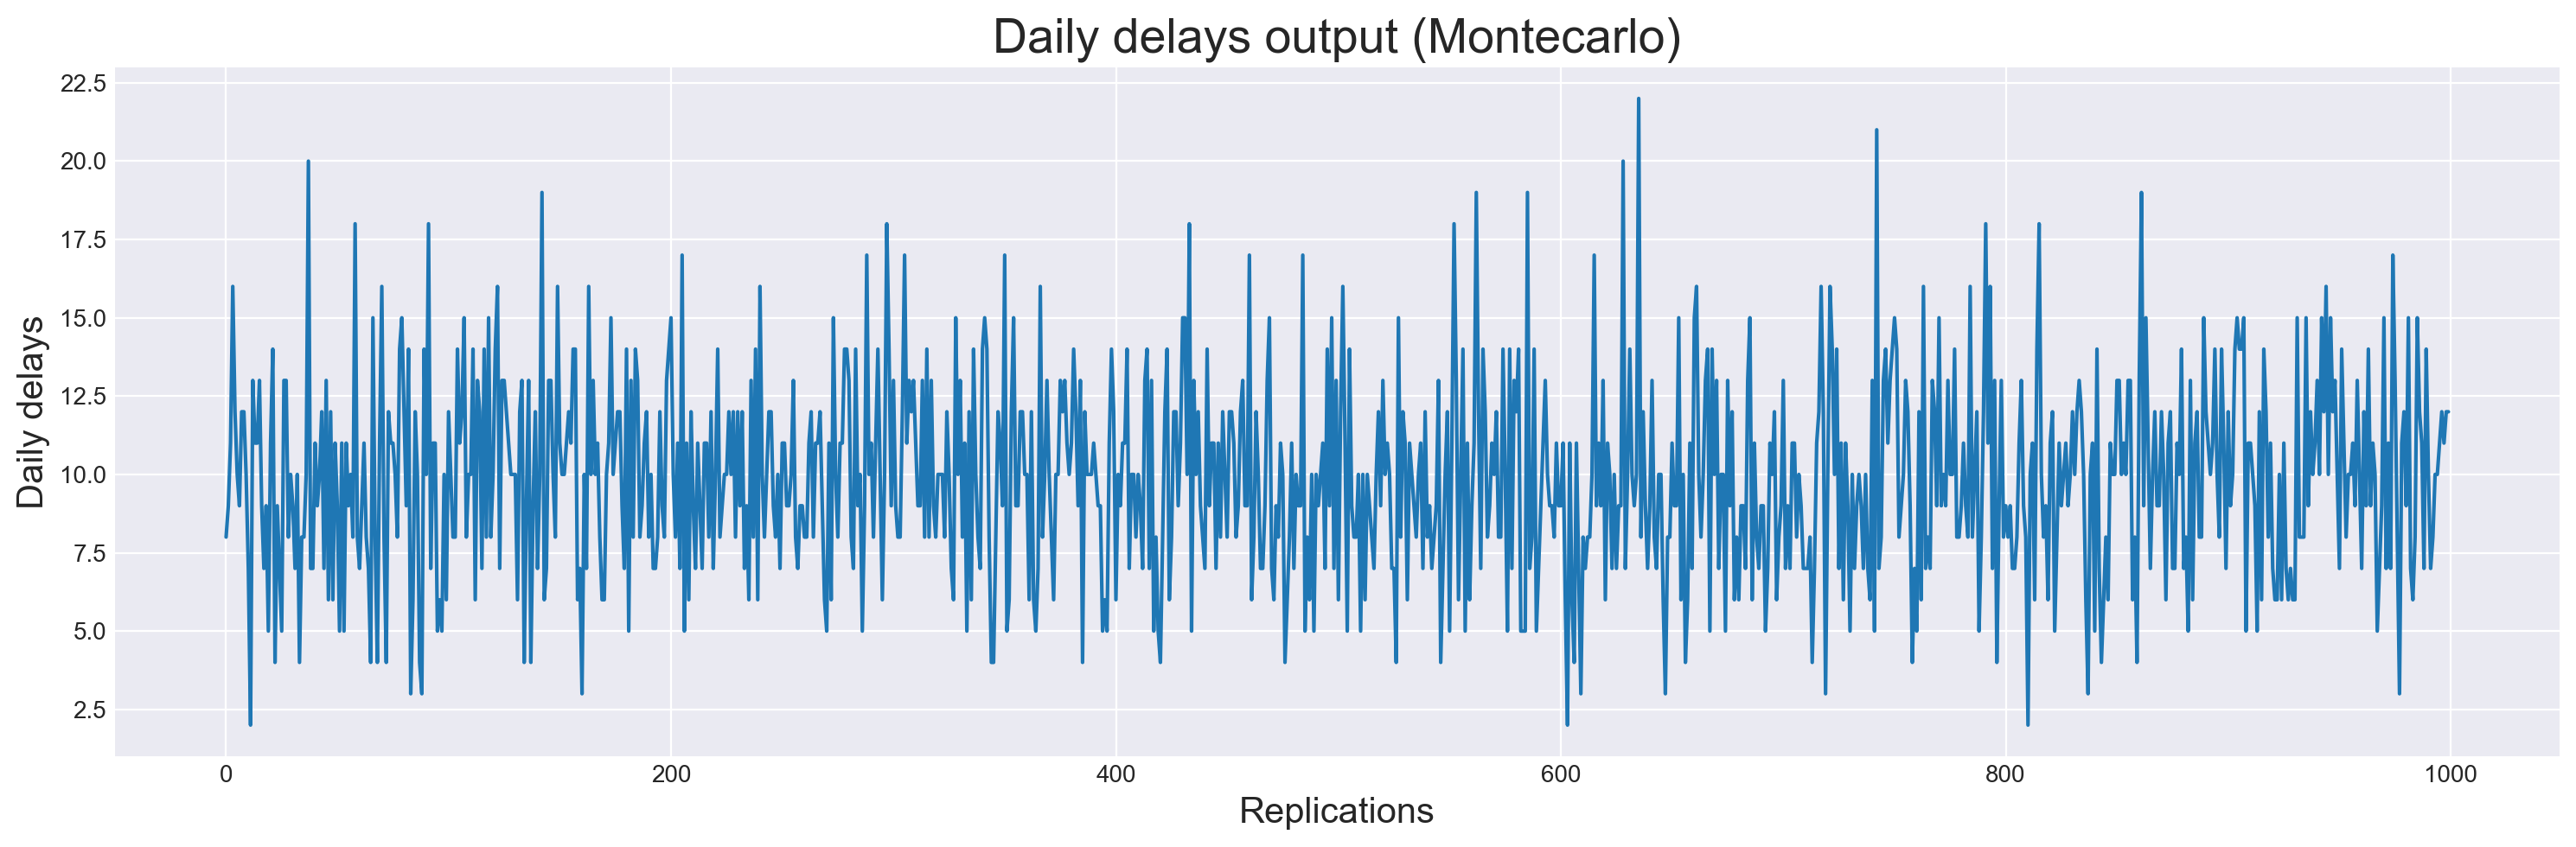

In [68]:
# plotting daily delays output from Montecarlo
daily_delays_output4 = daily_loss_obj4['daily_delays_values']['season 0']
plt.plot(pd.Series(daily_delays_output4))
plt.title('Daily delays output (Montecarlo)',size = 20)
plt.xlabel('Replications',size = 15)
plt.ylabel('Daily delays',size= 15)
plt.show()

In [69]:
seasonal_loss4 = loss4.seasonal_loss_compute([expected_daily_loss4]) # or loss4.seasonal_loss_compute(loss4.expected_daily_loss_in_season)
seasonal_loss4 = seasonal_loss4['season 0']
seasonal_loss4

138167846.4664215

In [70]:
year_2028_loss = loss4.yearly_loss_compute([seasonal_loss4]) # or loss4.yearly_loss_compute(loss4.expected_seasonal_loss)
year_2028_loss = year_2028_loss['yearly loss']
year_2028_loss

138167846.4664215

In [71]:
# 2028 daily claims 
daily_claims4 = loss4.expected_claims(time_frame = 'day')
daily_claims4

{'season 0': 49.3}

In [72]:
# 2028 seasonal claims 
seasonal_claims4 = loss4.expected_claims(time_frame = 'season')
seasonal_claims4

{'season 0': 17994.5}

In [73]:
# 2028 yearly claims 
year_2028_claims = loss4.expected_claims(time_frame = 'year')
year_2028_claims = round(year_2028_claims['year'])
year_2028_claims

17994

In [74]:
# dataframe capturing loss amount amount and expected number of claims in 2028
df_2028_lc = pd.DataFrame({'Year':[2028],'Loss':[year_2028_loss],'Claims' : [year_2028_claims]})
df_2028_lc

Year          Loss  Claims
0  2028  1.381678e+08   17994

<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:300px'> 2029 loss </h3>

In [75]:
benefit_2029 = benefit_estimates.loc[benefit_estimates.index == '2029-12-31'].values[0][0]
expected_daily_delays_in_a_season5 = [11]

In [76]:
loss5 = lgd(number_of_days = number_of_days,ratio_of_workers_to_population = ratio_of_workers_to_population,carrying_capacity = carrying_capacity,benefit = benefit_2029,expected_daily_delays_in_a_season = expected_daily_delays_in_a_season5)

In [77]:
daily_loss_obj5 = loss5.daily_loss_compute(1000)

In [78]:
expected_daily_loss5 = daily_loss_obj5['expected_daily_loss']['season 0']
expected_daily_loss5

484503.14220884925

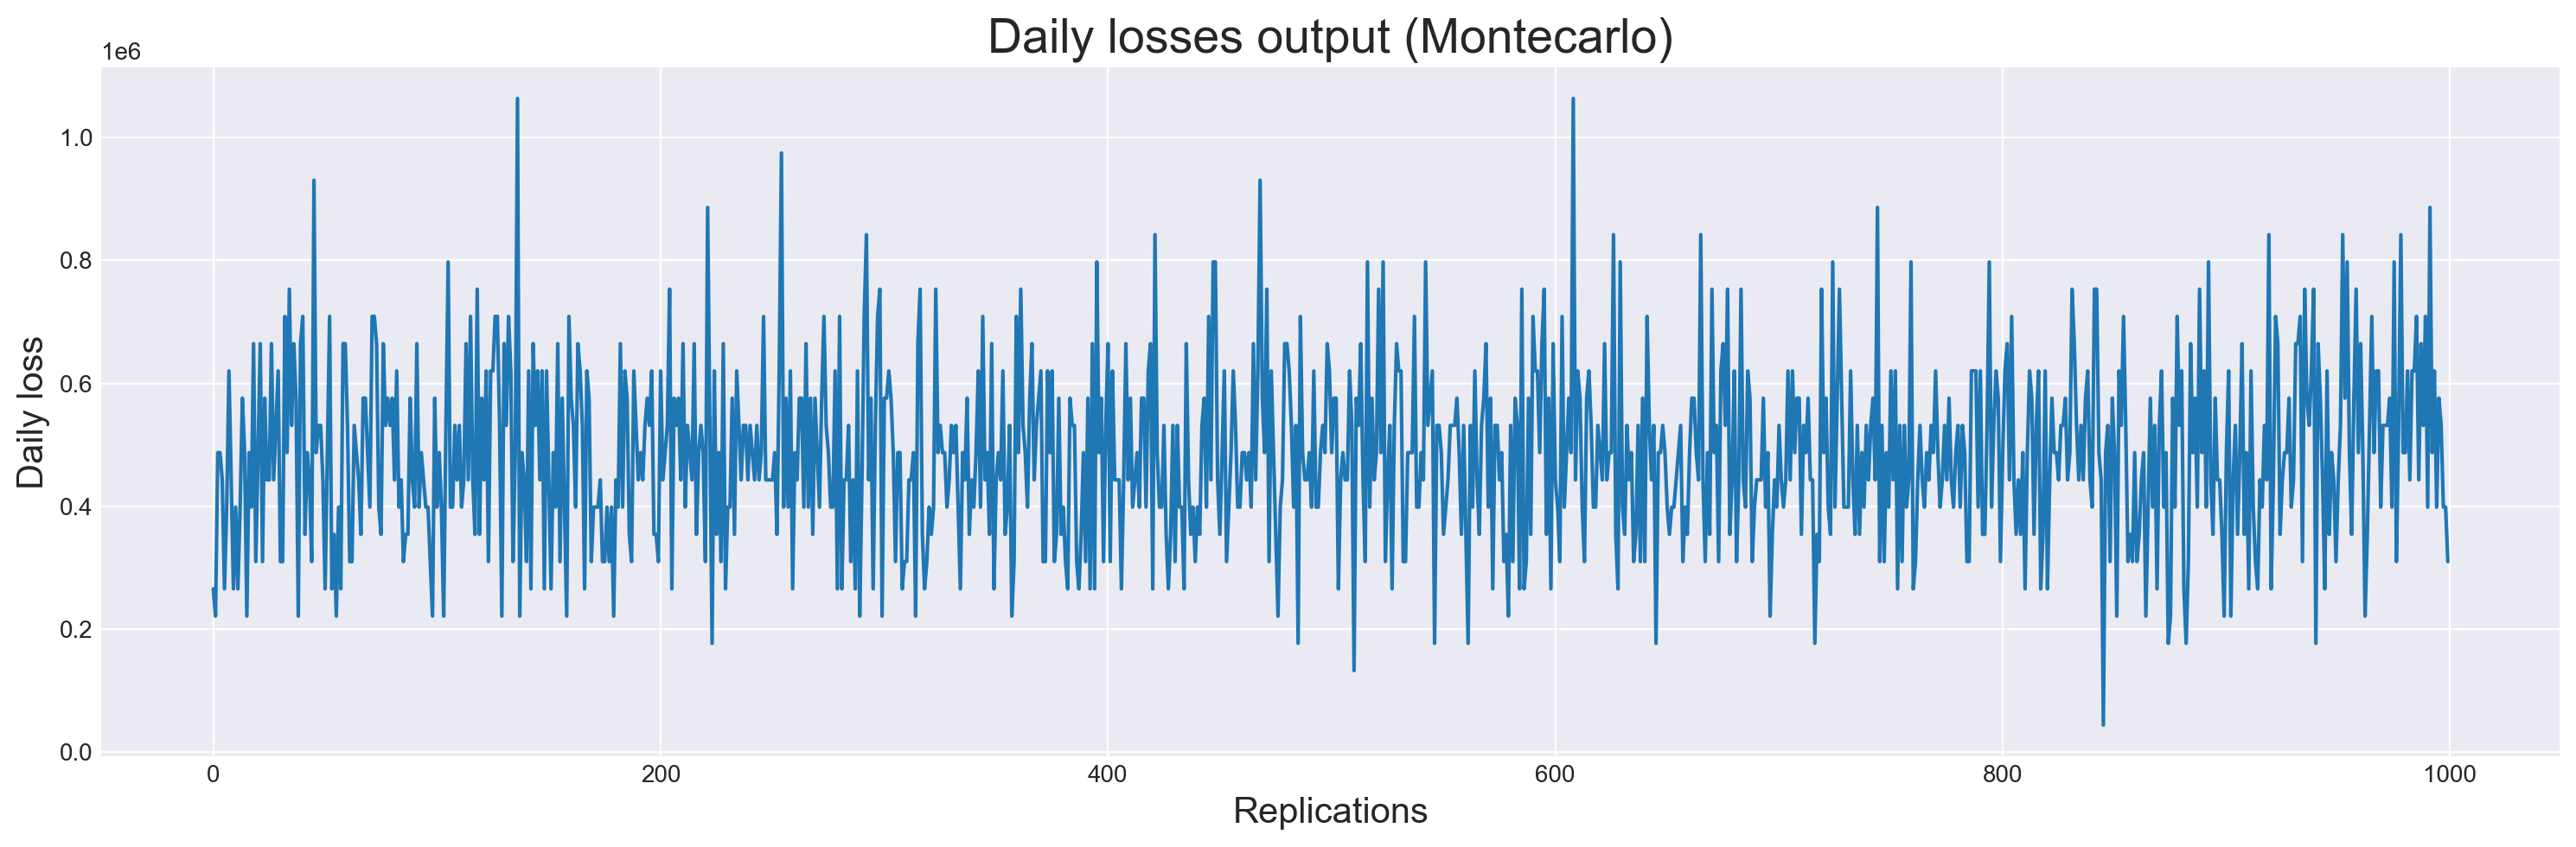

In [79]:
# plotting daily loss output from Montecarlo
daily_losses_output5 = daily_loss_obj5['daily_losses_output']['season 0']
plt.plot(pd.Series(daily_losses_output5))
plt.title('Daily losses output (Montecarlo)',size = 20)
plt.xlabel('Replications',size = 15)
plt.ylabel('Daily loss',size= 15)
plt.show()

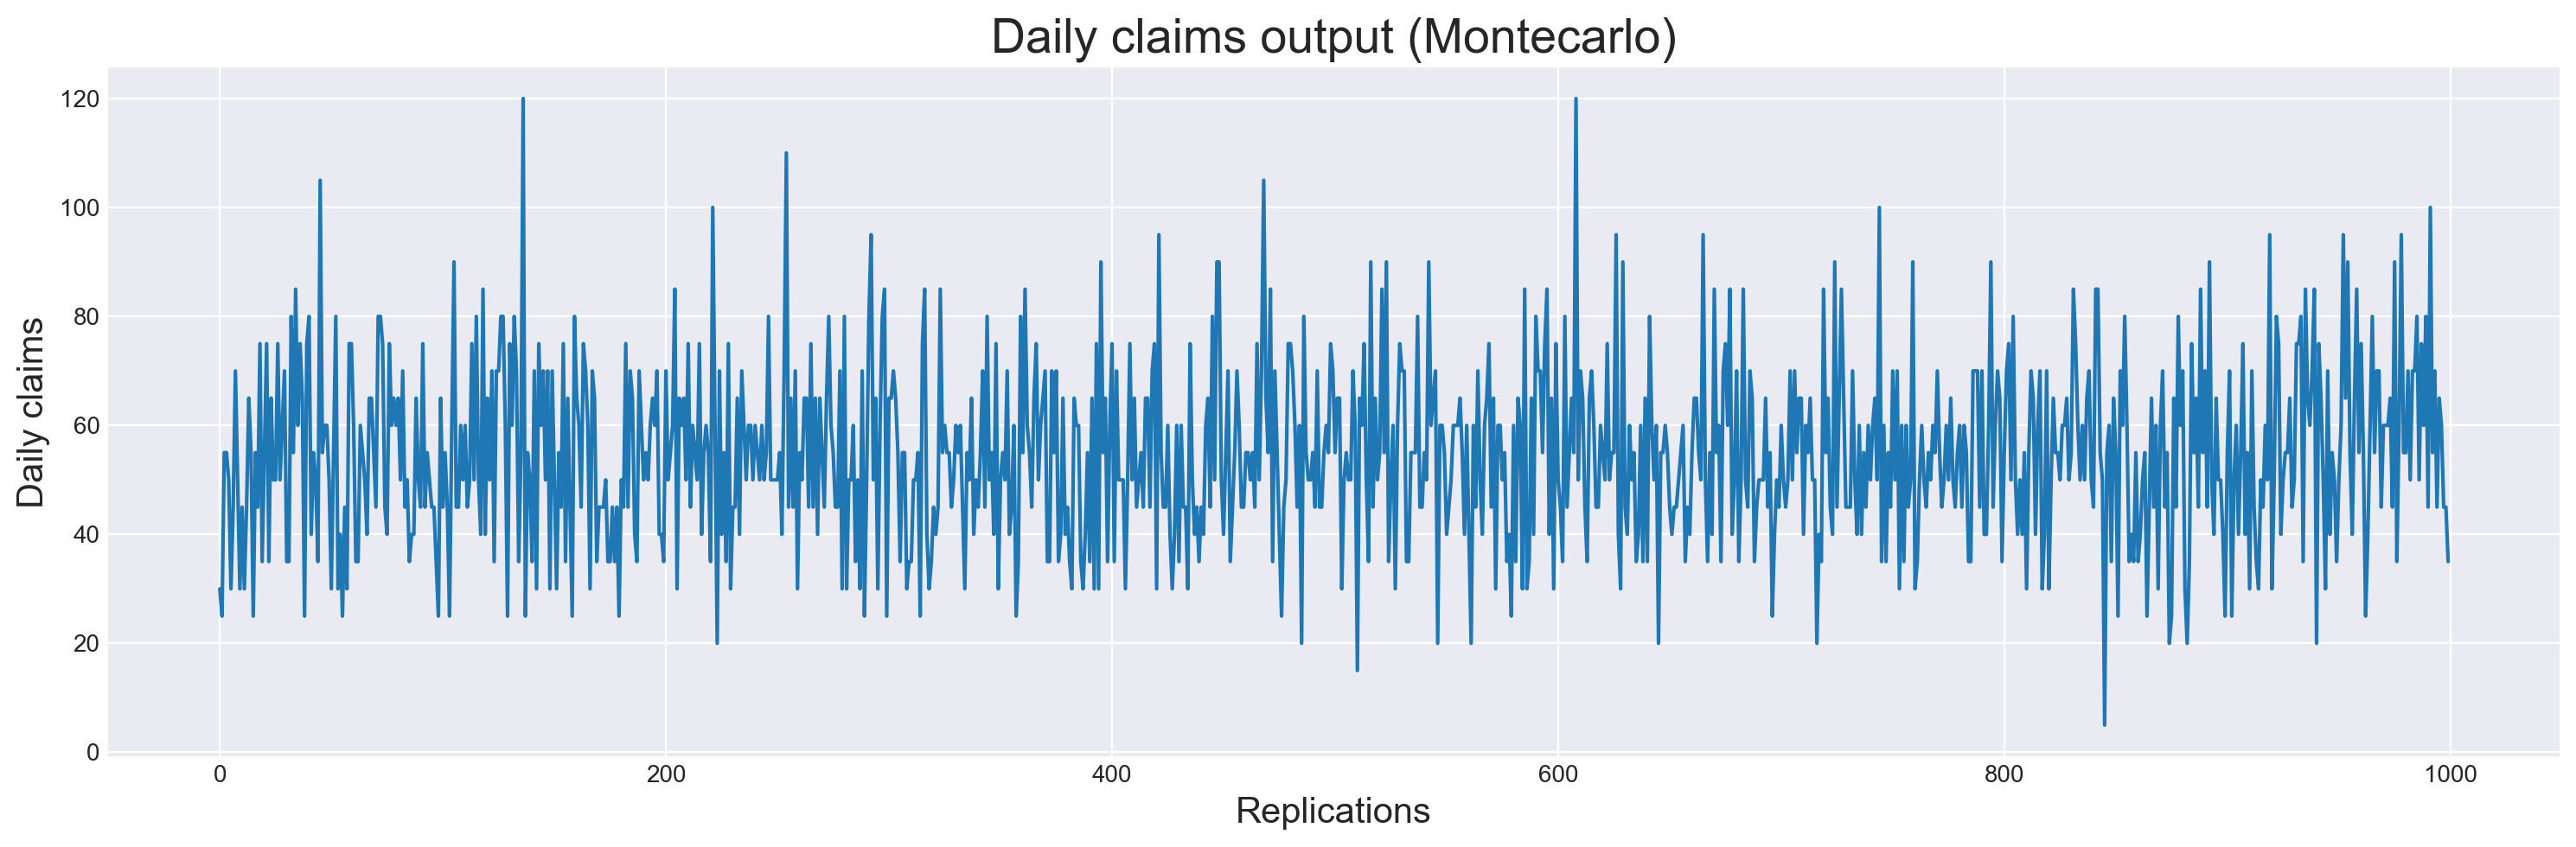

In [80]:
# plotting daily claims output from Montecarlo
daily_claims_output5 = daily_loss_obj5['daily_claims_output']['season 0']
plt.plot(pd.Series(daily_claims_output5))
plt.title('Daily claims output (Montecarlo)',size = 20)
plt.xlabel('Replications',size = 15)
plt.ylabel('Daily claims',size= 15)
plt.show()

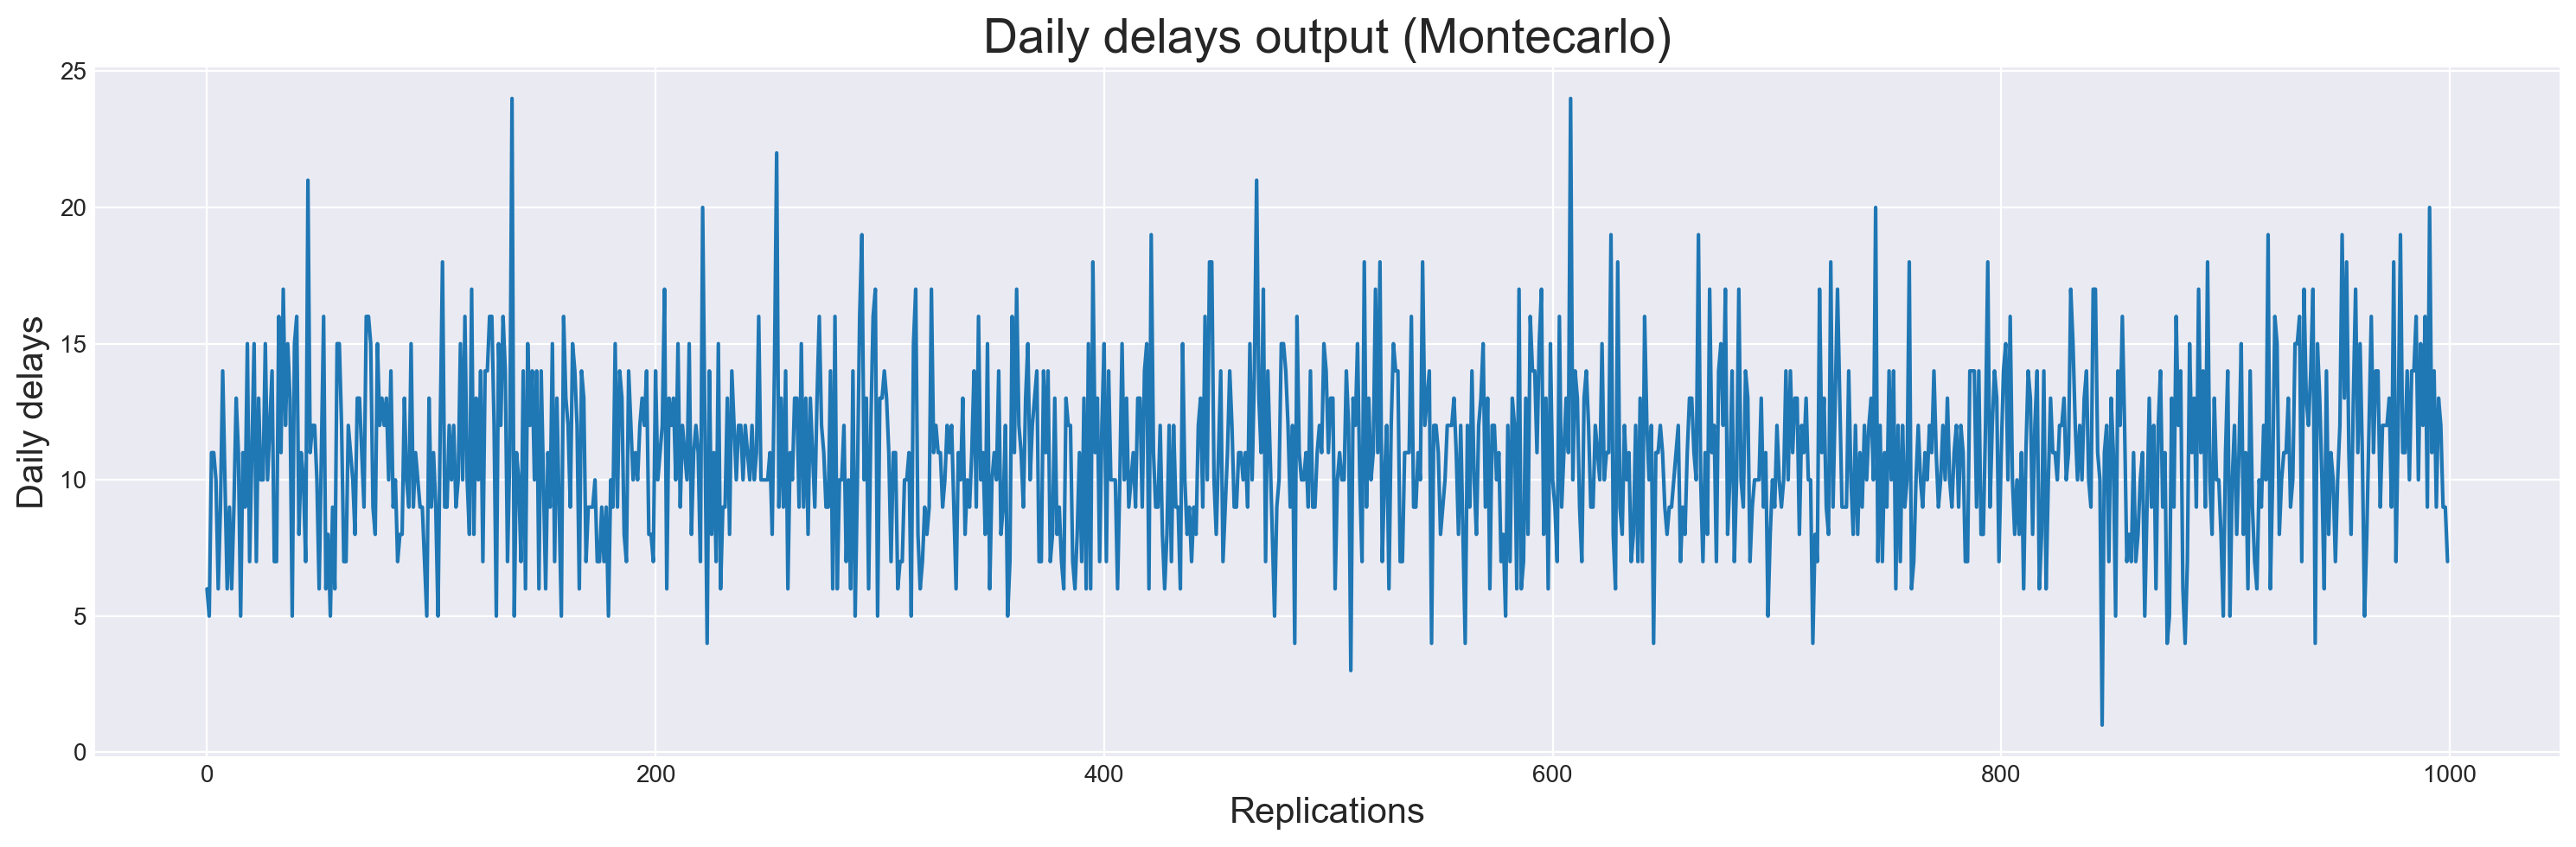

In [81]:
# plotting daily delays output from Montecarlo
daily_delays_output5 = daily_loss_obj5['daily_delays_values']['season 0']
plt.plot(pd.Series(daily_delays_output5))
plt.title('Daily delays output (Montecarlo)',size = 20)
plt.xlabel('Replications',size = 15)
plt.ylabel('Daily delays',size= 15)
plt.show()

In [82]:
seasonal_loss5 = loss5.seasonal_loss_compute([expected_daily_loss5]) # or loss5.seasonal_loss_compute(loss5.expected_daily_loss_in_season)
seasonal_loss5 = seasonal_loss5['season 0']
seasonal_loss5

176843646.90622997

In [83]:
year_2029_loss = loss5.yearly_loss_compute([seasonal_loss5]) # or loss5.yearly_loss_compute(loss5.expected_seasonal_loss)
year_2029_loss = year_2029_loss['yearly loss']
year_2029_loss

176843646.90622997

In [84]:
# 2029 daily claims 
daily_claims5 = loss5.expected_claims(time_frame = 'day')
daily_claims5

{'season 0': 54.66}

In [85]:
# 2029 seasonal claims 
seasonal_claims5 = loss5.expected_claims(time_frame = 'season')
seasonal_claims5

{'season 0': 19950.899999999998}

In [86]:
# 2029 yearly claims 
year_2029_claims = loss5.expected_claims(time_frame = 'year')
year_2029_claims = round(year_2029_claims['year'])
year_2029_claims

19951

In [87]:
# dataframe capturing loss amount amount and expected number of claims in 2029
df_2029_lc = pd.DataFrame({'Year':[2029],'Loss':[year_2029_loss],'Claims' : [year_2029_claims]})
df_2029_lc

Year          Loss  Claims
0  2029  1.768436e+08   19951

<h2 style = 'background-color:teal;padding:10px;color:white;border-radius:10px;text-align:center;margin-left:150px;margin-right:170px;'> Gross premium calculation </h2>

In [88]:
# concatination of loss and claims dataframes
lc_df = pd.concat([df_2025_lc,df_2026_lc,df_2027_lc,df_2028_lc,df_2029_lc])
lc_df.index = lc_df.Year
lc_df.drop('Year',axis = 'columns',inplace = True)
lc_df

Loss  Claims
Year                      
2025  6.134717e+07   12306
2026  8.360856e+07   14520
2027  1.109620e+08   16686
2028  1.381678e+08   17994
2029  1.768436e+08   19951

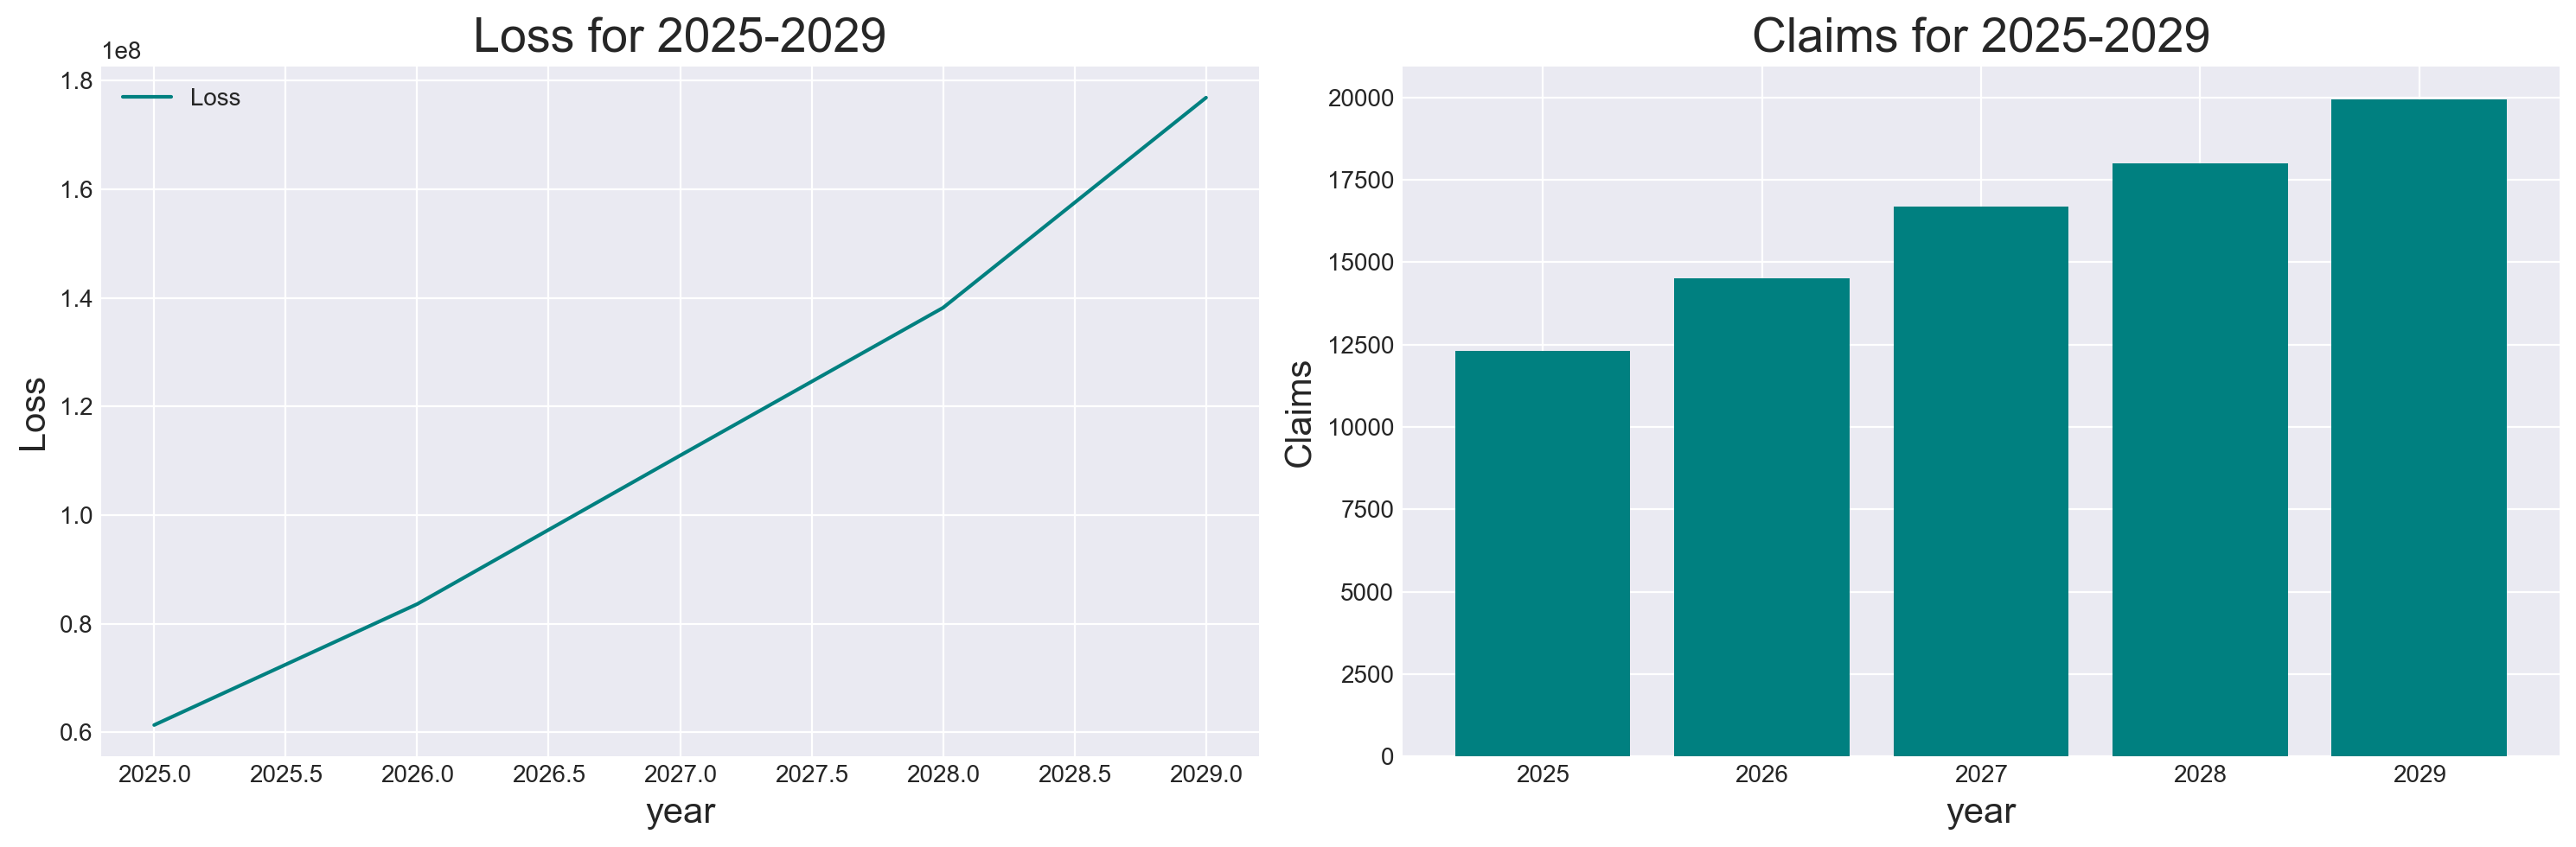

In [89]:
a,(ax,ax2) = plt.subplots(1,2)
ax.plot(lc_df.Loss,label = 'Loss',color = 'teal')
ax.set_title('Loss for 2025-2029',size = 20)
ax.set_xlabel('year',size = 15)
ax.set_ylabel('Loss',size =15)
ax.legend()
plt.bar(list(lc_df.index),list(lc_df.Claims.values),color = 'teal')
ax2.set_title('Claims for 2025-2029',size = 20)
ax2.set_xlabel('year',size = 15)
ax2.set_ylabel('Claims',size =15)
plt.show()

<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:300px'> Pure premium calculation </h3>

#### Pure premium = loss / number of exposures

In [90]:
# loading population data, it will help in calculation of number of exposures
population = pd.read_csv('population.csv',sep = '\t')
population.head(14)

Macrotrends Data Download
0             Malawi Population Growth Rate 1950-2023
1   Original Source: United Nations - World Popula...
2   DISCLAIMER AND TERMS OF USE: HISTORICAL DATA I...
3   FOR INFORMATIONAL PURPOSES - NOT FOR TRADING P...
4   NEITHER MACROTRENDS LLC NOR ANY OF OUR INFORMA...
5   FOR ANY DAMAGES RELATING TO YOUR USE OF THE DA...
6   ATTRIBUTION: Proper attribution requires clear...
7   A "dofollow" backlink to the originating page ...
8                date, Population, Annual Growth Rate
9                                  1950-12-31,2949739
10                            1951-12-31,3001113,1.74
11                            1952-12-31,3056297,1.84
12                            1953-12-31,3114930,1.92
13                            1954-12-31,3176123,1.96

In [91]:
# cleaning data

In [92]:
population[8::]['Macrotrends Data Download'].str.split(',')

8      [date,  Population,  Annual Growth Rate]
9                         [1950-12-31, 2949739]
10                  [1951-12-31, 3001113, 1.74]
11                  [1952-12-31, 3056297, 1.84]
12                  [1953-12-31, 3114930, 1.92]
                         ...                   
155                [2096-12-31, 57624469, 0.43]
156                [2097-12-31, 57861503, 0.41]
157                 [2098-12-31, 58090181, 0.4]
158                [2099-12-31, 58310462, 0.38]
159                [2100-12-31, 58521719, 0.36]
Name: Macrotrends Data Download, Length: 152, dtype: object

In [93]:
population = pd.DataFrame([[r for r in i] for i in population[8::]['Macrotrends Data Download'].str.split(',')])
population.head()

0            1                    2
0        date   Population   Annual Growth Rate
1  1950-12-31      2949739                 None
2  1951-12-31      3001113                 1.74
3  1952-12-31      3056297                 1.84
4  1953-12-31      3114930                 1.92

In [94]:
population.columns = population.iloc[0:1:,::].values[0]
population.drop(0,axis = 'rows',inplace = True)

In [95]:
population.drop(' Annual Growth Rate',axis = 'columns',inplace = True) # only interested in population

In [96]:
population.head()

date  Population
1  1950-12-31     2949739
2  1951-12-31     3001113
3  1952-12-31     3056297
4  1953-12-31     3114930
5  1954-12-31     3176123

In [97]:
population.index = population.date
population.index = pd.to_datetime(population.index)

In [98]:
population.drop('date',axis = 'columns',inplace = True)

In [99]:
population.head()

Population
date                  
1950-12-31     2949739
1951-12-31     3001113
1952-12-31     3056297
1953-12-31     3114930
1954-12-31     3176123

In [100]:
population = population.loc[(population.index >= '2024-12-31') & (population.index <= '2029-12-31')]

In [101]:
population

Population
date                  
2024-12-31    21475962
2025-12-31    22033992
2026-12-31    22601151
2027-12-31    23176271
2028-12-31    23758548
2029-12-31    24347875

#### Assumption : ratio of workers to population (0.1) remains the same throughtout

#### Formula : number of exposures = population * ratio of workers to population

In [102]:
# Exposures dataframe arrived after converting the population values to numeric and multiplying them by 0.1
exposures = pd.DataFrame({'Exposures' : [round(m) for m in np.array([int(i) for i in list(population[' Population'].values)]) * 0.1]},index = population.index)
exposures

Exposures
date                 
2024-12-31    2147596
2025-12-31    2203399
2026-12-31    2260115
2027-12-31    2317627
2028-12-31    2375855
2029-12-31    2434788

In [103]:
lc_df

Loss  Claims
Year                      
2025  6.134717e+07   12306
2026  8.360856e+07   14520
2027  1.109620e+08   16686
2028  1.381678e+08   17994
2029  1.768436e+08   19951

In [104]:
# since exposures in the years before are to fund the present losses
exposures['Exposures shift()'] = exposures.shift()

In [105]:
exposures

Exposures  Exposures shift()
date                                    
2024-12-31    2147596                NaN
2025-12-31    2203399          2147596.0
2026-12-31    2260115          2203399.0
2027-12-31    2317627          2260115.0
2028-12-31    2375855          2317627.0
2029-12-31    2434788          2375855.0

In [106]:
# transforming index to year int format
exposures.index = [str(i).split('-')[0] for i in exposures.index]

In [107]:
exposures

Exposures  Exposures shift()
2024    2147596                NaN
2025    2203399          2147596.0
2026    2260115          2203399.0
2027    2317627          2260115.0
2028    2375855          2317627.0
2029    2434788          2375855.0

In [108]:
exposures.dropna(inplace = True)

In [109]:
exposures

Exposures  Exposures shift()
2025    2203399          2147596.0
2026    2260115          2203399.0
2027    2317627          2260115.0
2028    2375855          2317627.0
2029    2434788          2375855.0

In [110]:
# creating pure premium object
pure_premium_dict = []
for i,k in zip(lc_df.Loss.values,exposures['Exposures shift()']):
    pure_premium = Premium.pure_premium_1(i,k)
    pure_premium_dict.append(pure_premium)

In [111]:
# creating pure premium dataframe
pure_premium_df = pd.DataFrame(pure_premium_dict,columns = ['Pure premium'],index = lc_df.index)
pure_premium_df

Pure premium
Year              
2025     28.565508
2026     37.945264
2027     49.095723
2028     59.616084
2029     74.433687

<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:300px'> Gross rate calculation </h3>

In [112]:
# calculating expenses

In [113]:
# expenses type - system admistration (payment gateway, database adminstration, hosting services) --- just an example

In [114]:
# current expenses -- render (database adminstration and hosting) -450 usd/month
#                  -- stripe (flutterwave) - payment gateway - 500 usd/month

In [115]:
current_amount = 450 + 500

In [116]:
current_amount

950

#### expected us_inflation [2024 : 2.4, 2025 : 2.3, 2026 : 2.3, 2027 : 2.3, 2028 : 2.3, 2029 : 2.3], Source --  https://knoema.com/kyaewad/us-inflation-forecast-2022-2023-and-long-term-to-2030-data-and-charts 

In [125]:
# expected us inflation dataframe
exp_us_infla = pd.DataFrame({'Inflation':[2.4/100,2.3/100,2.3/100,2.3/100,2.3/100,2.3/100]},index = [2024,2025,2026,2027,2028,2029])

In [126]:
exp_us_infla

Inflation
2024      0.024
2025      0.023
2026      0.023
2027      0.023
2028      0.023
2029      0.023

In [127]:
# initialising cost of living adjustment object to predict future value of the services
exp_adj = Cola(initial_fund = current_amount,data = list(exp_us_infla.Inflation.values/100),method = 'inflation')

In [128]:
# theamount  growth
exp_adj.fund_growth()

array([950.228     , 950.44655244, 950.66515515, 950.88380813,
       951.10251141, 951.32126499])

In [129]:
exp_price = pd.DataFrame({'Price':exp_adj.fund_growth()},index = ['{}-12-31'.format(i) for i in exp_us_infla.index])

In [130]:
exp_price

Price
2024-12-31  950.228000
2025-12-31  950.446552
2026-12-31  950.665155
2027-12-31  950.883808
2028-12-31  951.102511
2029-12-31  951.321265

In [131]:
exp_price_refined = pd.DataFrame({'Price':exp_price.Price.shift().dropna().values},index = [list(range(2025,2030))])

In [132]:
exp_price_refined

Price
2025  950.228000
2026  950.446552
2027  950.665155
2028  950.883808
2029  951.102511

In [133]:
# loading exchange forecast dataframe
exchange_forecast = pd.read_csv('exchange_forecast.csv')

In [134]:
exchange_forecast

Unnamed: 0            0
0     2024-02-02  1667.818610
1     2024-02-03  1668.838786
2     2024-02-04  1669.580684
3     2024-02-05  1670.406867
4     2024-02-06  1671.352780
...          ...          ...
2155  2029-12-27  5152.277347
2156  2029-12-28  5154.974709
2157  2029-12-29  5157.673482
2158  2029-12-30  5160.373668
2159  2029-12-31  5163.075268

[2160 rows x 2 columns]

In [135]:
# transforming to workable df

In [136]:
exchange_forecast.columns = ['Date','Buying']
exchange_forecast.index = exchange_forecast.Date

In [137]:
exchange_forecast.index = pd.to_datetime(exchange_forecast.index)

In [138]:
exchange_forecast.drop('Date',axis = 'columns',inplace = True)

In [139]:
exchange_forecast

Buying
Date                   
2024-02-02  1667.818610
2024-02-03  1668.838786
2024-02-04  1669.580684
2024-02-05  1670.406867
2024-02-06  1671.352780
...                 ...
2029-12-27  5152.277347
2029-12-28  5154.974709
2029-12-29  5157.673482
2029-12-30  5160.373668
2029-12-31  5163.075268

[2160 rows x 1 columns]

In [140]:
exchange_forecast = exchange_forecast.loc[(exchange_forecast.index >= '2025-01-01')]

In [141]:
# assuming payment for the service will be made on first day of every month
exchange_forecast = exchange_forecast.loc[exchange_forecast.index.day == 1]

In [142]:
# defining cost function
cost = exchange_forecast

In [143]:
# defining cost column to capture expenses made on the first day of every month
cost['Cost'] = [np.nan for i in cost.index]

In [144]:
cost.head()

Buying  Cost
Date                         
2025-01-01  1986.439509   NaN
2025-02-01  2018.932618   NaN
2025-03-01  2048.737833   NaN
2025-04-01  2082.249985   NaN
2025-05-01  2115.202944   NaN

In [145]:
cost.tail()

Buying  Cost
Date                         
2029-08-01  4768.238527   NaN
2029-09-01  4846.234810   NaN
2029-10-01  4922.929622   NaN
2029-11-01  5003.456259   NaN
2029-12-01  5082.639203   NaN

In [146]:
# calculating the expenses by multplying the cost in usd dollars by the price of one us dollar as at that particular date
for i in cost.index.year.unique():
    for x in cost.loc[cost.index.year == i].index:
        cost.loc[cost.index == str(x).split(' ')[0],'Cost'] = cost.loc[cost.index == str(x).split(' ')[0],'Buying'].values[0] * exp_price_refined.loc[exp_price_refined.index == (i,),'Price'].values[0]

In [147]:
cost.head()

Buying          Cost
Date                                 
2025-01-01  1986.439509  1.887570e+06
2025-02-01  2018.932618  1.918446e+06
2025-03-01  2048.737833  1.946768e+06
2025-04-01  2082.249985  1.978612e+06
2025-05-01  2115.202944  2.009925e+06

In [148]:
cost.tail()

Buying          Cost
Date                                 
2029-08-01  4768.238527  4.535084e+06
2029-09-01  4846.234810  4.609266e+06
2029-10-01  4922.929622  4.682211e+06
2029-11-01  5003.456259  4.758800e+06
2029-12-01  5082.639203  4.834111e+06

In [149]:
# defining year column
cost['Year'] = cost.index.year

In [150]:
cost.head()

Buying          Cost  Year
Date                                       
2025-01-01  1986.439509  1.887570e+06  2025
2025-02-01  2018.932618  1.918446e+06  2025
2025-03-01  2048.737833  1.946768e+06  2025
2025-04-01  2082.249985  1.978612e+06  2025
2025-05-01  2115.202944  2.009925e+06  2025

In [151]:
cost.tail()

Buying          Cost  Year
Date                                       
2029-08-01  4768.238527  4.535084e+06  2029
2029-09-01  4846.234810  4.609266e+06  2029
2029-10-01  4922.929622  4.682211e+06  2029
2029-11-01  5003.456259  4.758800e+06  2029
2029-12-01  5082.639203  4.834111e+06  2029

In [152]:
# calculating total cost by year
cost_by_year = cost.groupby('Year').sum('Cost')

In [153]:
cost_by_year

Buying          Cost
Year                            
2025  26047.072227  2.475066e+07
2026  31530.113689  2.996769e+07
2027  38167.363325  3.628438e+07
2028  46222.256283  4.395200e+07
2029  55956.779272  5.322063e+07

In [154]:
# loading original exchange data
exchange_obs = pd.read_csv('exchangesti.csv')

In [155]:
# standard dev of the values of usd dollar against kwacha from 2012 to 2024, to help in correcting the forecast
std = round(exchange_obs.Buying.std())

In [156]:
# 2025 expenses

In [157]:
expenses_2025 = Expenses(mean_expenses = cost_by_year[cost_by_year.index == 2025]['Cost'].values[0],variance_expenses = std * exp_price_refined.loc[exp_price_refined.index == (2025,),'Price'].values[0] * 12,fund_amount = df_2025_lc.Loss.values[0])

In [158]:
# calculating optimal expense values through montecarlo simulation with an assumption that expenses has a pareto distribution
expenses_2025_dict = expenses_2025.montecarlo(alpha = 5,number_of_replications = 1000)

In [159]:
expenses_2025_dict.keys()

dict_keys(['optimal_ratio', 'ratio_output', 'expense_output'])

In [160]:
# expense ratio for gross rate calculation
or_2025 = expenses_2025_dict['optimal_ratio']
or_2025

0.3666143726190044

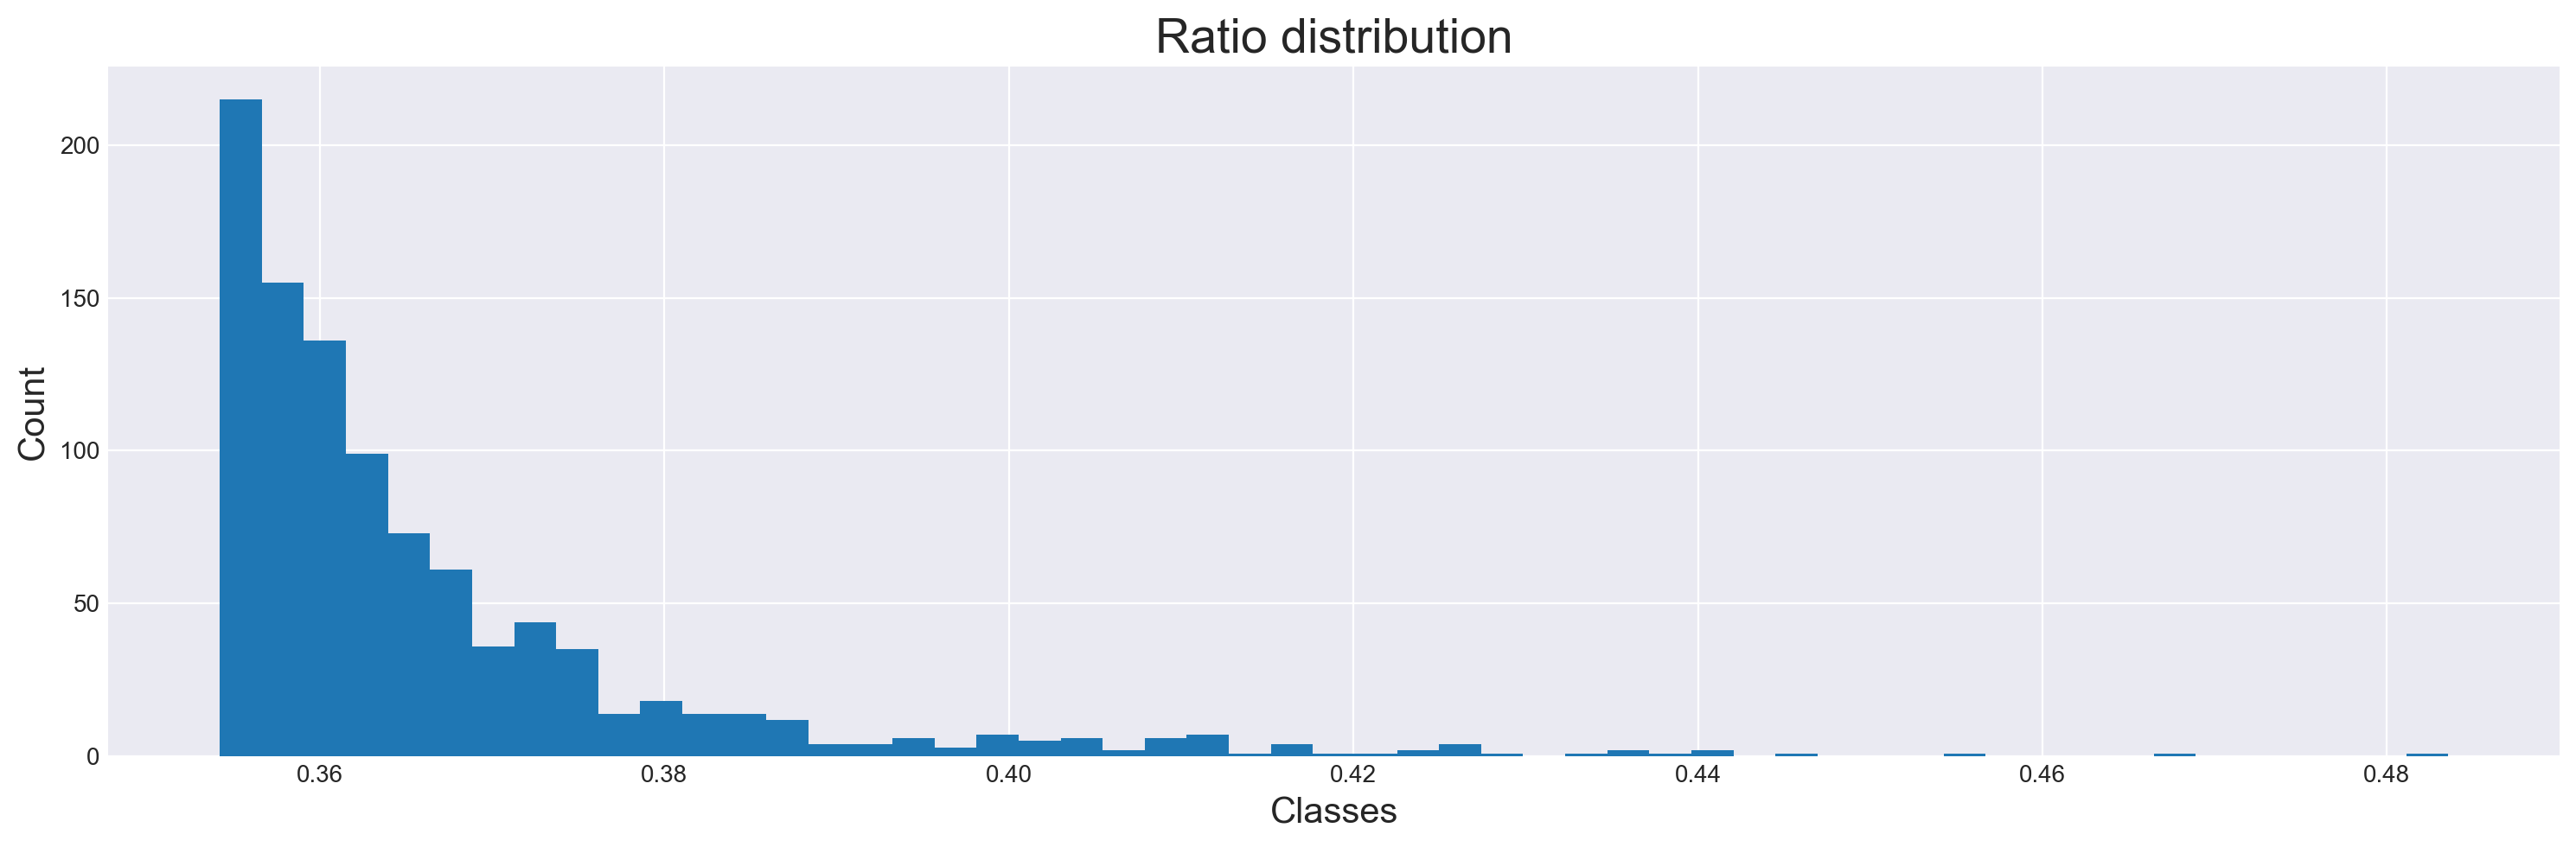

In [161]:
plt.hist(expenses_2025_dict['ratio_output'],bins = 'auto')
plt.title('Ratio distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

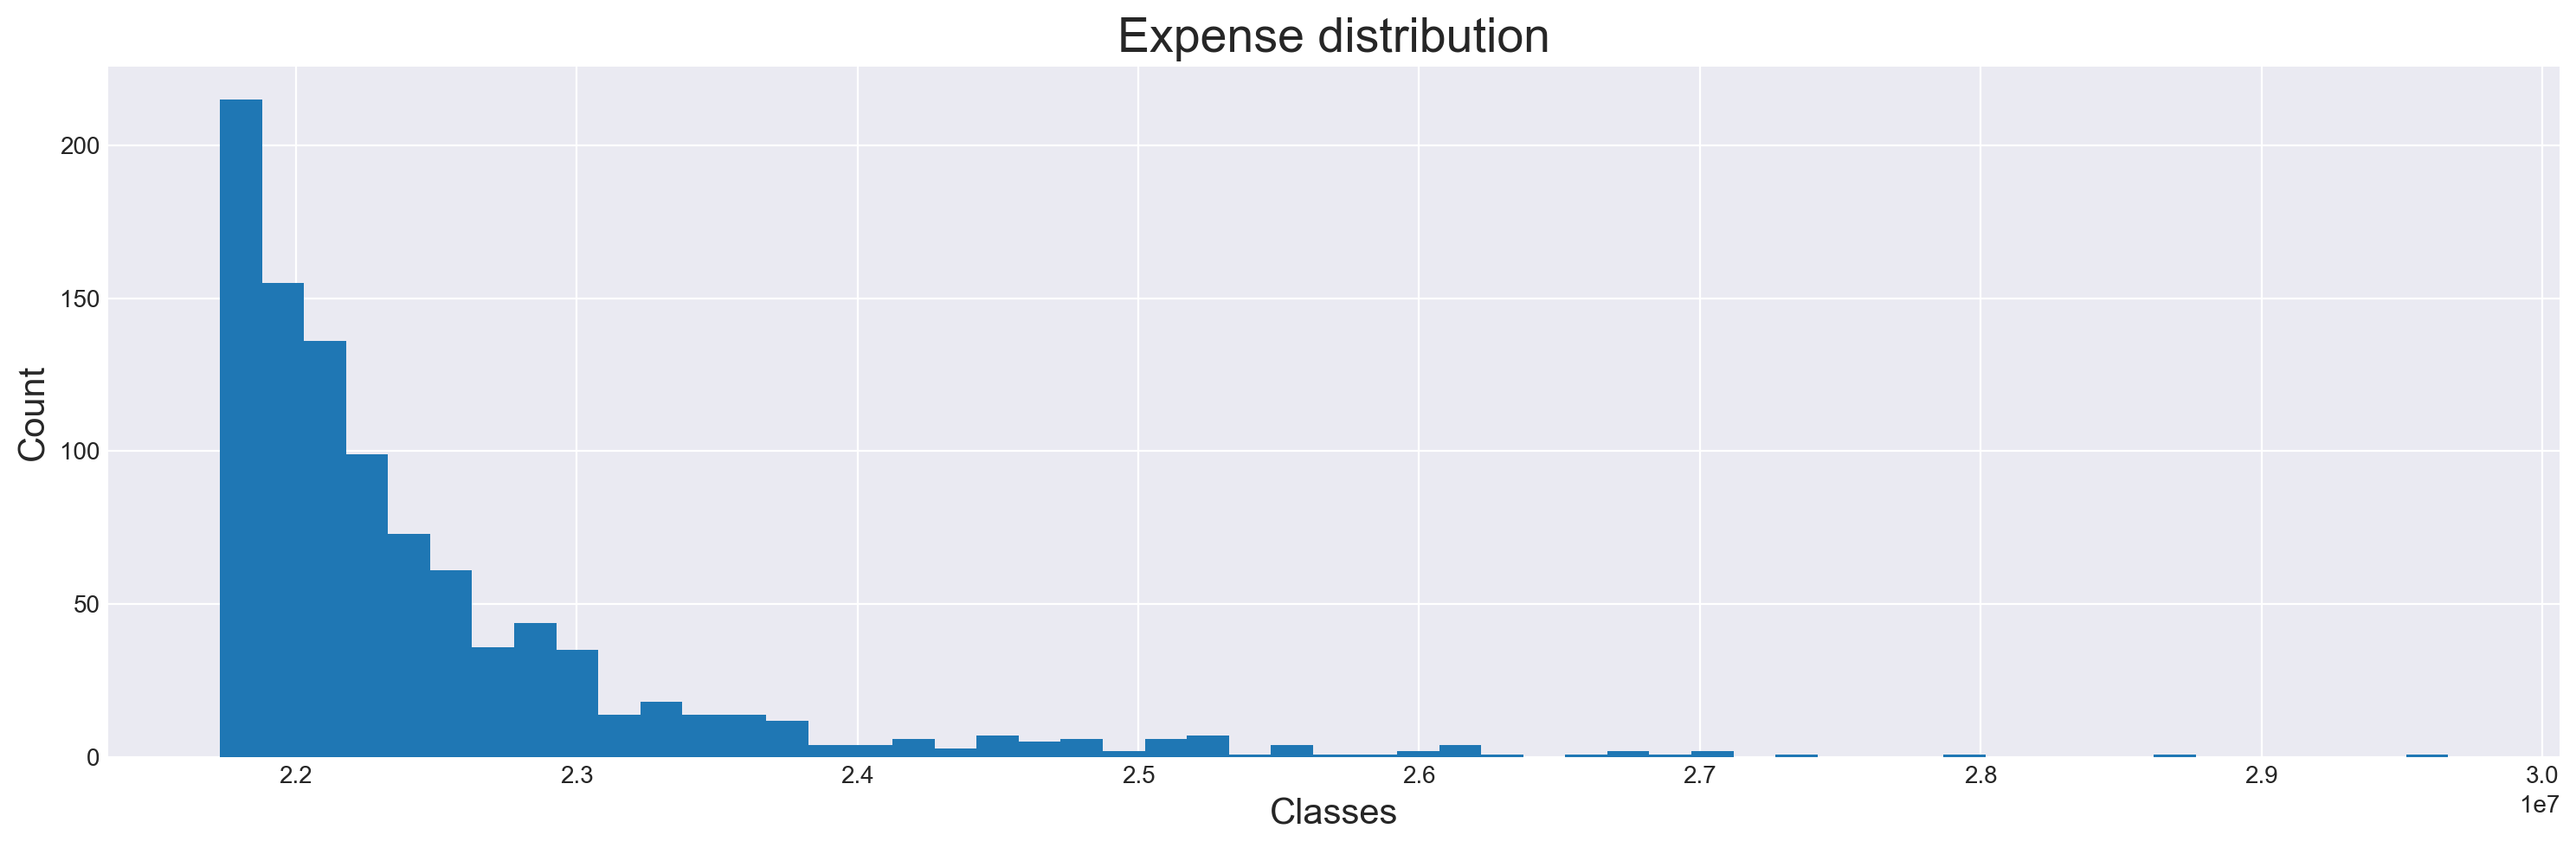

In [162]:
plt.hist(expenses_2025_dict['expense_output'],bins = 'auto')
plt.title('Expense distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

In [163]:
# 2026 expenses

In [164]:
expenses_2026 = Expenses(mean_expenses = cost_by_year[cost_by_year.index == 2026]['Cost'].values[0],variance_expenses = std * exp_price_refined.loc[exp_price_refined.index == (2026,),'Price'].values[0] * 12,fund_amount = df_2026_lc.Loss.values[0])

In [165]:
# calculating optimal expense values through montecarlo simulation with an assumption that expenses has a pareto distribution
expenses_2026_dict = expenses_2026.montecarlo(alpha = 5,number_of_replications = 1000)

In [166]:
# expense ratio for gross rate calculation
or_2026 = expenses_2026_dict['optimal_ratio']
or_2026

0.3311697936273756

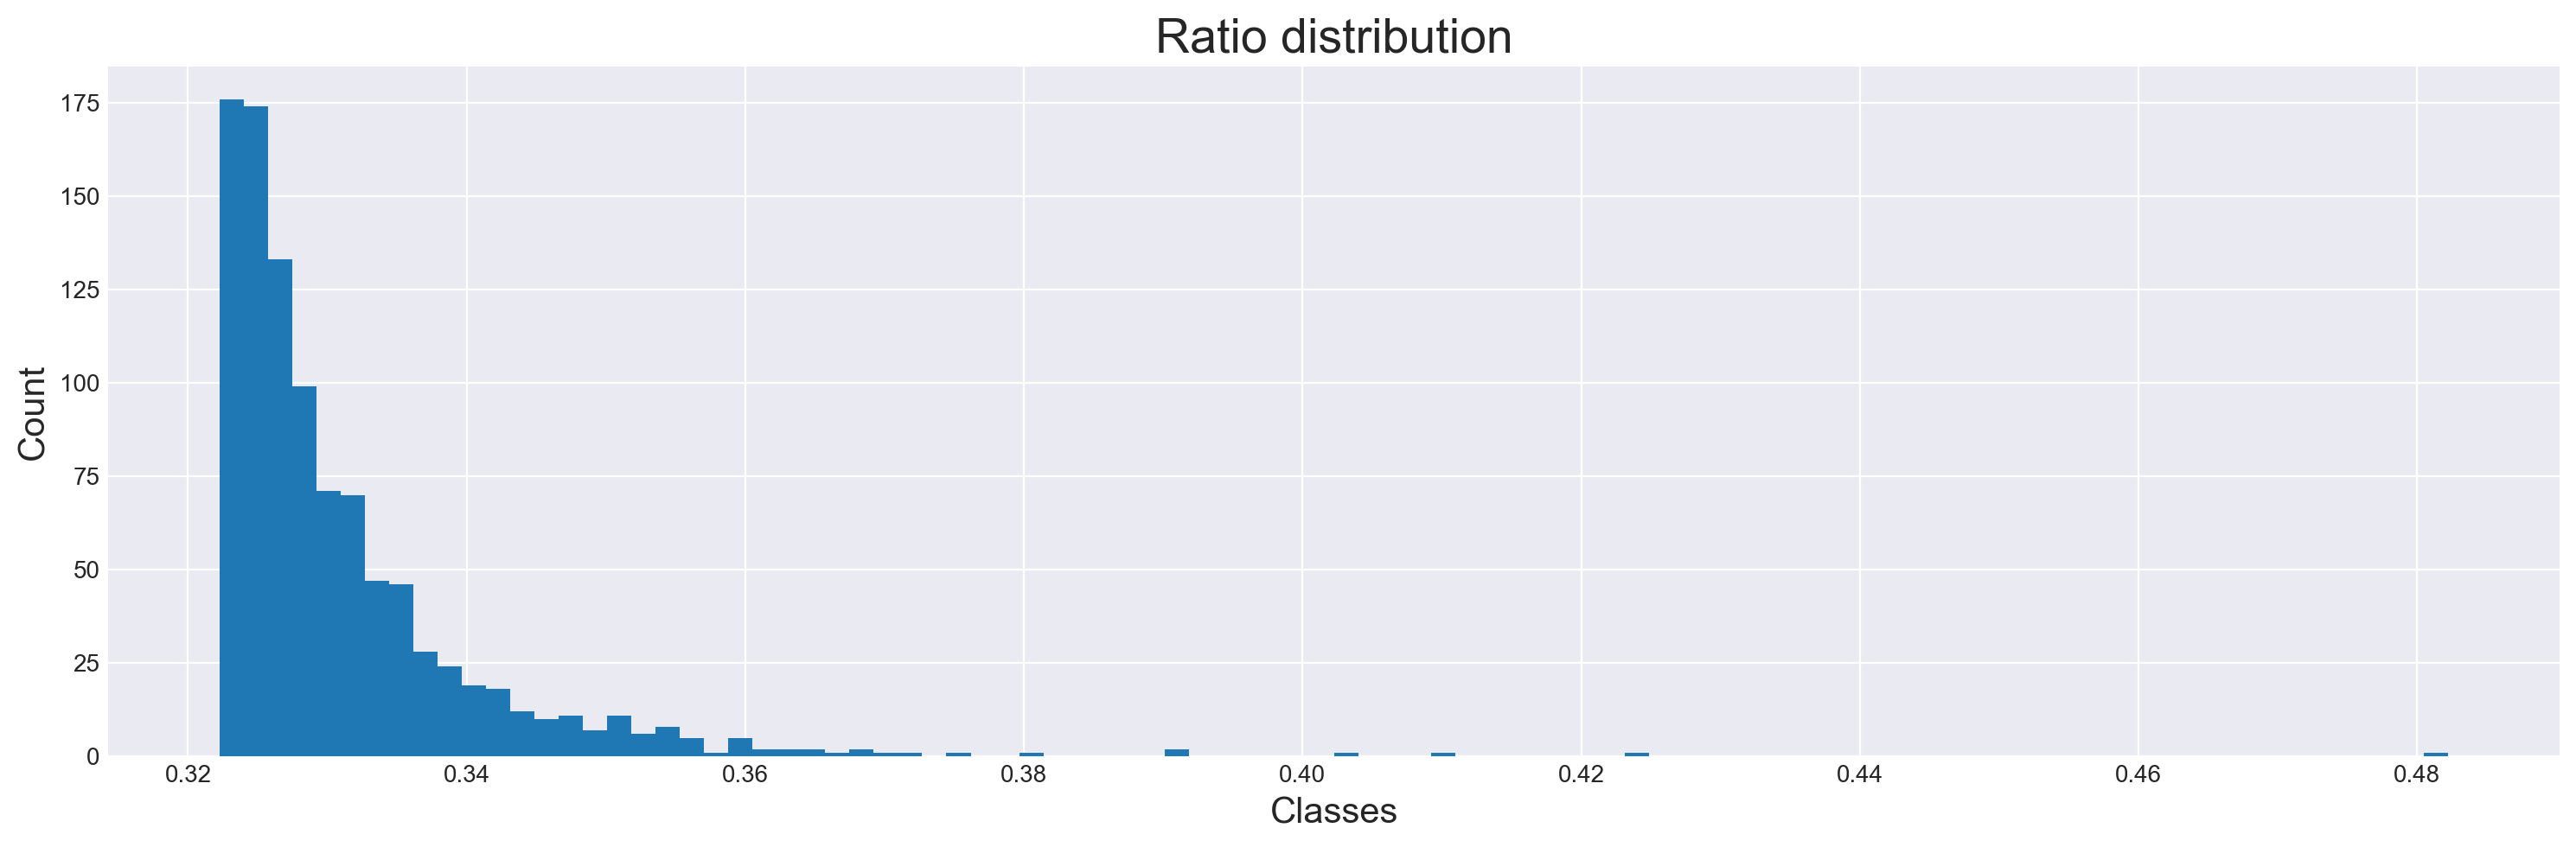

In [167]:
plt.hist(expenses_2026_dict['ratio_output'],bins = 'auto')
plt.title('Ratio distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

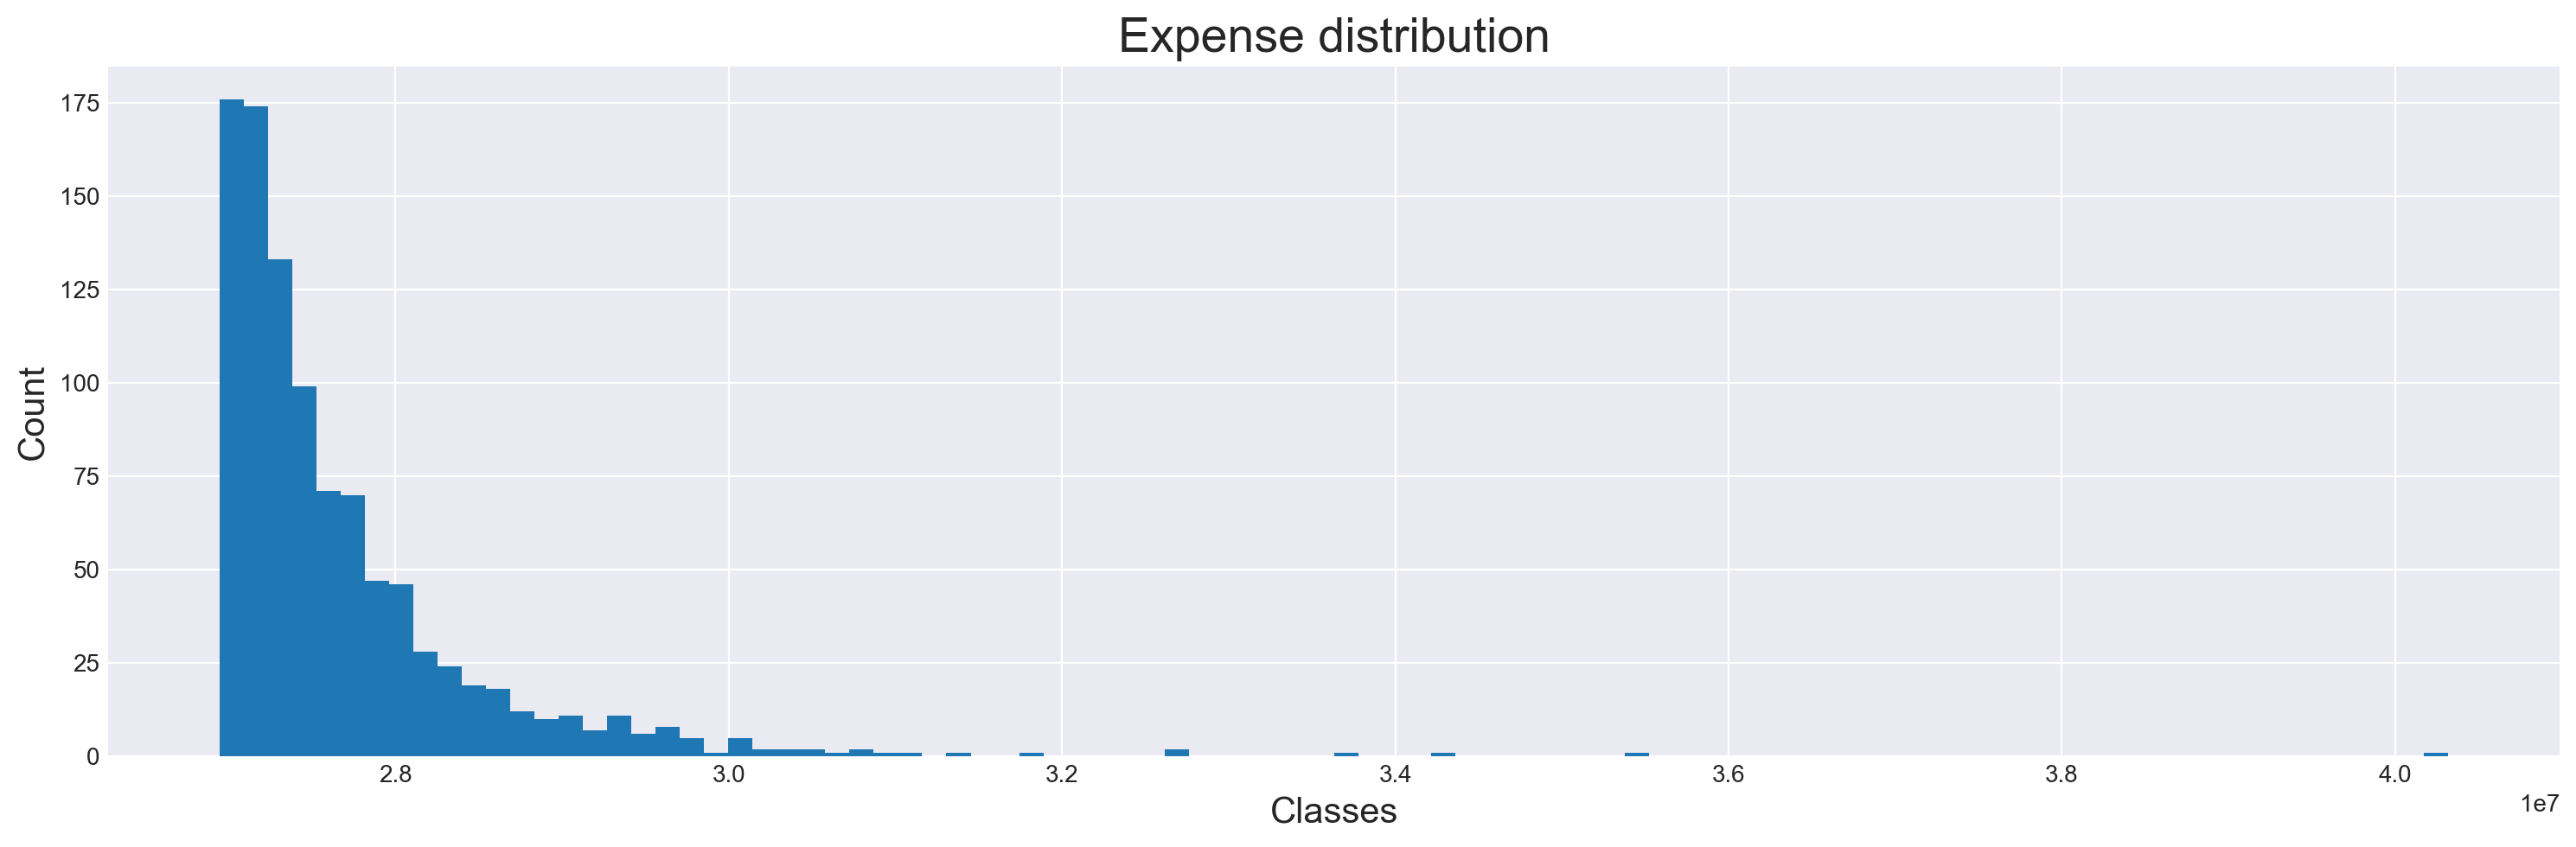

In [168]:
plt.hist(expenses_2026_dict['expense_output'],bins = 'auto')
plt.title('Expense distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

In [169]:
# 2027 expenses

In [170]:
expenses_2027 = Expenses(mean_expenses = cost_by_year[cost_by_year.index == 2027]['Cost'].values[0],variance_expenses = std * exp_price_refined.loc[exp_price_refined.index == (2027,),'Price'].values[0] * 12,fund_amount = df_2027_lc.Loss.values[0])

In [171]:
# calculating optimal expense values through montecarlo simulation with an assumption that expenses has a pareto distribution
expenses_2027_dict = expenses_2027.montecarlo(alpha = 5,number_of_replications = 1000)

In [172]:
# expense ratio for gross rate calculation
or_2027 = expenses_2027_dict['optimal_ratio']
or_2027

0.30637342118499417

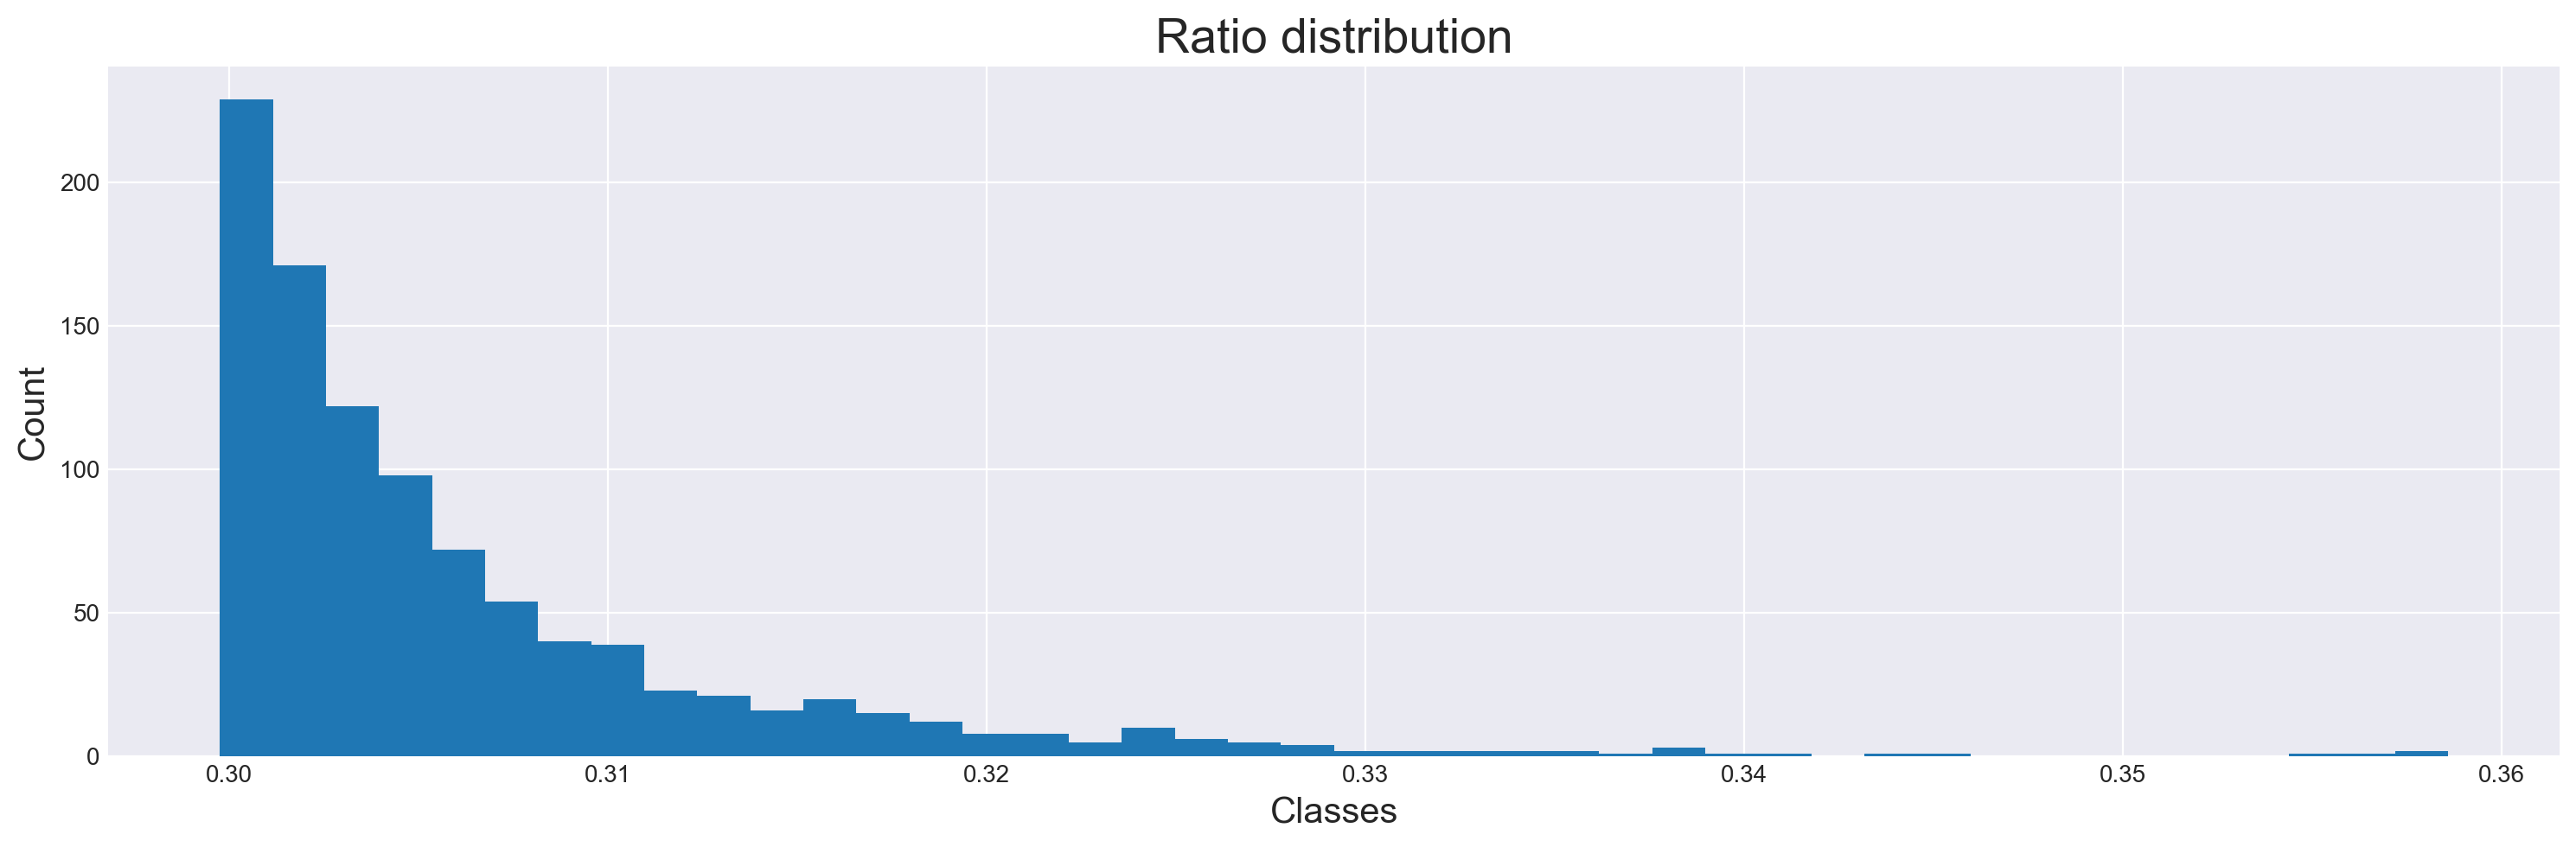

In [173]:
plt.hist(expenses_2027_dict['ratio_output'],bins = 'auto')
plt.title('Ratio distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

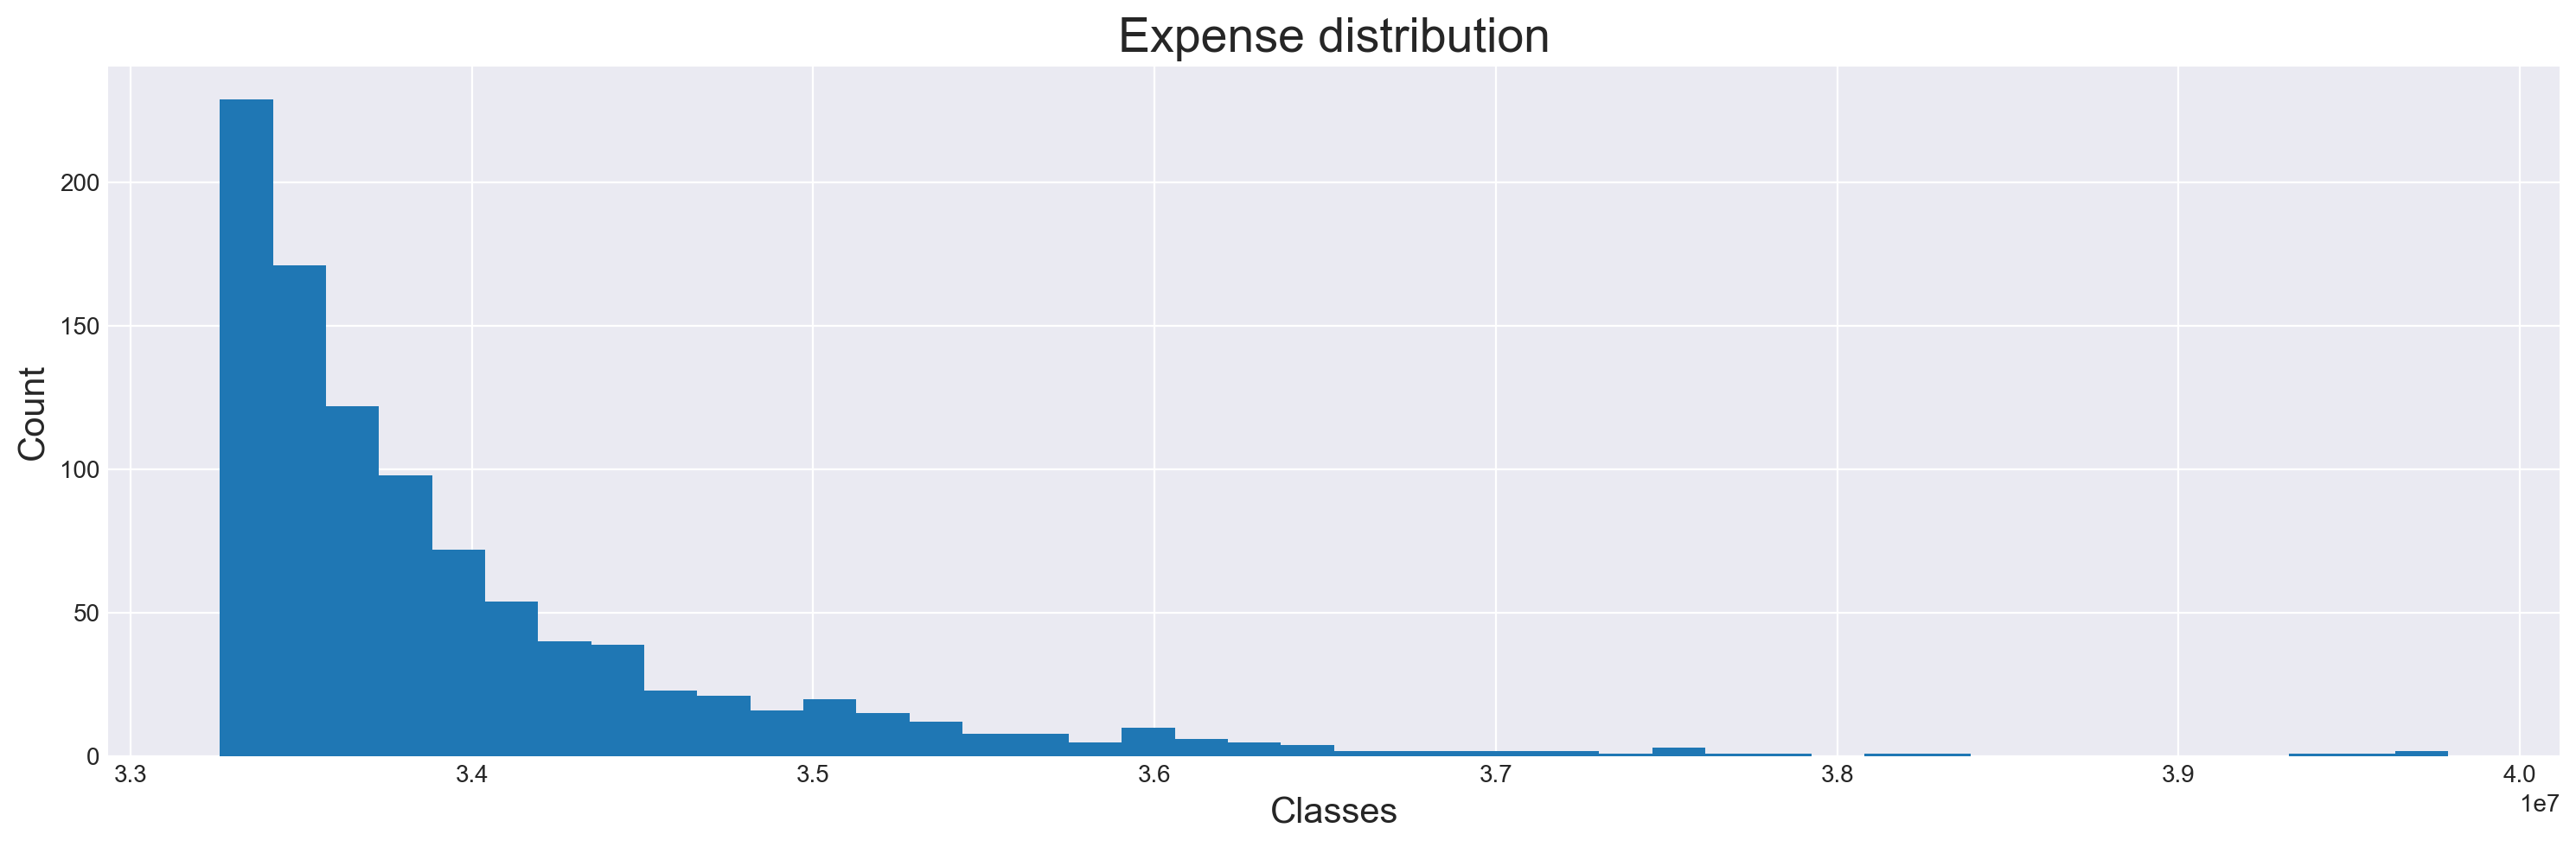

In [174]:
plt.hist(expenses_2027_dict['expense_output'],bins = 'auto')
plt.title('Expense distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

In [175]:
# 2028 expenses

In [176]:
expenses_2028 = Expenses(mean_expenses = cost_by_year[cost_by_year.index == 2028]['Cost'].values[0],variance_expenses = std * exp_price_refined.loc[exp_price_refined.index == (2028,),'Price'].values[0] * 12,fund_amount = df_2028_lc.Loss.values[0])

In [177]:
# calculating optimal expense values through montecarlo simulation with an assumption that expenses has a pareto distribution
expenses_2028_dict = expenses_2028.montecarlo(alpha = 5,number_of_replications = 1000)

In [178]:
# Expense ratio for gross rate calculation
or_2028 = expenses_2028_dict['optimal_ratio']
or_2028

0.3017166602153775

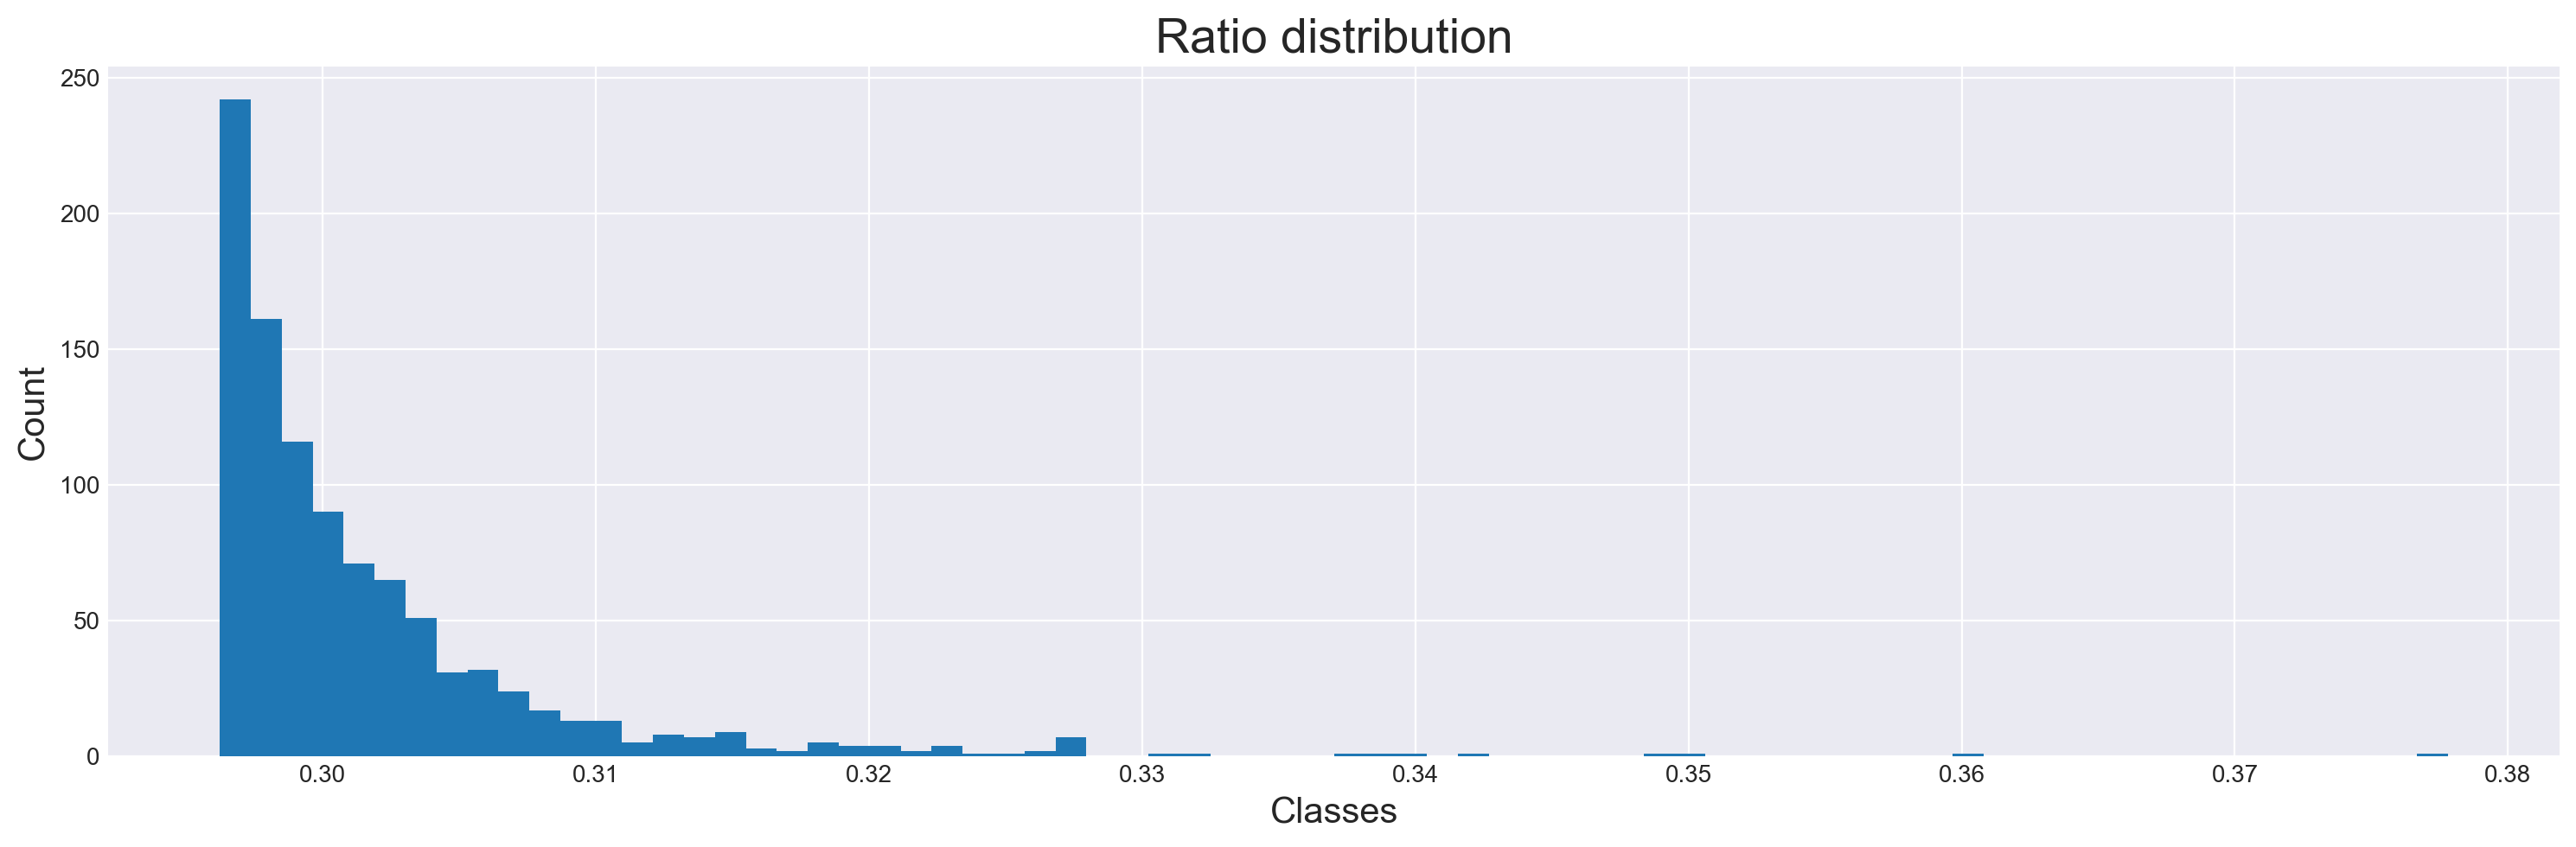

In [179]:
plt.hist(expenses_2028_dict['ratio_output'],bins = 'auto')
plt.title('Ratio distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

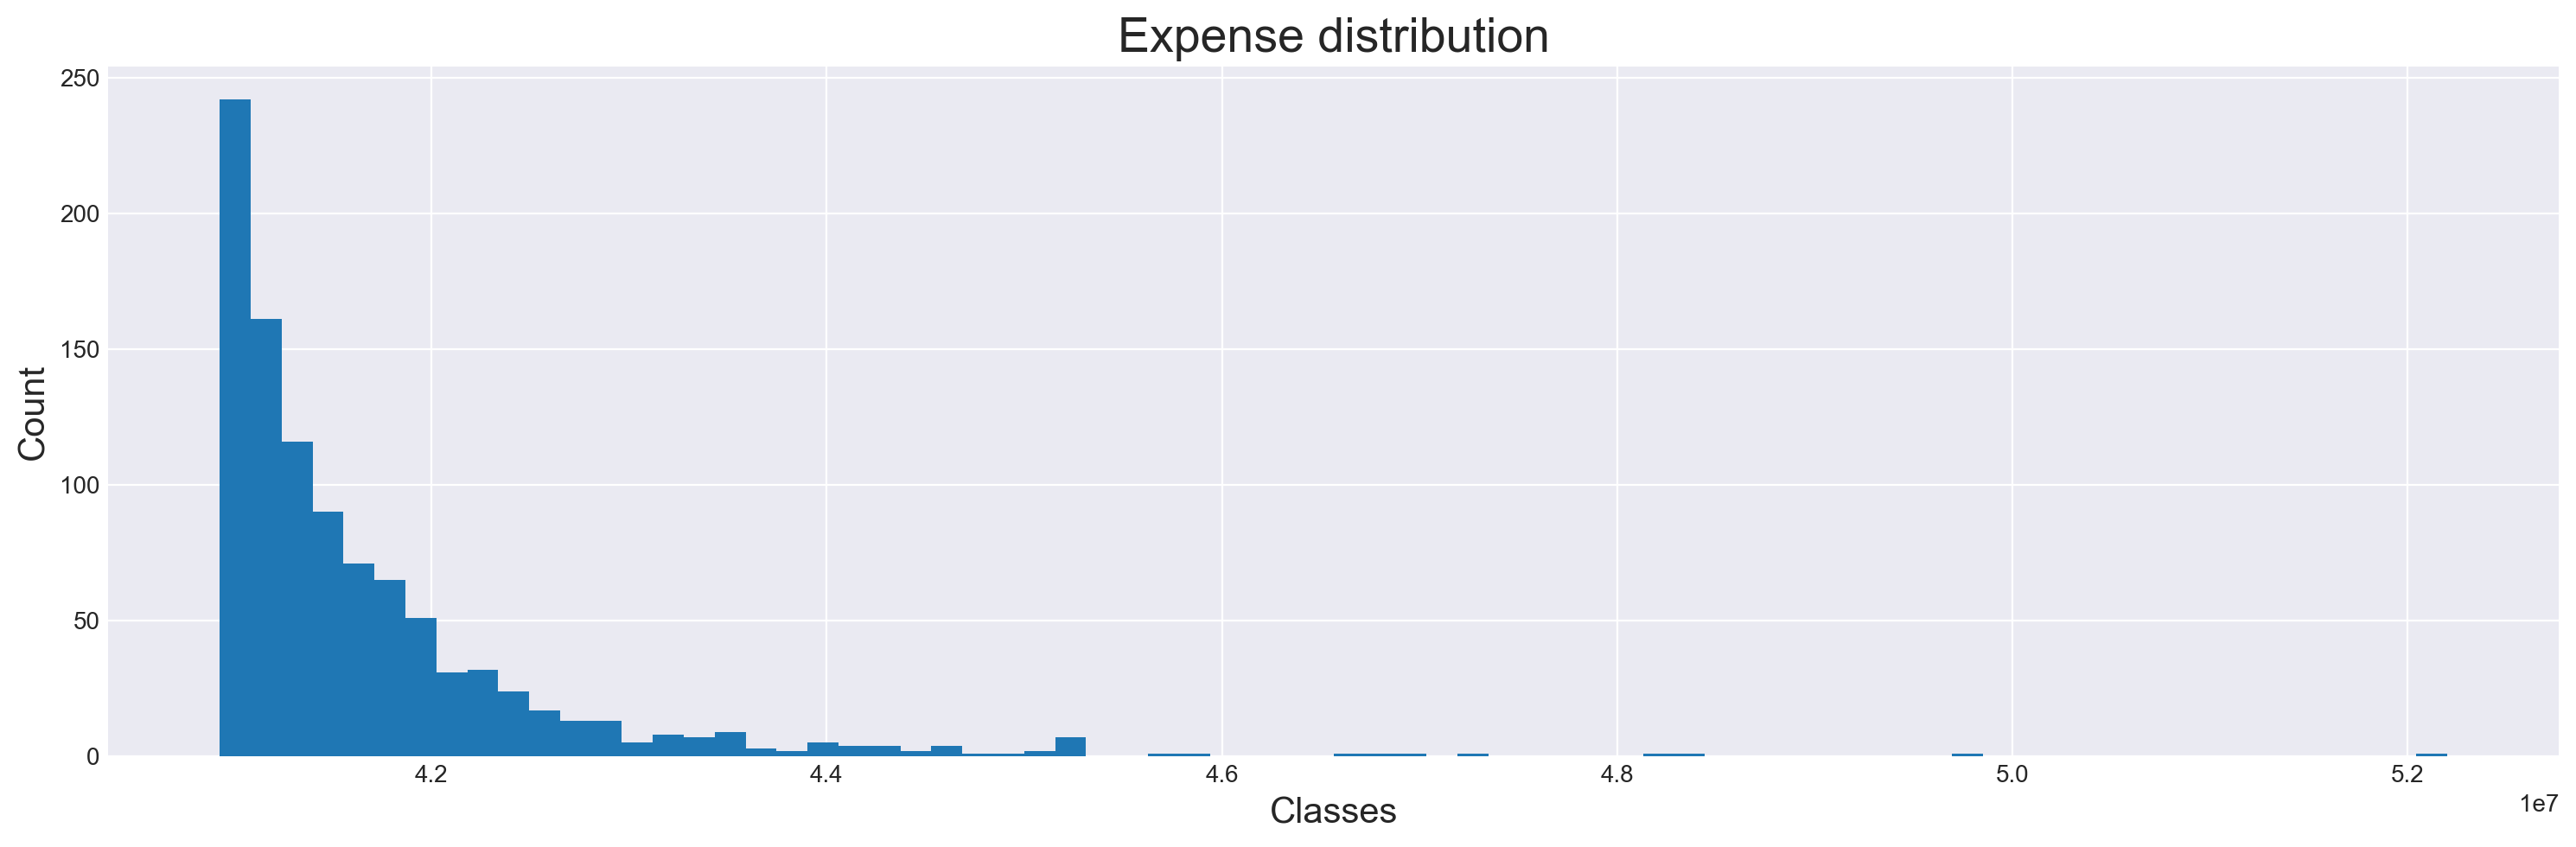

In [180]:
plt.hist(expenses_2028_dict['expense_output'],bins = 'auto')
plt.title('Expense distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

In [181]:
# 2029 expenses

In [182]:
expenses_2029 = Expenses(mean_expenses = cost_by_year[cost_by_year.index == 2029]['Cost'].values[0],variance_expenses = std * exp_price_refined.loc[exp_price_refined.index == (2029,),'Price'].values[0] * 12,fund_amount = df_2029_lc.Loss.values[0])

In [183]:
# calculating optimal expense values through montecarlo simulation with an assumption that expenses has a pareto distribution
expenses_2029_dict = expenses_2029.montecarlo(alpha = 5,number_of_replications = 1000)

In [184]:
# Expense ration fro gross rate calculation
or_2029 = expenses_2029_dict['optimal_ratio']
or_2029

0.2883740249290744

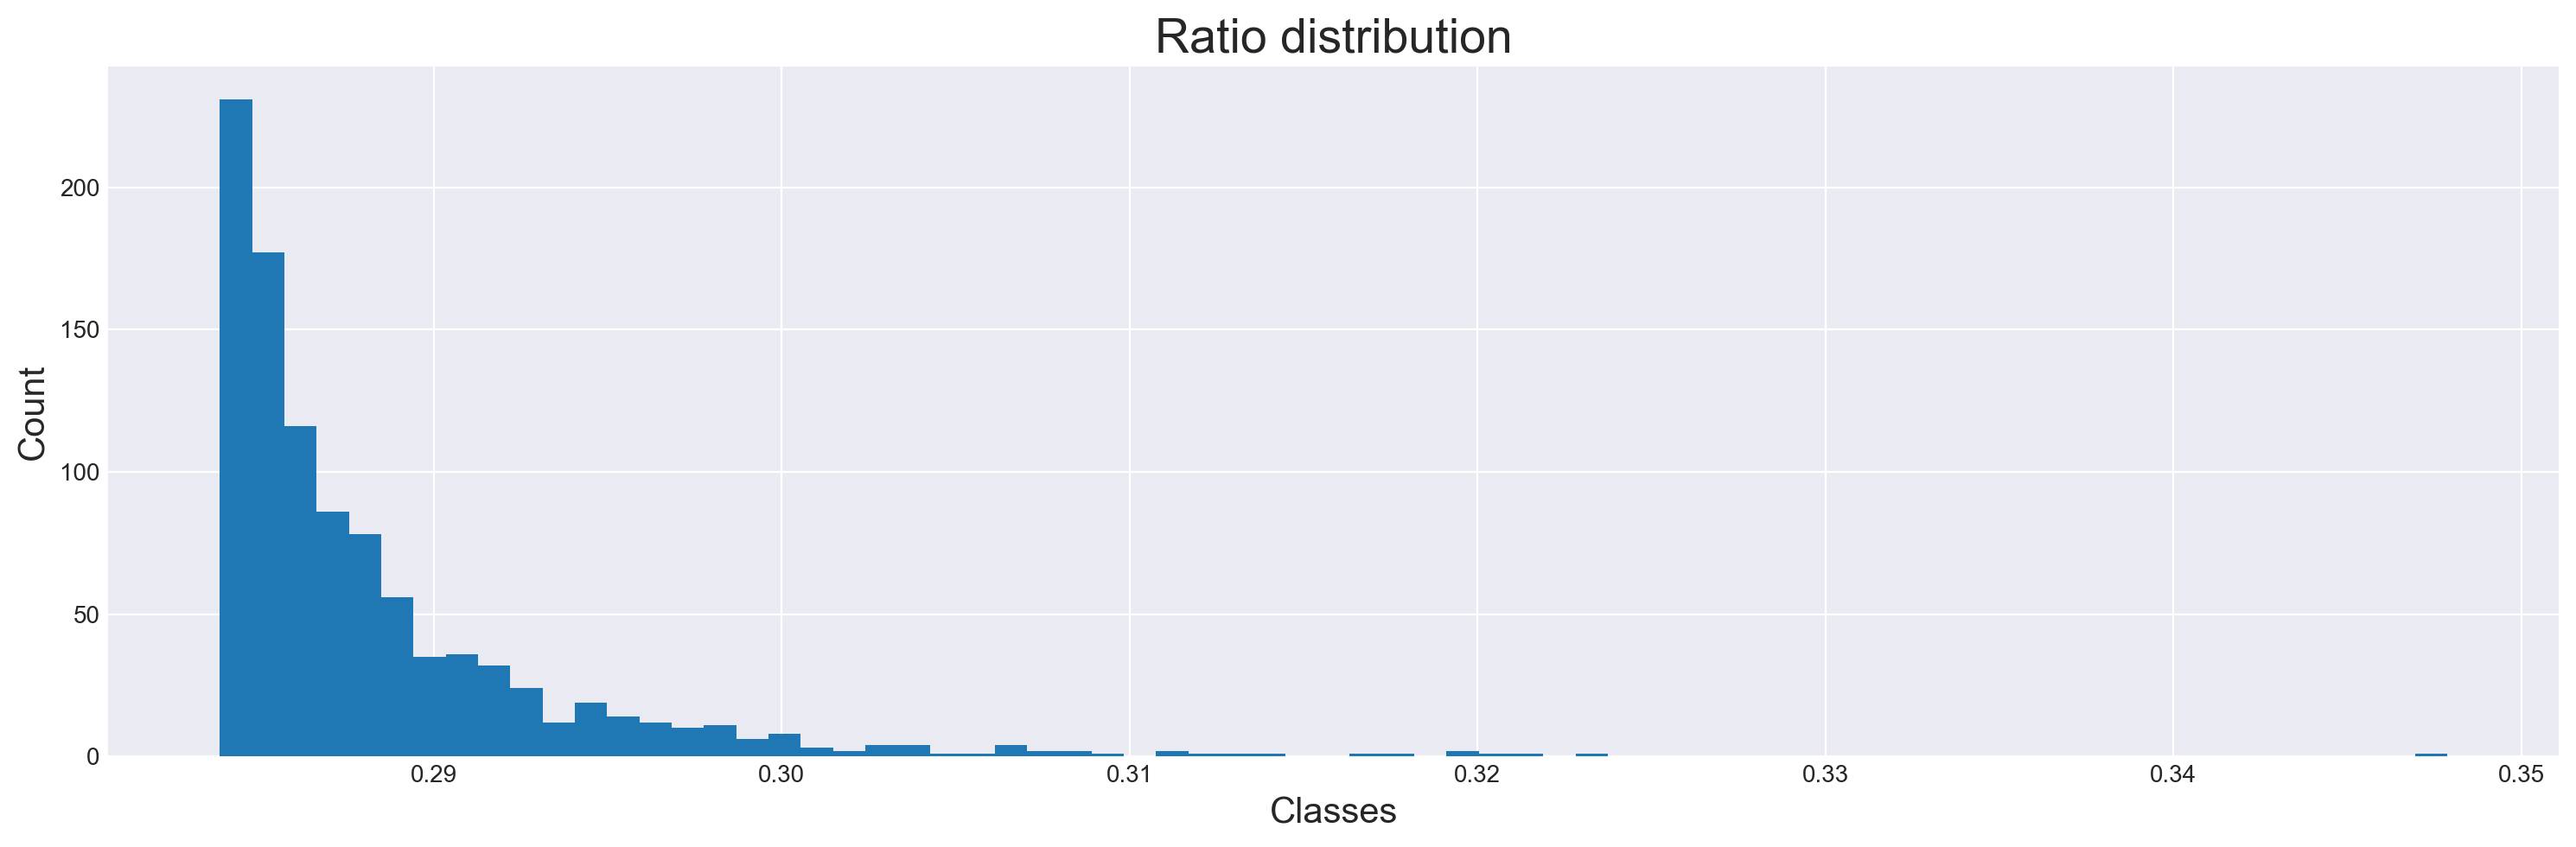

In [185]:
plt.hist(expenses_2029_dict['ratio_output'],bins = 'auto')
plt.title('Ratio distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

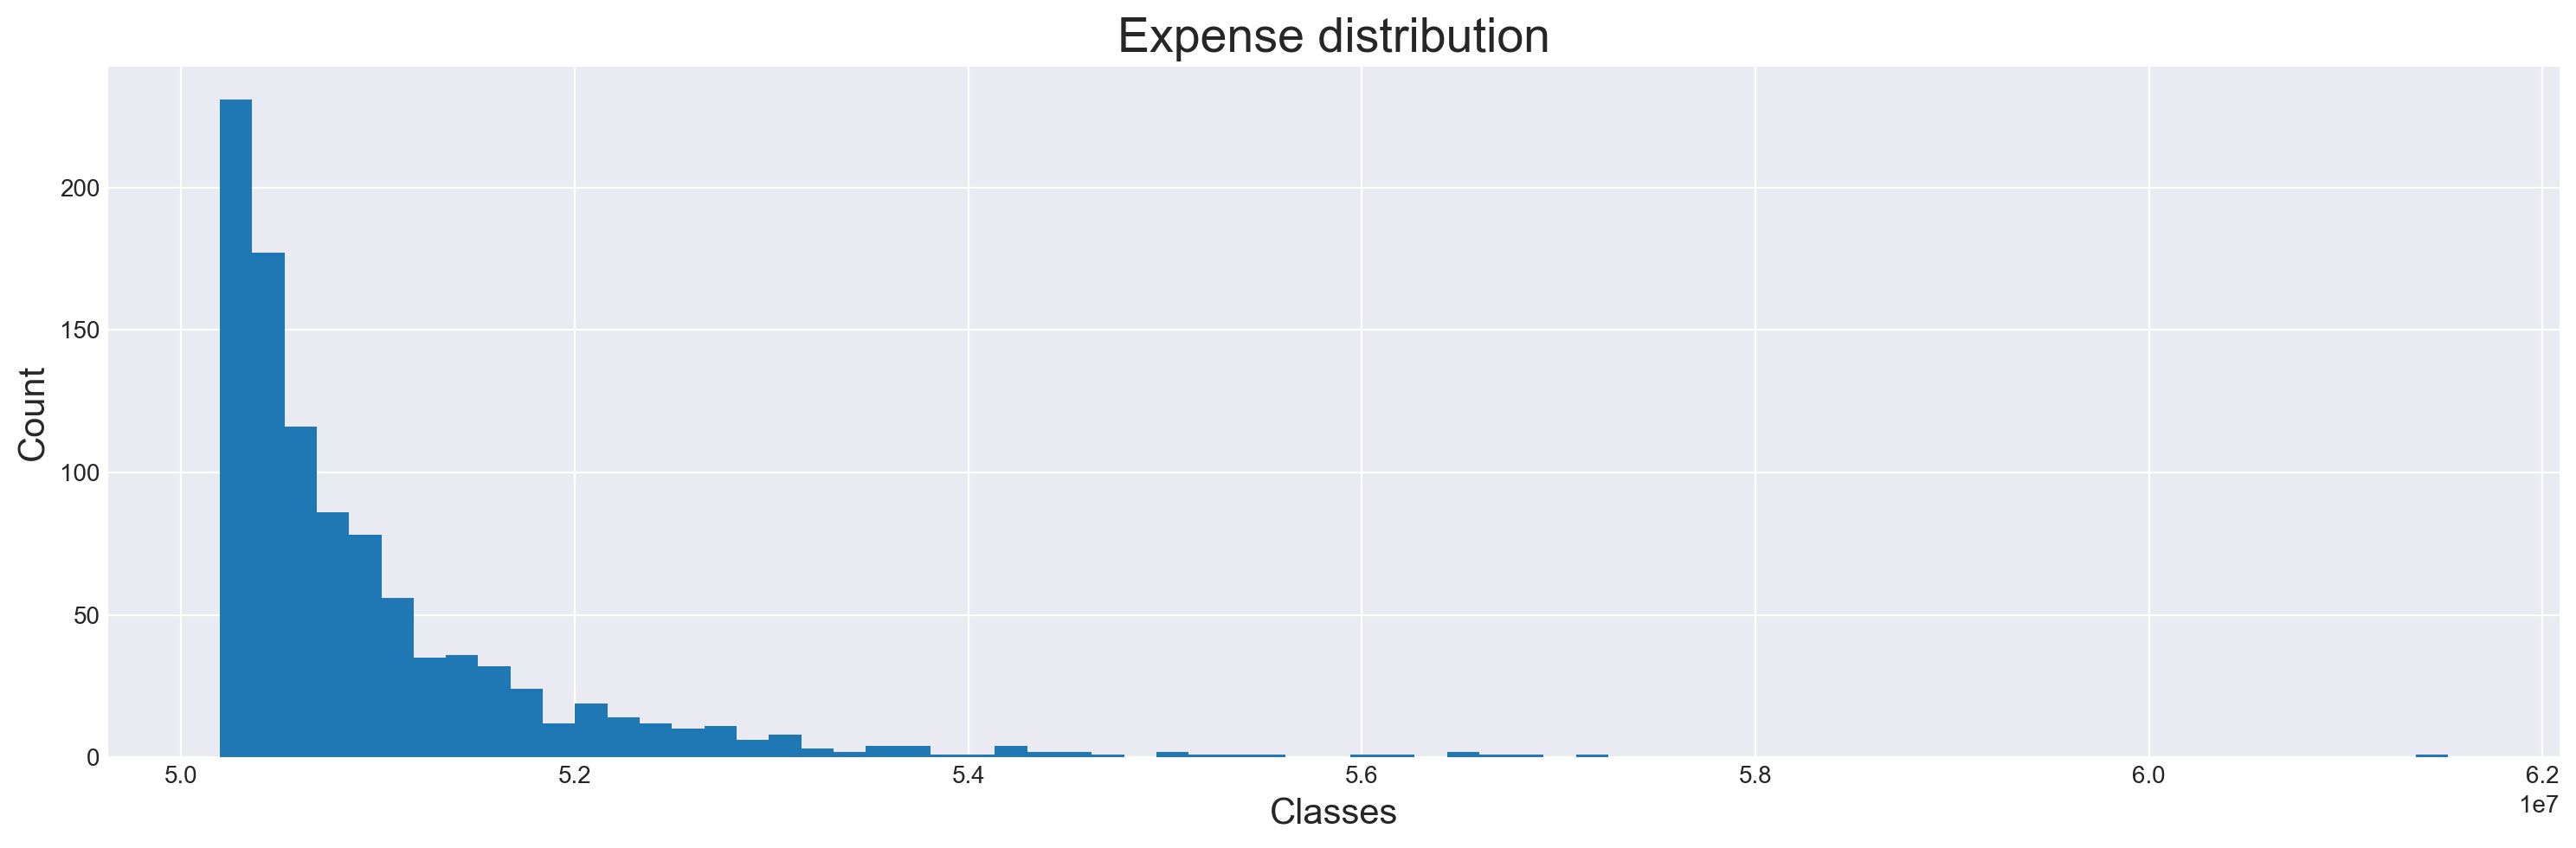

In [186]:
plt.hist(expenses_2029_dict['expense_output'],bins = 'auto')
plt.title('Expense distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

In [187]:
# defining expense ratio dataframe
optimal_ratio_df = pd.DataFrame({'Ratio':[or_2025,or_2026,or_2027,or_2028,or_2029]},index = [2025,2026,2027,2028,2029])

In [188]:
optimal_ratio_df

Ratio
2025  0.366614
2026  0.331170
2027  0.306373
2028  0.301717
2029  0.288374

In [189]:
pure_premium_df

Pure premium
Year              
2025     28.565508
2026     37.945264
2027     49.095723
2028     59.616084
2029     74.433687

In [190]:
# defining gross rate dataframe
gross_rate_df = optimal_ratio_df.join([pure_premium_df])

In [191]:
gross_rate_df

Ratio  Pure premium
2025  0.366614     28.565508
2026  0.331170     37.945264
2027  0.306373     49.095723
2028  0.301717     59.616084
2029  0.288374     74.433687

In [192]:
# defining gross rate dataframe
gross_rate_df['Gross rate'] = gross_rate_df.apply(lambda col: Premium.gross_rate(col['Pure premium'],col['Ratio']),axis = 'columns')

In [193]:
gross_rate_df

Ratio  Pure premium  Gross rate
2025  0.366614     28.565508   45.099710
2026  0.331170     37.945264   56.733777
2027  0.306373     49.095723   70.781202
2028  0.301717     59.616084   85.375206
2029  0.288374     74.433687  104.596641

In [194]:
exposures_ref = exposures
exposures_ref.index = [2025,2026,2027,2028,2029]
exposures_ref

Exposures  Exposures shift()
2025    2203399          2147596.0
2026    2260115          2203399.0
2027    2317627          2260115.0
2028    2375855          2317627.0
2029    2434788          2375855.0

In [195]:
gross_rate_df = gross_rate_df.join([exposures_ref])

In [196]:
gross_rate_df

Ratio  Pure premium  Gross rate  Exposures  Exposures shift()
2025  0.366614     28.565508   45.099710    2203399          2147596.0
2026  0.331170     37.945264   56.733777    2260115          2203399.0
2027  0.306373     49.095723   70.781202    2317627          2260115.0
2028  0.301717     59.616084   85.375206    2375855          2317627.0
2029  0.288374     74.433687  104.596641    2434788          2375855.0

In [197]:
# defining total gross rates column
gross_rate_df['Total gross rates'] = gross_rate_df.apply(lambda col: Premium.gross_premium(col['Gross rate'],col['Exposures shift()']),axis = 'columns')

In [198]:
gross_rate_df

Ratio  Pure premium  Gross rate  Exposures  Exposures shift()  \
2025  0.366614     28.565508   45.099710    2203399          2147596.0   
2026  0.331170     37.945264   56.733777    2260115          2203399.0   
2027  0.306373     49.095723   70.781202    2317627          2260115.0   
2028  0.301717     59.616084   85.375206    2375855          2317627.0   
2029  0.288374     74.433687  104.596641    2434788          2375855.0   

      Total gross rates  
2025       9.685596e+07  
2026       1.250071e+08  
2027       1.599737e+08  
2028       1.978679e+08  
2029       2.485065e+08

In [199]:
Total_premium = gross_rate_df

<h2 style = 'background-color:teal;padding:10px;color:white;border-radius:10px;text-align:center;margin-left:150px;margin-right:170px;'> Tax calculation </h2>

In [200]:
# loading real interest rate
real_interest = pd.read_excel('realInterest.xls')

In [201]:
real_interest

Data Source World Development Indicators  \
0              Last Updated Date          2023-10-26 00:00:00   
1                            NaN                          NaN   
2                   Country Name                 Country Code   
3                          Aruba                          ABW   
4    Africa Eastern and Southern                          AFE   
..                           ...                          ...   
264                       Kosovo                          XKX   
265                  Yemen, Rep.                          YEM   
266                 South Africa                          ZAF   
267                       Zambia                          ZMB   
268                     Zimbabwe                          ZWE   

                 Unnamed: 2      Unnamed: 3  Unnamed: 4   Unnamed: 5  \
0                       NaN             NaN         NaN          NaN   
1                       NaN             NaN         NaN          NaN   
2            Indicator Name  Indicator Code      1960.0  1961.000000   
3    Real interest rate (%)     FR.INR.RINR         NaN          NaN   
4    Real interest rate (%)     FR.INR.RINR         NaN          NaN   
..                      ...             ...         ...          ...   
264  Real interest rate (%)     FR.INR.RINR         NaN          NaN   
265  Real interest rate (%)     FR.INR.RINR         NaN          NaN   
266  Real interest rate (%)     FR.INR.RINR         NaN     5.200152   
267  Real interest rate (%)     FR.INR.RINR         NaN          NaN   
268  Real interest rate (%)     FR.INR.RINR         NaN          NaN   

      Unnamed: 6   Unnamed: 7   Unnamed: 8   Unnamed: 9  ...  Unnamed: 57  \
0            NaN          NaN          NaN          NaN  ...          NaN   
1            NaN          NaN          NaN          NaN  ...          NaN   
2    1962.000000  1963.000000  1964.000000  1965.000000  ...  2013.000000   
3            NaN          NaN          NaN          NaN  ...    10.699324   
4            NaN          NaN          NaN          NaN  ...          NaN   
..           ...          ...          ...          ...  ...          ...   
264          NaN          NaN          NaN          NaN  ...    11.426638   
265          NaN          NaN          NaN          NaN  ...    11.788755   
266     6.013274     2.423273     3.667879     3.800071  ...     2.509245   
267          NaN          NaN          NaN          NaN  ...    -0.191720   
268          NaN          NaN          NaN          NaN  ...     1.525435   

     Unnamed: 58  Unnamed: 59  Unnamed: 60  Unnamed: 61  Unnamed: 62  \
0            NaN          NaN          NaN          NaN          NaN   
1            NaN          NaN          NaN          NaN          NaN   
2    2014.000000  2015.000000  2016.000000  2017.000000  2018.000000   
3       4.851601     4.358079     8.406540     8.197718     5.306747   
4            NaN          NaN          NaN          NaN          NaN   
..           ...          ...          ...          ...          ...   
264     8.871489     7.665605     6.615972     6.364710     5.079008   
265          NaN          NaN          NaN          NaN          NaN   
266     3.567028     3.667743     3.278252     4.647315     6.108760   
267     5.821128     6.179216     1.715079     2.070262     2.215865   
268     8.787605     8.144427     4.998563     3.742846   -64.380817   

     Unnamed: 63  Unnamed: 64  Unnamed: 65  Unnamed: 66  
0            NaN          NaN          NaN          NaN  
1            NaN          NaN          NaN          NaN  
2    2019.000000  2020.000000  2021.000000  2022.000000  
3       2.624635    13.122279          NaN          NaN  
4            NaN          NaN          NaN          NaN  
..           ...          ...          ...          ...  
264          NaN          NaN          NaN          NaN  
265          NaN          NaN          NaN          NaN  
266     5.243711     1.907151     0.774484     3.557564  
267  

In [202]:
# data cleaning

In [203]:
real_interest = real_interest.iloc[2::,::]

In [204]:
real_interest.columns = real_interest.iloc[0].values

In [205]:
real_interest = real_interest.loc[real_interest['Country Name'] == 'Malawi']

In [206]:
real_interest = real_interest.T

In [207]:
real_interest.dropna(inplace = True)

In [208]:
real_interest = real_interest.iloc[4::]

In [209]:
real_interest.columns = ['Real interest (%)']

In [210]:
real_interest.index = [int(i) for i in real_interest.index]

In [211]:
real_interest.head()

Real interest (%)
1981          1.799105
1982          8.058069
1983           6.38638
1984          3.305735
1985          8.669878

In [212]:
real_interest.tail()

Real interest (%)
2018         24.650079
2019         16.658529
2020         13.895988
2021         13.254763
2022          2.839456

In [213]:
# loading inflation data
inflation_rate = pd.read_excel('infla.xls')

In [214]:
inflation_rate

Data Source World Development Indicators  \
0              Last Updated Date          2023-10-26 00:00:00   
1                            NaN                          NaN   
2                   Country Name                 Country Code   
3                          Aruba                          ABW   
4    Africa Eastern and Southern                          AFE   
..                           ...                          ...   
264                       Kosovo                          XKX   
265                  Yemen, Rep.                          YEM   
266                 South Africa                          ZAF   
267                       Zambia                          ZMB   
268                     Zimbabwe                          ZWE   

                                Unnamed: 2      Unnamed: 3   Unnamed: 4  \
0                                      NaN             NaN          NaN   
1                                      NaN             NaN          NaN   
2                           Indicator Name  Indicator Code  1960.000000   
3    Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG          NaN   
4    Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG          NaN   
..                                     ...             ...          ...   
264  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG          NaN   
265  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG          NaN   
266  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG     1.288859   
267  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG          NaN   
268  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG          NaN   

      Unnamed: 5   Unnamed: 6  Unnamed: 7   Unnamed: 8   Unnamed: 9  ...  \
0            NaN          NaN         NaN          NaN          NaN  ...   
1            NaN          NaN         NaN          NaN          NaN  ...   
2    1961.000000  1962.000000  1963.00000  1964.000000  1965.000000  ...   
3            NaN          NaN         NaN          NaN          NaN  ...   
4            NaN          NaN         NaN          NaN          NaN  ...   
..           ...          ...         ...          ...          ...  ...   
264          NaN          NaN         NaN          NaN          NaN  ...   
265          NaN          NaN         NaN          NaN          NaN  ...   
266     2.102374     1.246285     1.33797     2.534973     4.069029  ...   
267          NaN          NaN         NaN          NaN          NaN  ...   
268          NaN          NaN         NaN          NaN          NaN  ...   

     Unnamed: 57  Unnamed: 58  Unnamed: 59  Unnamed: 60  Unnamed: 61  \
0            NaN          NaN          NaN          NaN          NaN   
1            NaN          NaN          NaN          NaN          NaN   
2    2013.000000  2014.000000  2015.000000  2016.000000  2017.000000   
3      -2.372065     0.421441     0.474764    -0.931196    -1.028282   
4       5.750981     5.370290     5.245878     6.571396     6.399343   
..           ...          ...          ...          ...          ...   
264     1.767324     0.428958    -0.536929     0.273169     1.488234   
265    10.968442     8.104726          NaN          NaN          NaN   
266     5.784469     6.129838     4.540642     6.571396     5.184247   
267     6.977676     7.806876    10.110593    17.869730     6.577312   
268     1.634950    -0.197785    -2.430968    -1.543670     0.893962   

     Unnamed: 62  Unnamed: 63  Unnamed: 64  Unnamed: 65  Unnamed: 66  
0            NaN          NaN          NaN          NaN          NaN  
1            NaN          NaN          NaN          NaN          NaN  
2    2018.000000  2019.000000  2020.000000  2021.000000  2022.000000  
3       3.626041     4.257462          NaN          NaN          NaN  
4       4.720811     4.653665     7.321106     6.824727    10.526577  
..           ...          ...          ...          ...          ...  
264     1.053798     2.675992     0.198228     3.353691    11.58

In [215]:
# data cleaning

In [216]:
inflation_rate = inflation_rate.iloc[2::,::]

In [217]:
inflation_rate.columns = inflation_rate.iloc[0].values

In [218]:
inflation_rate = inflation_rate.loc[inflation_rate['Country Name'] == 'Malawi']

In [219]:
inflation_rate = inflation_rate.T

In [220]:
inflation_rate.dropna(inplace = True)

In [221]:
inflation_rate = inflation_rate.iloc[4::]

In [222]:
inflation_rate.columns = ['Inflation rate (%)']

In [223]:
inflation_rate.index = [int(i) for i in inflation_rate.index]

In [224]:
inflation_rate.head()

Inflation rate (%)
1981          11.814698
1982           9.821162
1983          13.502511
1984          20.026303
1985          10.518976

In [225]:
inflation_rate.tail()

Inflation rate (%)
2018          12.420178
2019           9.370836
2020           8.625515
2021           9.330144
2022           20.95397

In [226]:
# joining real interest and inflation dataframe
rates = real_interest.join([inflation_rate])

In [227]:
rates.head()

Real interest (%) Inflation rate (%)
1981          1.799105          11.814698
1982          8.058069           9.821162
1983           6.38638          13.502511
1984          3.305735          20.026303
1985          8.669878          10.518976

In [228]:
rates.tail()

Real interest (%) Inflation rate (%)
2018         24.650079          12.420178
2019         16.658529           9.370836
2020         13.895988           8.625515
2021         13.254763           9.330144
2022          2.839456           20.95397

In [232]:
# defining norminal interest rate column
rates['Norminal rate (%)'] = rates.apply(lambda col: Interest_rates.compute.nominal_interest_rate(col['Real interest (%)'],col['Inflation rate (%)']),axis = 'columns')

In [233]:
rates.head()

Real interest (%) Inflation rate (%)  Norminal rate (%)
1981          1.799105          11.814698          13.613802
1982          8.058069           9.821162          17.879232
1983           6.38638          13.502511          19.888891
1984          3.305735          20.026303          23.332038
1985          8.669878          10.518976          19.188854

In [234]:
rates.tail()

Real interest (%) Inflation rate (%)  Norminal rate (%)
2018         24.650079          12.420178          37.070258
2019         16.658529           9.370836          26.029365
2020         13.895988           8.625515          22.521503
2021         13.254763           9.330144          22.584908
2022          2.839456           20.95397          23.793426

In [235]:
# defining effective rate column
rates['Effective rate'] = rates.apply(lambda col: Interest_rates.compute.effective_interest_rate(col['Norminal rate (%)']/100,12),axis = 'columns')

In [236]:
rates.head()

Real interest (%) Inflation rate (%)  Norminal rate (%)  Effective rate
1981          1.799105          11.814698          13.613802        0.144962
1982          8.058069           9.821162          17.879232        0.194196
1983           6.38638          13.502511          19.888891        0.218059
1984          3.305735          20.026303          23.332038        0.259961
1985          8.669878          10.518976          19.188854        0.209698

In [237]:
rates.tail()

Real interest (%) Inflation rate (%)  Norminal rate (%)  Effective rate
2018         24.650079          12.420178          37.070258        0.440647
2019         16.658529           9.370836          26.029365        0.293706
2020         13.895988           8.625515          22.521503        0.249980
2021         13.254763           9.330144          22.584908        0.250758
2022          2.839456           20.95397          23.793426        0.265676

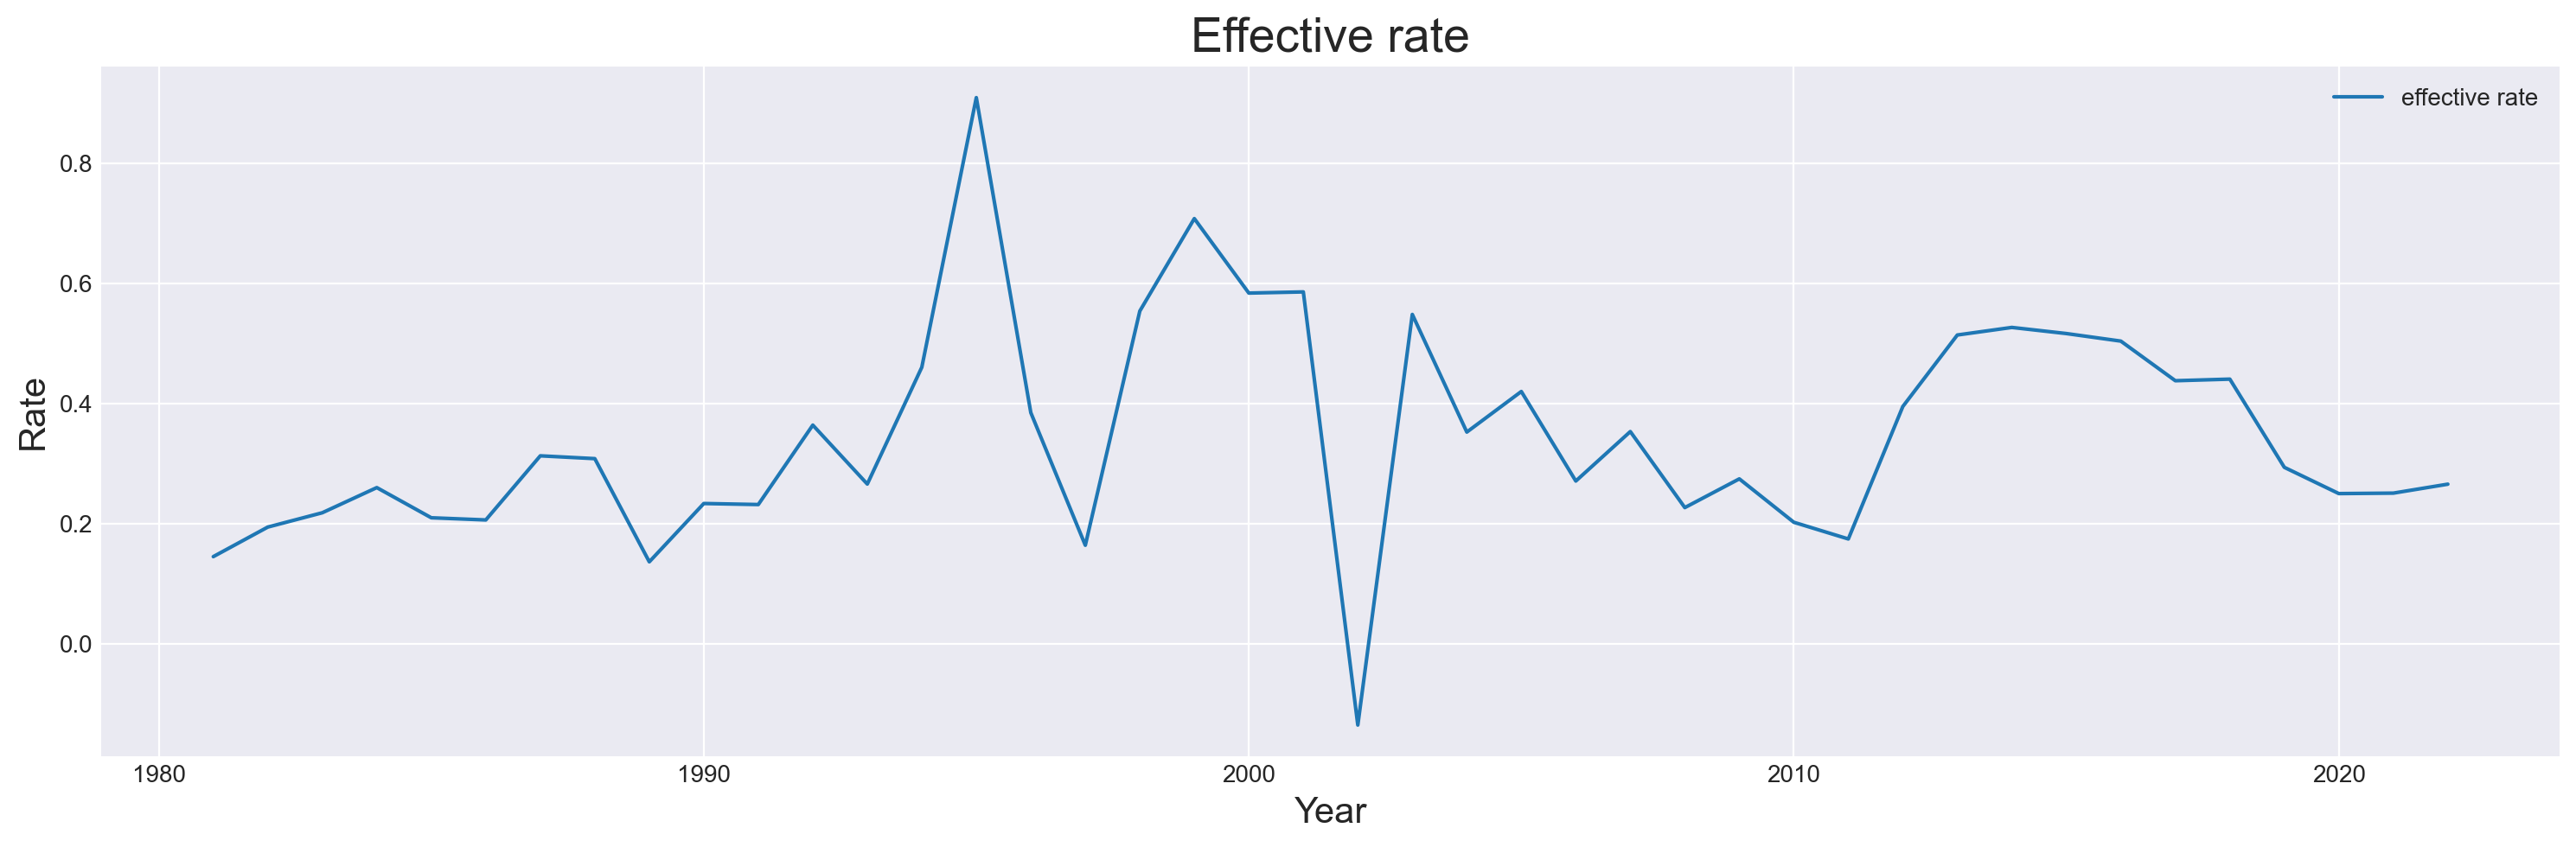

In [238]:
plt.plot(rates['Effective rate'],label = 'effective rate')
plt.title('Effective rate',size = 20)
plt.xlabel('Year',size = 15)
plt.ylabel('Rate',size = 15)
plt.legend()
plt.show()

In [239]:
effective_rates = list(rates['Effective rate'].values)

In [240]:
# using vasicek interest rate model to model evolution of effective rates
vasicek = Interest_rates.vasicek(data = effective_rates,number_of_prediction_points = 7)

In [241]:
# fitting model
vasicek.fit()

In [242]:
# expectation
vasicek.expectation()

[0.31097624315982414,
 0.3323827058253736,
 0.3424981801564191,
 0.34727817685838286,
 0.34953693089433163,
 0.35060428932845333,
 0.35110866209713865]

In [243]:
expected_effective_rates = pd.DataFrame({'Rates':vasicek.expectation()},index = list(range(2023,2023 + len(vasicek.expectation()))))

In [244]:
expected_effective_rates

Rates
2023  0.310976
2024  0.332383
2025  0.342498
2026  0.347278
2027  0.349537
2028  0.350604
2029  0.351109

In [245]:
# variance
vasicek.variance()

[0.009309333575358203,
 0.011388078881527227,
 0.011852256259310521,
 0.011955905627709026,
 0.011979050210111369,
 0.011984218323558228,
 0.011985372347257396]

In [246]:
# ols model results
vasicek.ols_model_results()

                            OLS Regression Results                            
Dep. Variable:                   Diff   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     24.03
Date:                Mon, 04 Mar 2024   Prob (F-statistic):           1.70e-05
Time:                        16:37:30   Log-Likelihood:                 13.424
No. Observations:                  41   AIC:                            -22.85
Df Residuals:                      39   BIC:                            -19.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2635      0.060      4.389      0.0

In [247]:
# defining pv total premium dataframe
pv_total_premium = Total_premium.join([expected_effective_rates])

In [248]:
pv_total_premium.drop(['Ratio','Pure premium','Gross rate','Exposures','Exposures shift()'],axis = 'columns',inplace = True)

In [249]:
pv_total_premium

Total gross rates     Rates
2025       9.685596e+07  0.342498
2026       1.250071e+08  0.347278
2027       1.599737e+08  0.349537
2028       1.978679e+08  0.350604
2029       2.485065e+08  0.351109

In [250]:
add_2024 = pd.DataFrame({'Total gross rates':np.nan,'Rates':expected_effective_rates.Rates[2024]},index = [2024])

In [251]:
pv_total_premium = pd.concat([add_2024,pv_total_premium])

In [252]:
pv_total_premium

Total gross rates     Rates
2024                NaN  0.332383
2025       9.685596e+07  0.342498
2026       1.250071e+08  0.347278
2027       1.599737e+08  0.349537
2028       1.978679e+08  0.350604
2029       2.485065e+08  0.351109

In [253]:
# since effective rates in the years before are the ones used in computation of present values
pv_total_premium['Rates shift()'] = pv_total_premium.Rates.shift()

In [254]:
pv_total_premium

Total gross rates     Rates  Rates shift()
2024                NaN  0.332383            NaN
2025       9.685596e+07  0.342498       0.332383
2026       1.250071e+08  0.347278       0.342498
2027       1.599737e+08  0.349537       0.347278
2028       1.978679e+08  0.350604       0.349537
2029       2.485065e+08  0.351109       0.350604

In [255]:
# defining pv gross rate column
pv_total_premium['PV gross rates, year(-1)'] = pv_total_premium.apply(lambda col:Time_value.present_value(col['Total gross rates'],col['Rates shift()'],1),axis = 'columns')

In [256]:
pv_total_premium

Total gross rates     Rates  Rates shift()  PV gross rates, year(-1)
2024                NaN  0.332383            NaN                       NaN
2025       9.685596e+07  0.342498       0.332383              7.269380e+07
2026       1.250071e+08  0.347278       0.342498              9.311532e+07
2027       1.599737e+08  0.349537       0.347278              1.187384e+08
2028       1.978679e+08  0.350604       0.349537              1.466191e+08
2029       2.485065e+08  0.351109       0.350604              1.839965e+08

In [257]:
# defining pv annuity certain column
pv_total_premium['PV annuity certain(1), year(-1)'] = pv_total_premium.apply(lambda col:Annuity(interest_rate = col['Rates shift()']/12,number_of_terms = 12,amount = 1).certain_present_value(),axis = 'columns')

In [258]:
pv_total_premium

Total gross rates     Rates  Rates shift()  PV gross rates, year(-1)  \
2024                NaN  0.332383            NaN                       NaN   
2025       9.685596e+07  0.342498       0.332383              7.269380e+07   
2026       1.250071e+08  0.347278       0.342498              9.311532e+07   
2027       1.599737e+08  0.349537       0.347278              1.187384e+08   
2028       1.978679e+08  0.350604       0.349537              1.466191e+08   
2029       2.485065e+08  0.351109       0.350604              1.839965e+08   

      PV annuity certain(1), year(-1)  
2024                              NaN  
2025                        10.092153  
2026                        10.041226  
2027                        10.017293  
2028                        10.006013  
2029                        10.000689

In [259]:
# defining tax dataframe
tax_df = pv_total_premium.join([exposures])

In [260]:
tax_df

Total gross rates     Rates  Rates shift()  PV gross rates, year(-1)  \
2024                NaN  0.332383            NaN                       NaN   
2025       9.685596e+07  0.342498       0.332383              7.269380e+07   
2026       1.250071e+08  0.347278       0.342498              9.311532e+07   
2027       1.599737e+08  0.349537       0.347278              1.187384e+08   
2028       1.978679e+08  0.350604       0.349537              1.466191e+08   
2029       2.485065e+08  0.351109       0.350604              1.839965e+08   

      PV annuity certain(1), year(-1)  Exposures  Exposures shift()  
2024                              NaN        NaN                NaN  
2025                        10.092153  2203399.0          2147596.0  
2026                        10.041226  2260115.0          2203399.0  
2027                        10.017293  2317627.0          2260115.0  
2028                        10.006013  2375855.0          2317627.0  
2029                        10.000689  2434788.0          2375855.0

In [261]:
# defining tax column(1), calculating tax
tax_df['Tax, year(-1)'] = tax_df['PV gross rates, year(-1)'] / (tax_df['Exposures shift()'] * tax_df['PV annuity certain(1), year(-1)'])

In [262]:
tax_df

Total gross rates     Rates  Rates shift()  PV gross rates, year(-1)  \
2024                NaN  0.332383            NaN                       NaN   
2025       9.685596e+07  0.342498       0.332383              7.269380e+07   
2026       1.250071e+08  0.347278       0.342498              9.311532e+07   
2027       1.599737e+08  0.349537       0.347278              1.187384e+08   
2028       1.978679e+08  0.350604       0.349537              1.466191e+08   
2029       2.485065e+08  0.351109       0.350604              1.839965e+08   

      PV annuity certain(1), year(-1)  Exposures  Exposures shift()  \
2024                              NaN        NaN                NaN   
2025                        10.092153  2203399.0          2147596.0   
2026                        10.041226  2260115.0          2203399.0   
2027                        10.017293  2317627.0          2260115.0   
2028                        10.006013  2375855.0          2317627.0   
2029                        10.000689  2434788.0          2375855.0   

      Tax, year(-1)  
2024            NaN  
2025       3.353984  
2026       4.208635  
2027       5.244575  
2028       6.322458  
2029       7.743899

In [263]:
# defining tax column(2), calculating tax
tax_df['Tax'] = tax_df['Tax, year(-1)'].shift(-1)

In [264]:
tax_df

Total gross rates     Rates  Rates shift()  PV gross rates, year(-1)  \
2024                NaN  0.332383            NaN                       NaN   
2025       9.685596e+07  0.342498       0.332383              7.269380e+07   
2026       1.250071e+08  0.347278       0.342498              9.311532e+07   
2027       1.599737e+08  0.349537       0.347278              1.187384e+08   
2028       1.978679e+08  0.350604       0.349537              1.466191e+08   
2029       2.485065e+08  0.351109       0.350604              1.839965e+08   

      PV annuity certain(1), year(-1)  Exposures  Exposures shift()  \
2024                              NaN        NaN                NaN   
2025                        10.092153  2203399.0          2147596.0   
2026                        10.041226  2260115.0          2203399.0   
2027                        10.017293  2317627.0          2260115.0   
2028                        10.006013  2375855.0          2317627.0   
2029                        10.000689  2434788.0          2375855.0   

      Tax, year(-1)       Tax  
2024            NaN  3.353984  
2025       3.353984  4.208635  
2026       4.208635  5.244575  
2027       5.244575  6.322458  
2028       6.322458  7.743899  
2029       7.743899       NaN

In [265]:
tax_df.to_csv('tax_df.csv')

In [266]:
import phew

In [267]:
help(phew.Cola)

Help on class Cola in module phew.Cola:

class Cola(builtins.object)
 |  Cola(initial_fund: float, data: list, method: str = 'cpi')
 |  
 |  Returns movement of fund when Cost of living adjustment (COLA) is applied
 |  
 |  args:
 |      initial_fund (float) : initial amount
 |      data (list) : expected cpi/inflation values for the next periods
 |      method (str) : 'cpi','inflation'
 |  
 |  Methods defined here:
 |  
 |  __init__(self, initial_fund: float, data: list, method: str = 'cpi')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  fund_growth(self)
 |      Returns movement fund
 |      
 |      Returns:
 |          float : expected fund values
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [268]:
help(phew.Annuity)

Help on class Annuity in module phew.Annuity:

class Annuity(builtins.object)
 |  Annuity(interest_rate: float, number_of_terms: int, amount: float = 1)
 |  
 |  Returns time values of an annuity
 |  
 |  args:
 |      interest_rate (float) : interest rate
 |      number_of_terms (int) : number of periods
 |      amount (float : amount)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, interest_rate: float, number_of_terms: int, amount: float = 1)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  certain_future_value(self)
 |      Returns future value of annuity certain
 |      
 |      Returns:
 |          float : future value for annuity certain
 |  
 |  certain_present_value(self)
 |      Returns present value of annuity certain
 |      
 |      Returns:
 |          float : present value for annuity certain
 |  
 |  due_future_value(self)
 |      Returns future value of annuity due
 |      
 |      Returns:
 |          float : future value for annu

In [269]:
help(phew.Expenses)

Help on class Expenses in module phew.Expenses:

class Expenses(builtins.object)
 |  Expenses(mean_expenses: float, variance_expenses: float, fund_amount: float)
 |  
 |  Returns expenses allocation
 |  
 |  args:
 |      mean_expenses (float) : x
 |      variance_expenses (float) : y
 |      fund_amount (float) : total fund value
 |  
 |  Methods defined here:
 |  
 |  __init__(self, mean_expenses: float, variance_expenses: float, fund_amount: float)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  montecarlo(self, alpha: int, number_of_replications: int)
 |      Returns optimal expense ratio and variance after running Monte Carlo where expenses is assumed to follow pareto distribution
 |      
 |      args:
 |          alpha (int) : alpha
 |          number_of_replications (int) : number of replications
 |          
 |       Returns:
 |           dict : optimal_ratio, ratio_output,expense_output
 |  
 |  -------------------------------------------------

In [270]:
help(phew.Loss_given_delay)

Help on class Loss_given_delay in module phew.Loss_given_delay:

class Loss_given_delay(builtins.object)
 |  Loss_given_delay(number_of_days: list, ratio_of_workers_to_population: float, carrying_capacity: int, benefit: float, expected_daily_delays_in_a_season: list)
 |  
 |  Returns loss given a trip delay event
 |  
 |  args:
 |      number_of_days (list) : number of days in a year categorised by seasons
 |      ratio_of_workers_to_population (float) : probability of finding a formal sector worker in a bus
 |      carrying_capacity (int) : average carrying capacity for buses
 |      benefit (float) : benefit received at loss event
 |      expected_daily_delays_in_a_season (float) : expected daily delays categorised by seasons
 |  
 |  Methods defined here:
 |  
 |  __init__(self, number_of_days: list, ratio_of_workers_to_population: float, carrying_capacity: int, benefit: float, expected_daily_delays_in_a_season: list)
 |      Initialize self.  See help(type(self)) for accurate signa

In [271]:
help(phew.Premium)

Help on class Premium in module phew.Premium:

class Premium(builtins.object)
 |  Returns formulae to compute premium
 |  
 |  Methods defined here:
 |  
 |  expense_ratio(fund_costs: float, fund_assets: float)
 |      Returns expense ratio by dividing costs by fund amount
 |      
 |      args:
 |          fund_costs (float) : fund expenses
 |          funds_assets (float) : total fund value
 |          
 |      Returns:
 |          float : expense ratio
 |  
 |  gross_premium(gross_rate: float, units: float)
 |      Returns gross premium by multiplying gross rate by units
 |      
 |      args:
 |          gross_rate (float) : price of a single unit of exposure
 |          units (float) : number of units (purchases)
 |          
 |      Returns:
 |          float : gross premium
 |  
 |  gross_rate(pure_premium: float, expense_ratio: float)
 |      Returns gross rate
 |      
 |      args:
 |          pure_premium (float) : price of insurance that excludes expenses
 |          expens

In [272]:
help(phew.Time_value)

Help on class Time_value in module phew.Time_value:

class Time_value(builtins.object)
 |  Returns time value of money
 |  
 |  Methods defined here:
 |  
 |  future_value(amount: float, interest_rate: float, periods: float)
 |      Returns future value of an amount
 |      
 |      args:
 |          amount (float) : present value
 |          interest_rate (float) : interest rate
 |          periods (float) : number of periods
 |          
 |      Returns:
 |          float : future value
 |  
 |  present_value(amount: float, interest_rate: float, periods: float)
 |      Returns present value of an amount
 |      
 |      args:
 |          amount (float) : future value
 |          interest_rate (float) : interest rate
 |          periods (float) : number of periods
 |          
 |      Returns:
 |          float :  present value
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for ins

In [273]:
help(phew.Interest_rates)

Help on class Interest_rates in module phew.Interest_rates:

class Interest_rates(builtins.object)
 |  Returns functions for interest rates
 |  
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  compute = <class 'phew.Interest_rates.formulae.compute'>
 |      Returns formulae for interest rates
 |  
 |  
 |  vasicek = <class 'phew.Interest_rates.models.vasicek'>
 |      Returns functions for simulating evolution of interest rates using vasicek model
 |      
 |      args:
 |          data (list) : interest rate data
 |          number_of_prediction_points (int) : number of prediction points



In [274]:
help(Interest_rates.compute)

Help on class compute in module phew.Interest_rates.formulae:

class compute(builtins.object)
 |  Returns formulae for interest rates
 |  
 |  Methods defined here:
 |  
 |  effective_interest_rate(nominal_interest_rate: float, number_of_compounding_periods: int)
 |      Returns effective interest rate converted from nominal interest rate
 |      
 |      args:
 |          nominal_interest_rate (float) : real interest rate plus inflation
 |          number_of_compounding_periods (int) : number of compounding periods
 |          
 |      Returns:
 |          float : effective interest rate
 |  
 |  inflation_rate(real_interest_rate: float, nominal_interest_rate: float)
 |      Returns inflation rate by subtracting real interest rate from nominal interest rate
 |      
 |      args:
 |          real_interest_rate (float) : interest rate adjusted for inflation
 |          nominal_interest_rate (float) : real interest rate plus inflation
 |          
 |      Returns:
 |          float : in

In [275]:
help(Interest_rates.vasicek)

Help on class vasicek in module phew.Interest_rates.models:

class vasicek(builtins.object)
 |  vasicek(data: list, number_of_prediction_points: int)
 |  
 |  Returns functions for simulating evolution of interest rates using vasicek model
 |  
 |  args:
 |      data (list) : interest rate data
 |      number_of_prediction_points (int) : number of prediction points
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data: list, number_of_prediction_points: int)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  expectation(self)
 |      Returns expected rate today
 |      
 |      Returns:
 |          list: expected rate today
 |  
 |  fit(self)
 |      Calibration of the model
 |  
 |  ols_model_results(self)
 |      Returns statistics for ols model used in calibration
 |      
 |      Returns:
 |          object: Returns statistics for ols model used in calibration
 |  
 |  variance(self)
 |      Returns variance of the rate today
 |      
 |      Retu

In [276]:
import mkdocs

In [278]:
help(mkdocs)

Help on package mkdocs:

NAME
    mkdocs - # For acceptable version formats, see https://www.python.org/dev/peps/pep-0440/

PACKAGE CONTENTS
    __main__
    commands (package)
    config (package)
    contrib (package)
    exceptions
    livereload (package)
    localization
    plugins
    structure (package)
    tests (package)
    theme
    themes (package)
    utils (package)

VERSION
    1.5.3

FILE
    c:\users\lenovo\anaconda3\lib\site-packages\mkdocs\__init__.py




In [283]:
from mkdocs import livereload

In [284]:
help(livereload)

Help on package mkdocs.livereload in mkdocs:

NAME
    mkdocs.livereload

PACKAGE CONTENTS


CLASSES
    socketserver.ThreadingMixIn(builtins.object)
        LiveReloadServer(socketserver.ThreadingMixIn, wsgiref.simple_server.WSGIServer)
    wsgiref.simple_server.WSGIServer(http.server.HTTPServer)
        LiveReloadServer(socketserver.ThreadingMixIn, wsgiref.simple_server.WSGIServer)
    
    class LiveReloadServer(socketserver.ThreadingMixIn, wsgiref.simple_server.WSGIServer)
     |  LiveReloadServer(builder: 'Callable[[], None]', host: 'str', port: 'int', root: 'str', mount_path: 'str' = '/', polling_interval: 'float' = 0.5, shutdown_delay: 'float' = 0.25) -> 'None'
     |  
     |  Method resolution order:
     |      LiveReloadServer
     |      socketserver.ThreadingMixIn
     |      wsgiref.simple_server.WSGIServer
     |      http.server.HTTPServer
     |      socketserver.TCPServer
     |      socketserver.BaseServer
     |      builtins.object
     |  
     |  Methods defined 